# Predict Wine Quality with Regularization

---

The data is from the Wine Quality Dataset in the UCI Machine Learning Repository. We’re looking at the red wine data in particular and while the original dataset has a 1-10 rating for each wine, I've made it a classification problem with a wine quality of good (>5 rating) or bad (<=5 rating). The goals of this project are to:

* implement different logistic regression classifiers
* find the best ridge-regularized classifier using hyperparameter tuning
* implement a tuned lasso-regularized feature selection method

What we’re working with:

* 11 input variables (based on physicochemical tests): ‘fixed acidity’, ‘volatile acidity’, ‘citric acid’, ‘residual sugar’,’chlorides’, ‘free sulfur dioxide’, ‘total sulfur dioxide’, ‘density’, ‘pH’, ‘sulphates’ and ‘alcohol’.
* An output variable, ‘quality’ (0 for bad and 1 for good)

---

1. Introduction

Title: Logistic Regression Analysis: A Comprehensive Study on the Impact of Regularization Techniques

Introduction:

In this project, we aim to explore the nuanced effects of logistic regression with a specific focus on regularization techniques. Logistic regression is a fundamental tool for classification problems, often used to predict binary outcomes. However, in the presence of high-dimensional data or features with varying scales, the model may overfit, capturing noise instead of true patterns. This is where regularization becomes crucial.

We delve into the mechanics of L1 (Lasso) and L2 (Ridge) regularization to understand their impact on model performance and feature selection. Using a dataset with diverse features, we analyze the effects of varying regularization strengths on both model accuracy and interpretability. Through a combination of visualization and performance metrics, this project provides a comprehensive overview of how different levels of regularization influence the logistic regression model, ultimately guiding us toward the optimal balance between model complexity and predictive power.

We aim to explore the application of logistic regression on a wine quality dataset to understand the influence of various features on the quality of wine. The dataset includes chemical properties of wines such as acidity, sugar content, and alcohol percentage. These features play a crucial role in determining the quality rating of each wine, which ranges from 1 (poor) to 10 (excellent).

Through visualizations and performance metrics, we investigate how varying regularization strengths affect the model's ability to predict wine quality accurately, providing insights into the most influential chemical properties. This analysis is essential for winemakers and wine enthusiasts who wish to understand the relationship between wine composition and perceived quality.

In [3]:
# !pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo 

In [5]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

In [6]:
# metadata 
wine_quality.metadata

{'uci_id': 186,
 'name': 'Wine Quality',
 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality',
 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv',
 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).',
 'area': 'Business',
 'tasks': ['Classification', 'Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 4898,
 'num_features': 11,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['quality'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2009,
 'last_updated': 'Wed Nov 15 2023',
 'dataset_doi': '10.24432/C56S3T',
 'creators': ['Paulo Cortez',
  'A. Cerdeira',
  'F. Almeida',
  'T. Matos',
  'J. Reis'],
 'intro_paper': {'title': 'Modeling wine preferences 

In [7]:
# variable information 
wine_quality.variables

name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  None             no  
2                     None  None             no  
3                     None  None             no  
4                     None  None             no  
5                     None  None             no  
6                     None  None             no  
7                     None  None             no  
8                     None  None             no  
9                     None  None             no  
10                    None  None             no  
11  score between 0 and 10  None             no  
12            red or white  None             no

In [8]:
# Load Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, auc, roc_curve, average_precision_score, precision_recall_curve

In [9]:
# Load data 
df = pd.read_csv('https://archive.ics.uci.edu/static/public/186/data.csv')
# Define feature columns and target variable
y = df['quality']
features = df.drop(columns = ['quality'])

In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score

# Suppress specific warnings to maintain a clean output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [23]:
# Step 1: Encoding 'color' Feature - Let's give our data a colorful twist with care.
# Data Preparation and Preprocessing
# Encode categorical feature 'color' into numerical values
# This is necessary because machine learning models require numerical input.
label_encoder = LabelEncoder()
features['color'] = label_encoder.fit_transform(features['color'])

In [25]:
# Step 2: Standardizing Features - Bringing all features onto the same playing field with precision.
# Standardize the features using StandardScaler
# Standardization ensures that each feature contributes equally to the model by having a mean of 0 and a variance of 1.
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [27]:
# Step 3: Train-Test Split - Preparing to train and test with precision.
# Split the data into training and testing sets (80-20 split)
# This allows us to train the model on one subset and evaluate it on another, ensuring unbiased performance metrics.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Step 4: Logistic Regression (No Regularization) - Letting the data speak for itself.
# Initial Logistic Regression Model (No Regularization)
# Train a Logistic Regression model without regularization to establish a baseline.
clf_no_reg = LogisticRegression(penalty=None, max_iter=10000, solver='saga')
clf_no_reg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty=None, solver='saga')

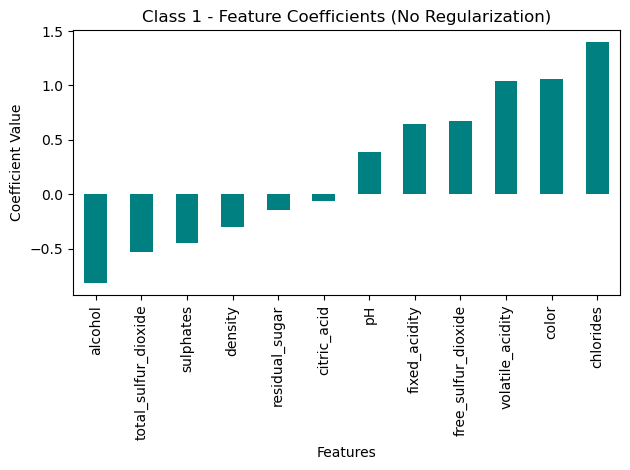

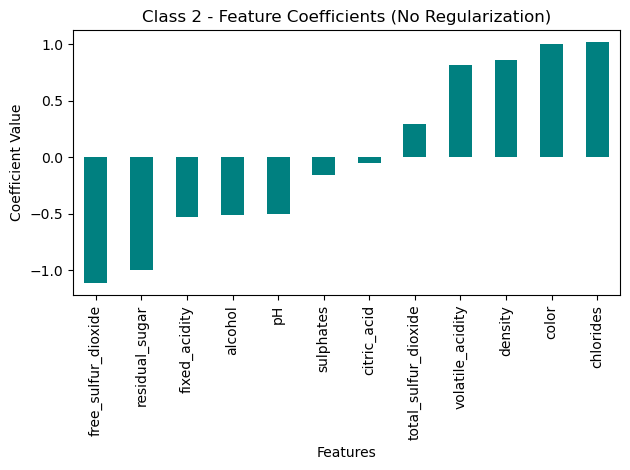

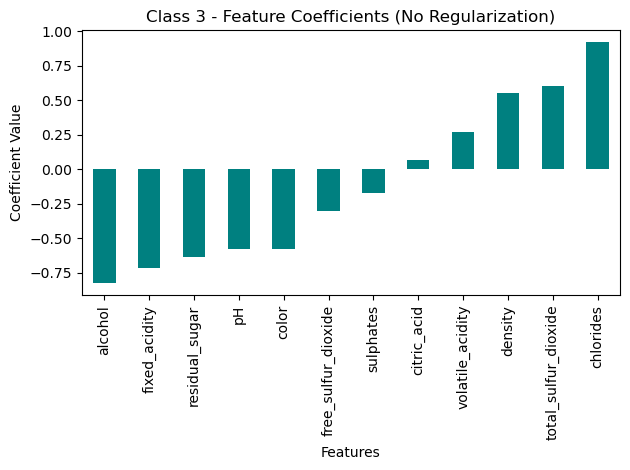

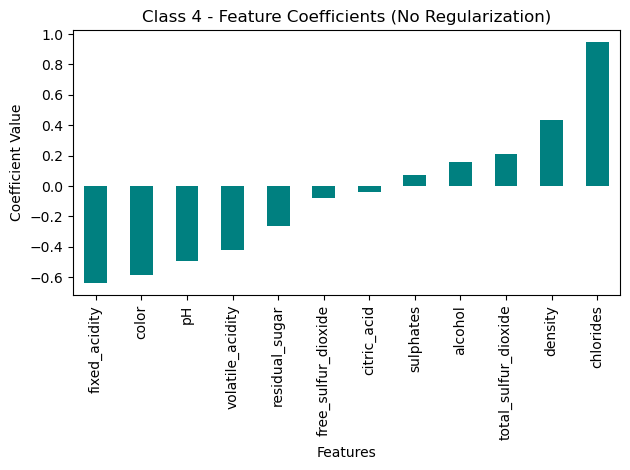

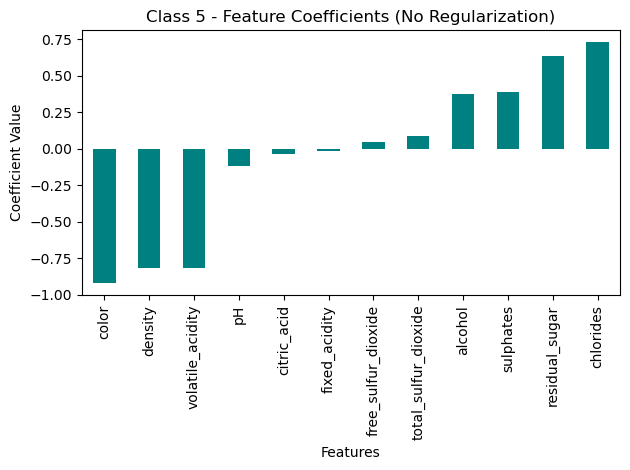

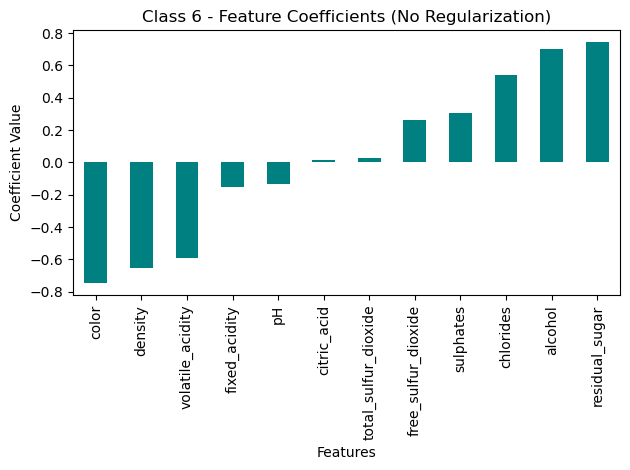

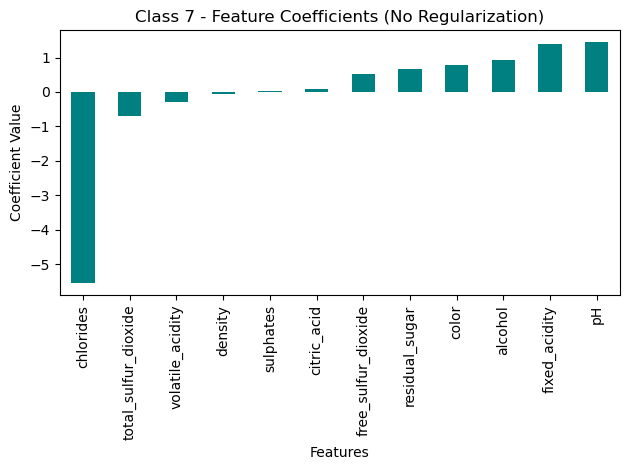

In [37]:
# Step 5: Visualizing Coefficients - Unveiling the impact of each feature on each class.
# Visualizing Coefficients of the Model Without Regularization
# This chart shows the impact of each feature on the outcome for each class, highlighting potential overfitting.
predictors = features.columns
coefficients = clf_no_reg.coef_

for i in range(coefficients.shape[0]):  # One plot for each class
    coef_series = pd.Series(coefficients[i], index=predictors).sort_values()
    coef_series.plot(kind='bar', title=f'Class {i + 1} - Feature Coefficients (No Regularization)', color='teal')
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

In [39]:
# Step 6: Model Performance - How well did our unregularized model do?
# Model Performance Evaluation Without Regularization
# Evaluating how well the model performs on both training and testing data.
print('Training F1 Score (No Regularization):', f1_score(y_train, y_pred_train := clf_no_reg.predict(X_train), average='weighted'))
print('Testing F1 Score (No Regularization):', f1_score(y_test, y_pred_test := clf_no_reg.predict(X_test), average='weighted'))


Training F1 Score (No Regularization): 0.5175631675575494
Testing F1 Score (No Regularization): 0.5134556617175049


In [41]:
# Step 7: Logistic Regression with L2 Regularization - Adding some regularization magic.
# Logistic Regression with L2 Regularization
# Train the model with L2 regularization (default)
# L2 regularization penalizes large coefficients, preventing overfitting and improving generalization.
clf_default = LogisticRegression(max_iter=10000)
clf_default.fit(X_train, y_train)

print('Ridge-Regularized Training F1 Score:', f1_score(y_train, clf_default.predict(X_train), average='weighted'))
print('Ridge-Regularized Testing F1 Score:', f1_score(y_test, clf_default.predict(X_test), average='weighted'))

Ridge-Regularized Training F1 Score: 0.5183370499589944
Ridge-Regularized Testing F1 Score: 0.5122679135745701


In [43]:
# Step 8: Coarse Hyperparameter Tuning - Exploring different strengths of regularization.
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
train_scores, test_scores = [], []

for C in C_values:
    clf = LogisticRegression(C=C, max_iter=10000)
    clf.fit(X_train, y_train)
    train_scores.append(f1_score(y_train, clf.predict(X_train), average='weighted'))
    test_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))

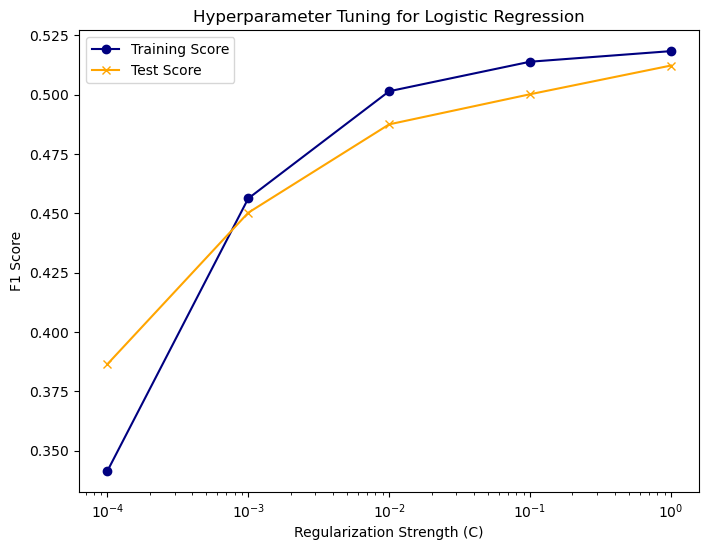

In [45]:
# Step 9: Visualizing Hyperparameter Tuning - The sweet spot of regularization.
plt.figure(figsize=(8, 6))
plt.plot(C_values, train_scores, marker='o', label='Training Score', color='navy')
plt.plot(C_values, test_scores, marker='x', label='Test Score', color='orange')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('F1 Score')
plt.title('Hyperparameter Tuning for Logistic Regression')
plt.legend()
plt.show()

In [55]:
# Step 10: GridSearchCV for Fine-tuning - Let’s find the optimal regularization strength.
param_grid = {'C': np.logspace(-4, -2, 100)}
gs = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, scoring='f1', cv=5)
gs.fit(X_train, y_train)

print('Optimal C Value:', gs.best_params_['C'])
print('Best F1 Score:', gs.best_score_)

Optimal C Value: 0.0001
Best F1 Score: nan


In [47]:
# Step 11: Validating the Best Model - Testing the waters with our best model.
clf_best = LogisticRegression(C=gs.best_params_['C'], max_iter=10000)
clf_best.fit(X_train, y_train)
print('Best Model F1 Score on Test Set:', f1_score(y_test, clf_best.predict(X_test), average='weighted'))

Best Model F1 Score on Test Set: 0.386438478953238


In [49]:
# Step 12: L1 Regularization with LogisticRegressionCV - Sparsity, meet Logistic Regression.
clf_l1 = LogisticRegressionCV(Cs=np.logspace(-2, 2, 100), cv=5, penalty='l1', scoring='f1', solver='liblinear', max_iter=10000)
clf_l1.fit(X, y)
print('Optimal C for L1:', clf_l1.C_)
print('L1 Regularization Coefficients:', clf_l1.coef_)


Optimal C for L1: [0.59948425 2.91505306 0.01097499 1.26185688 1.149757   0.01
 0.01      ]
L1 Regularization Coefficients: [[ 0.77188426  0.73868527 -0.14059384 -0.00995815  0.37577177  0.44744519
   0.          0.          0.4462427  -0.43231237  0.          0.75048314]
 [ 0.0328452   0.8275471  -0.05230334 -0.70637572  0.02471997 -0.76806296
  -0.16189334  0.58442984  0.05031409 -0.11292406 -0.31147416  1.55161351]
 [ 0.          0.38486245  0.         -0.069322    0.          0.
   0.02533213  0.          0.         -0.07928879 -0.92030713  0.        ]
 [-0.15245423 -0.44769655 -0.06997294 -0.10917493  0.          0.09061577
  -0.16423082  0.38541393 -0.06387736  0.02260614  0.32225188 -0.01512849]
 [ 0.54652975 -0.61421369 -0.05044793  0.82557604 -0.27072375  0.11985532
  -0.18237465 -1.0156561   0.34387381  0.34529359  0.49494468 -0.3015655 ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.30865683  0.        

In [50]:
# Step 13: Visualizing L1 Coefficients - Sparse and beautiful.
coefficients = clf_l1.coef_

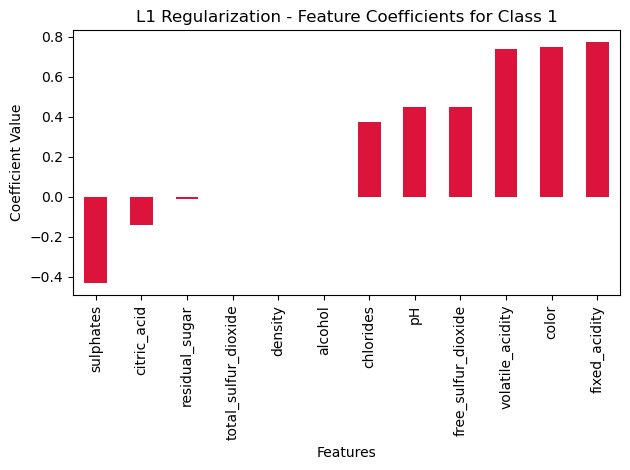

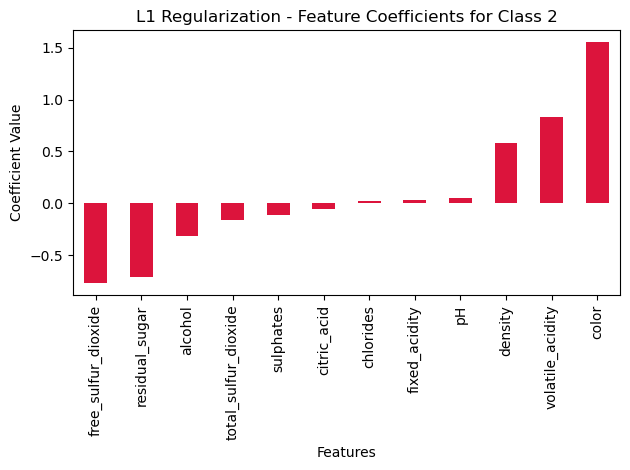

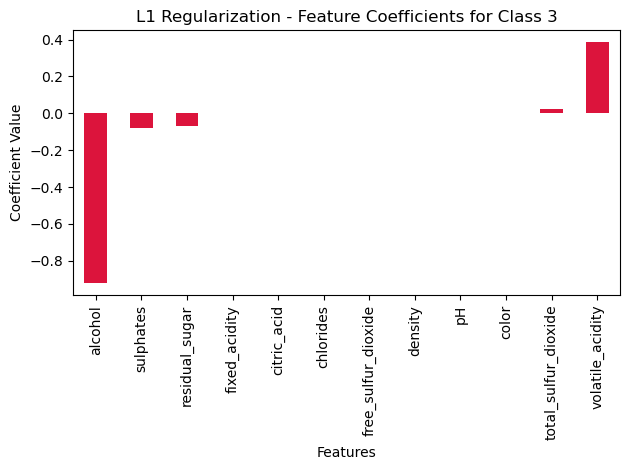

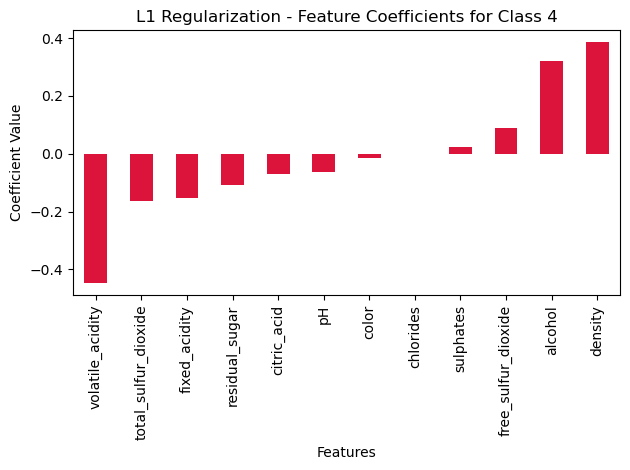

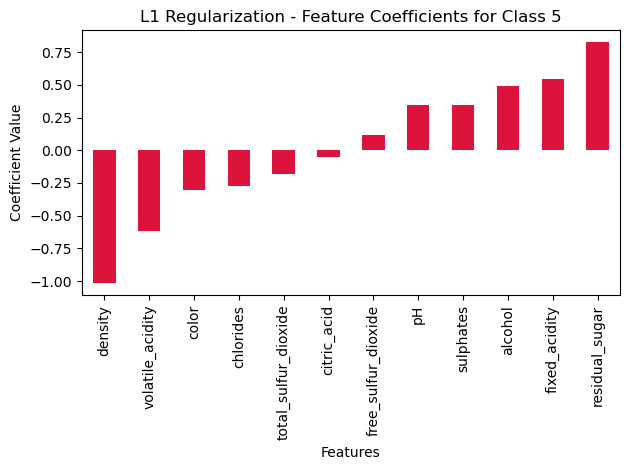

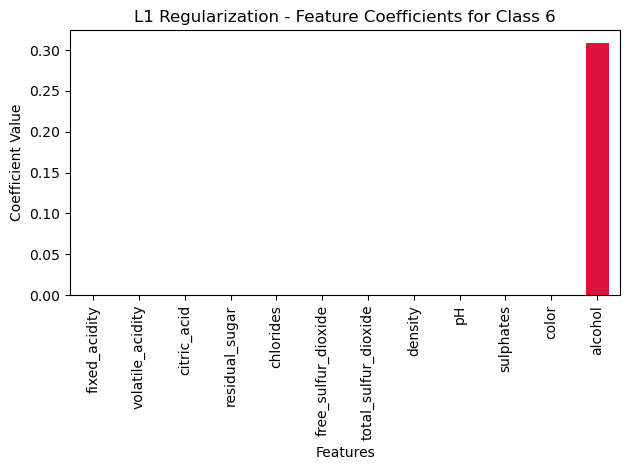

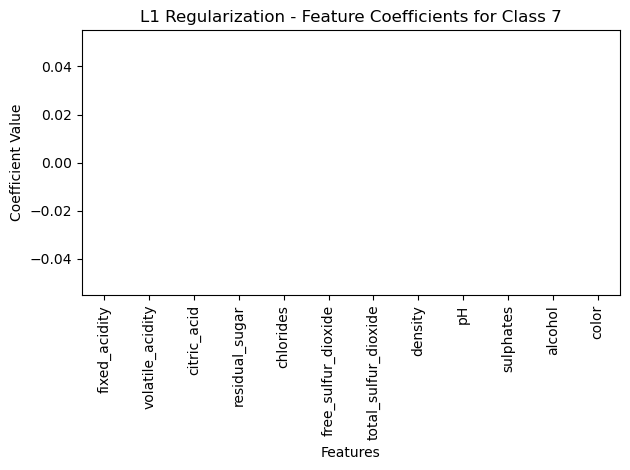

In [56]:
# Iterate over each class and plot the coefficients
for i in range(coefficients.shape[0]):  # Loop through each class's coefficients
    coef_series = pd.Series(coefficients[i], index=predictors).sort_values()
    coef_series.plot(kind='bar', title=f'L1 Regularization - Feature Coefficients for Class {i + 1}', color='crimson')
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

--- 

In [58]:
# Extract the target variable 'quality' (ensure it is correctly named in the dataset)
target_column = 'quality'

# Check if the target_column exists in the DataFrame
if target_column in df.columns:
    y = df[target_column]
    features = df.drop(columns=[target_column])
    print("First few values of y:\n", y.head())
    print("First few rows of features:\n", features.head())
else:
    print(f"Column '{target_column}' not found in the DataFrame.")


X = df.drop(columns=['quality'])
y = df['quality']
df.head()

First few values of y:
 0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64
First few rows of features:
    fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0 

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

L2 Regularization 

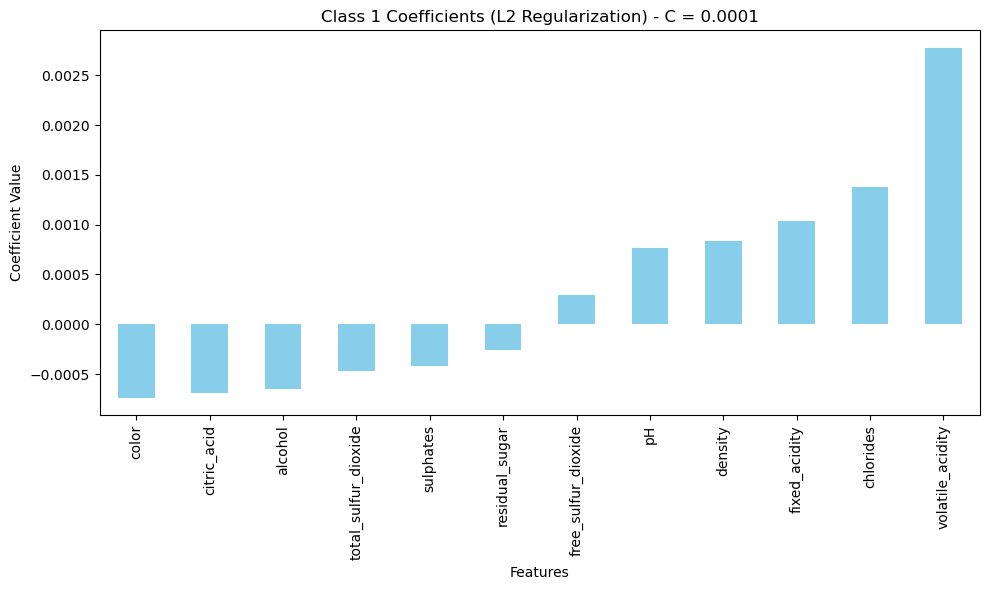

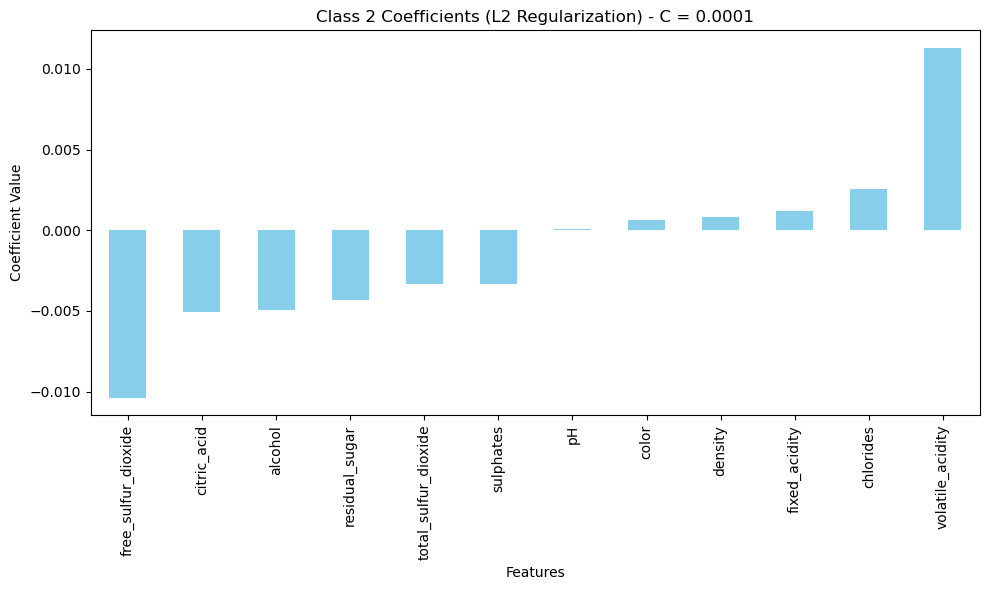

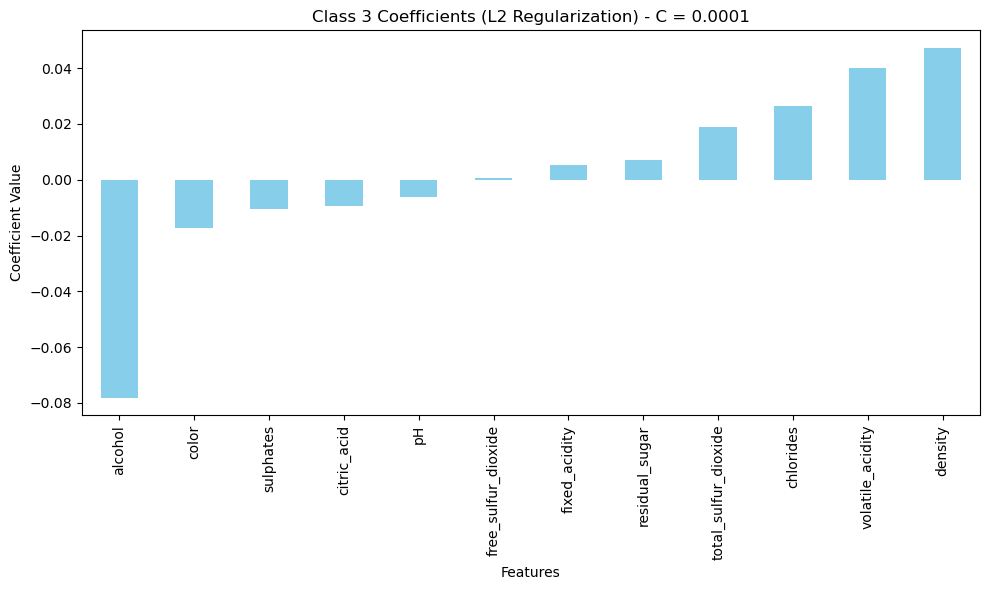

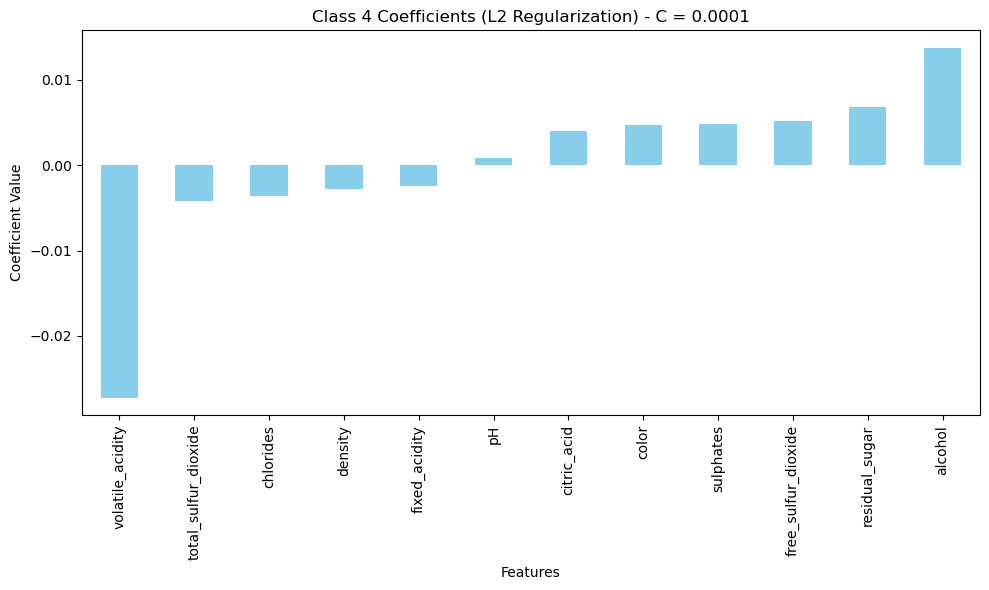

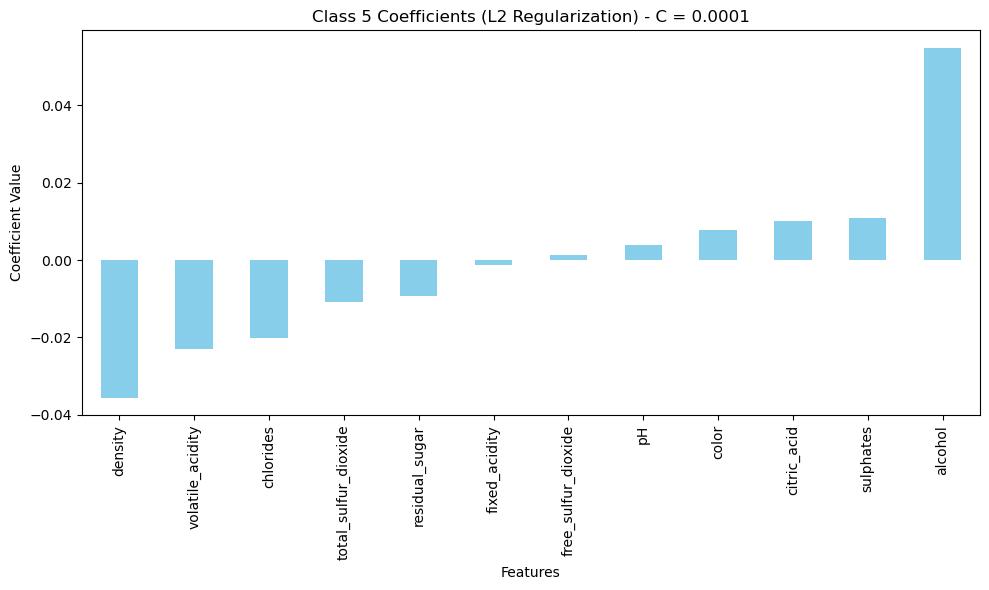

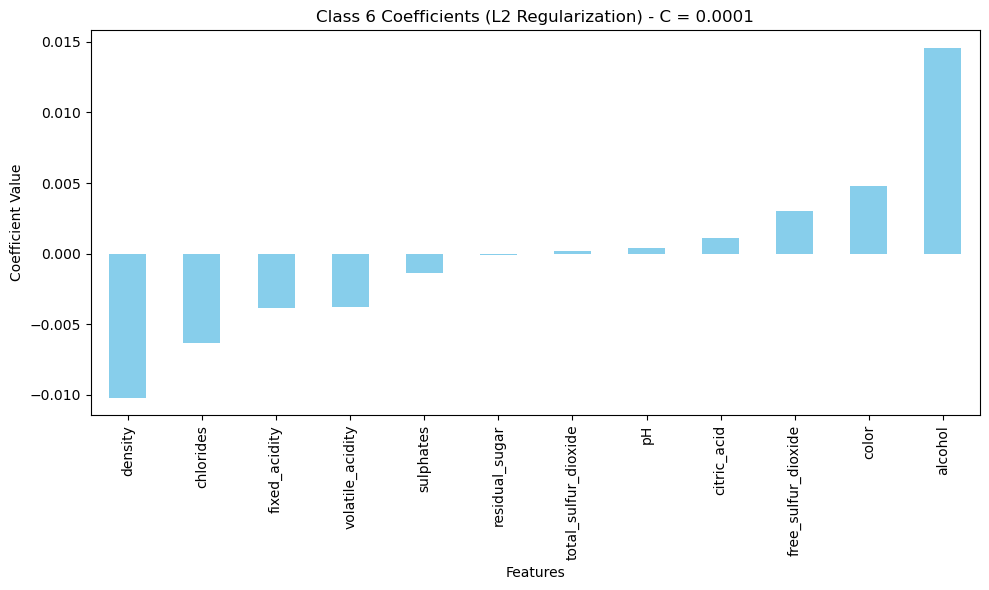

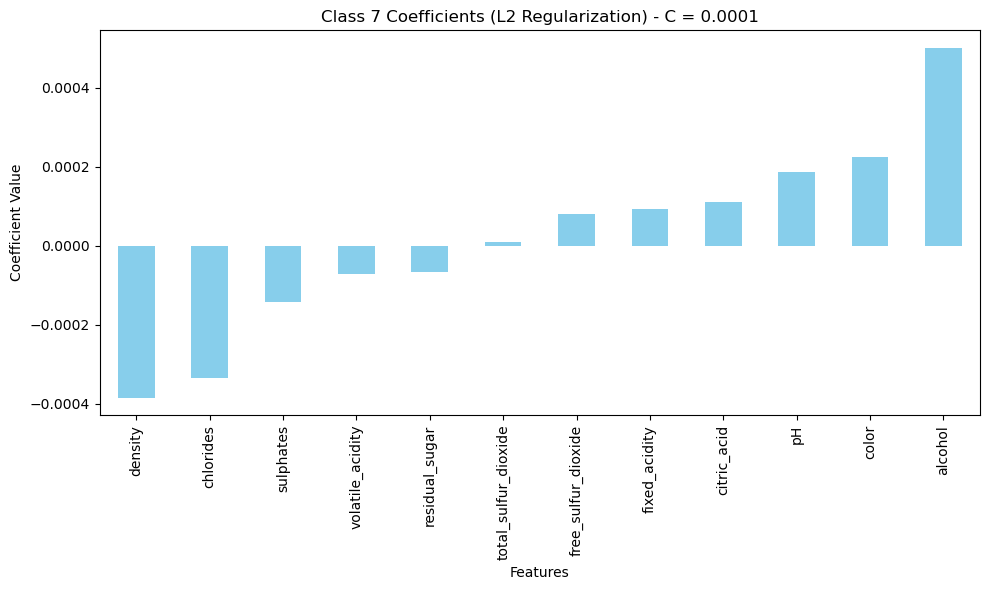

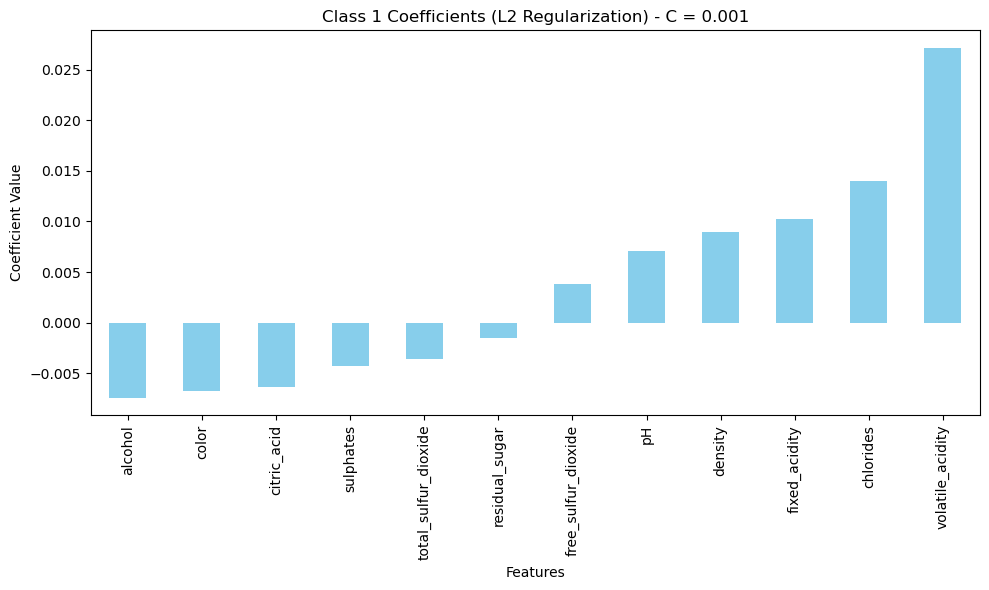

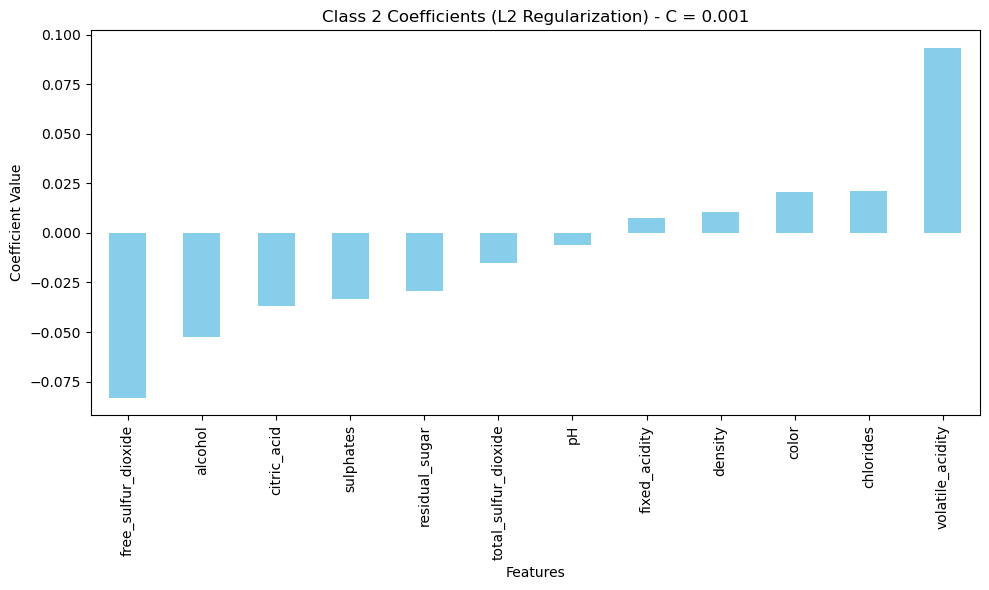

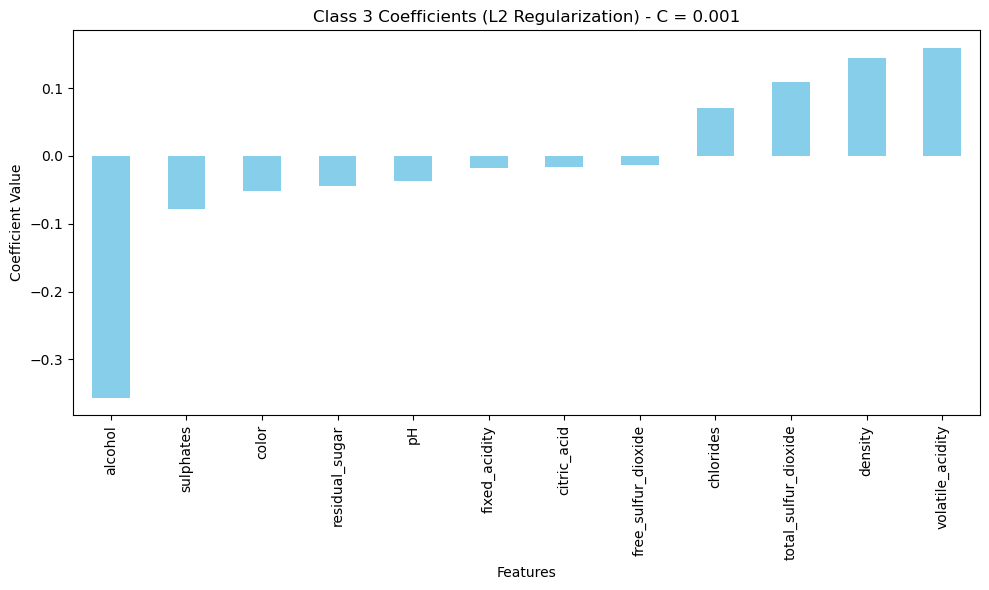

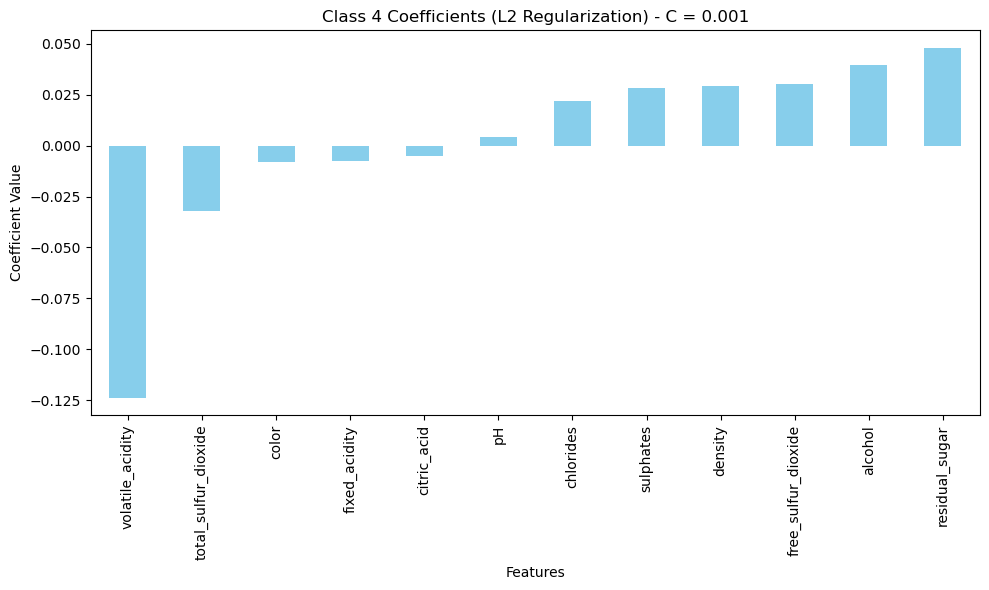

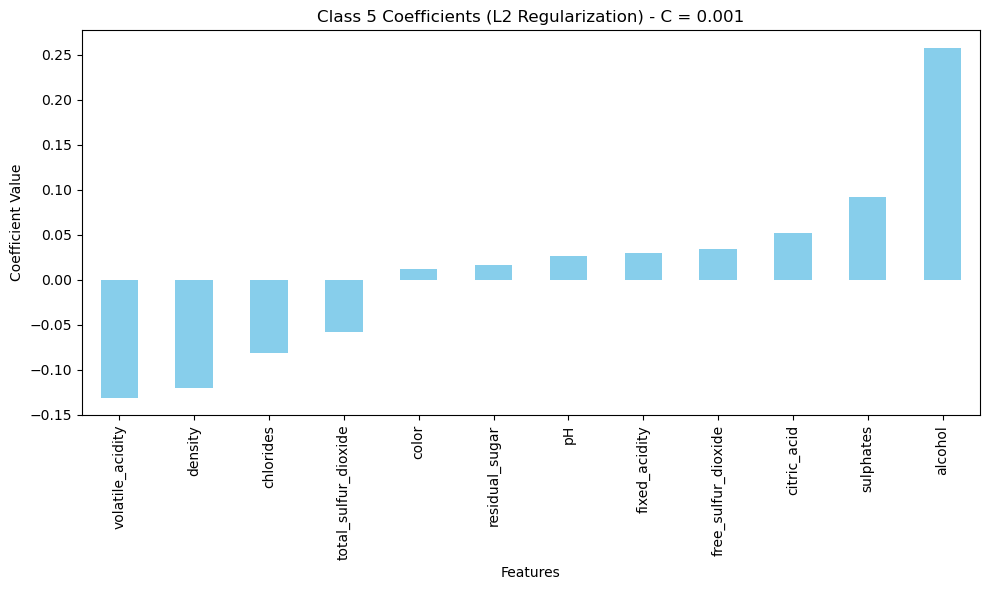

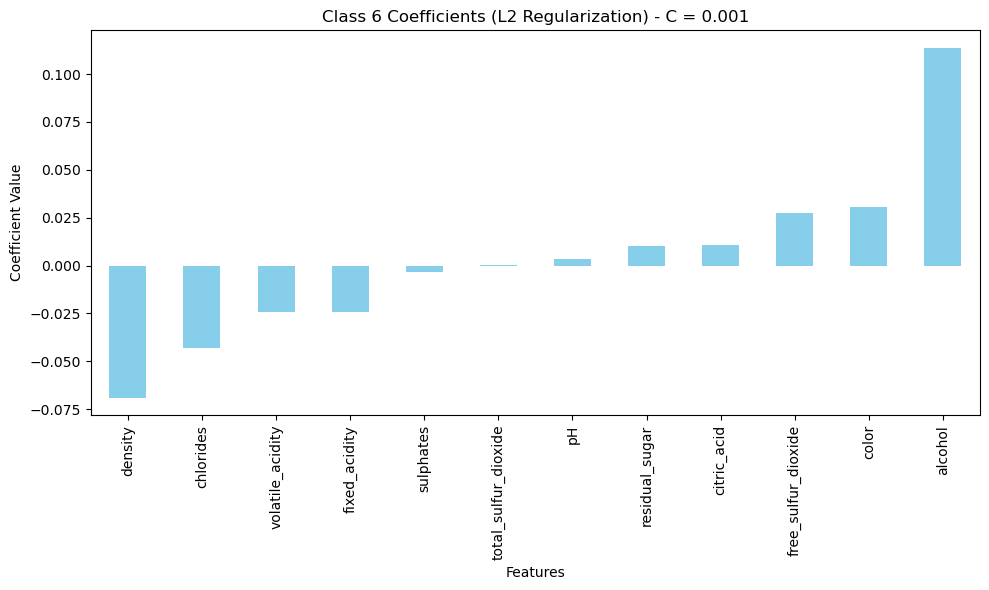

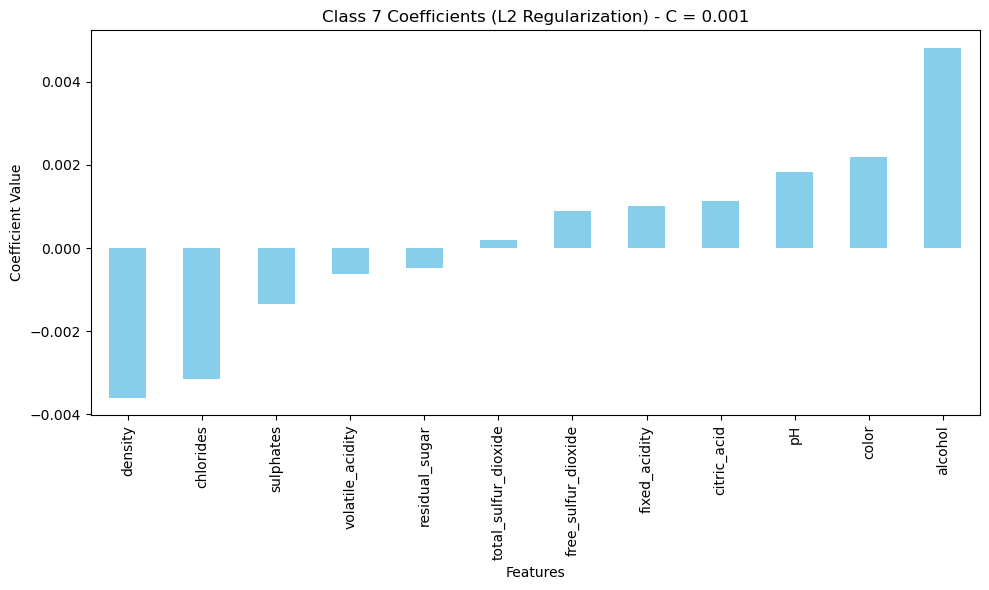

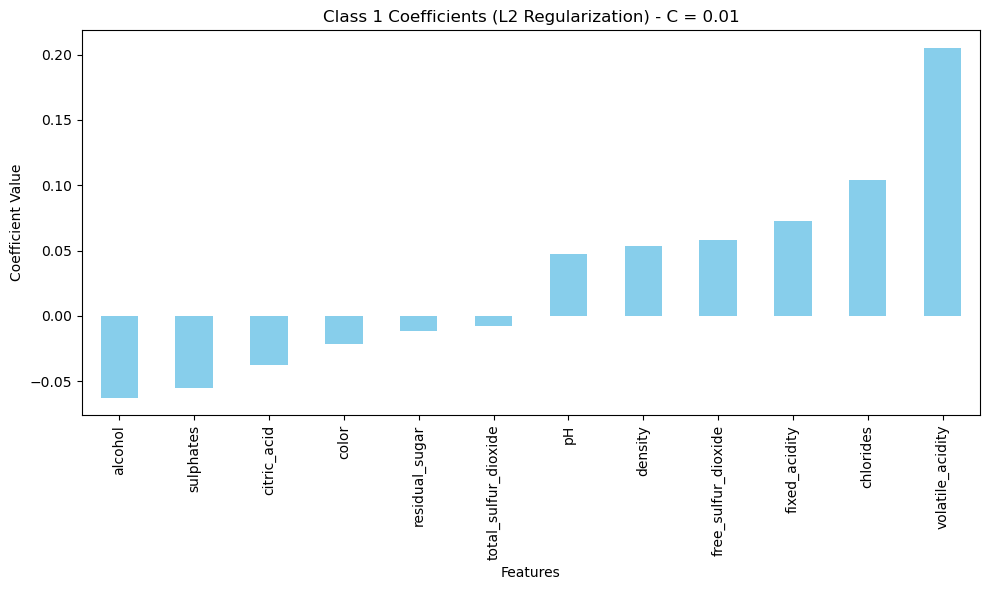

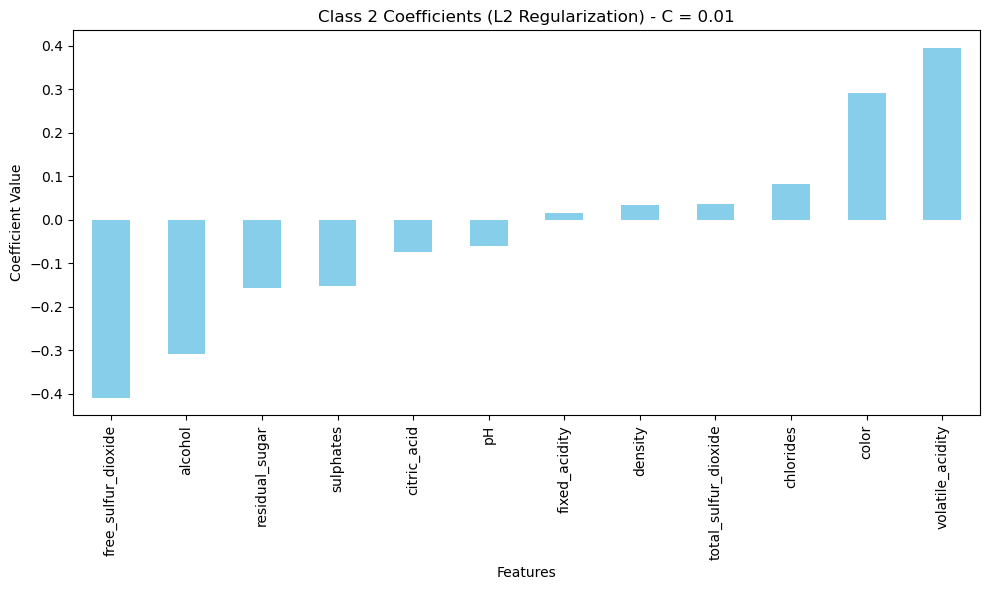

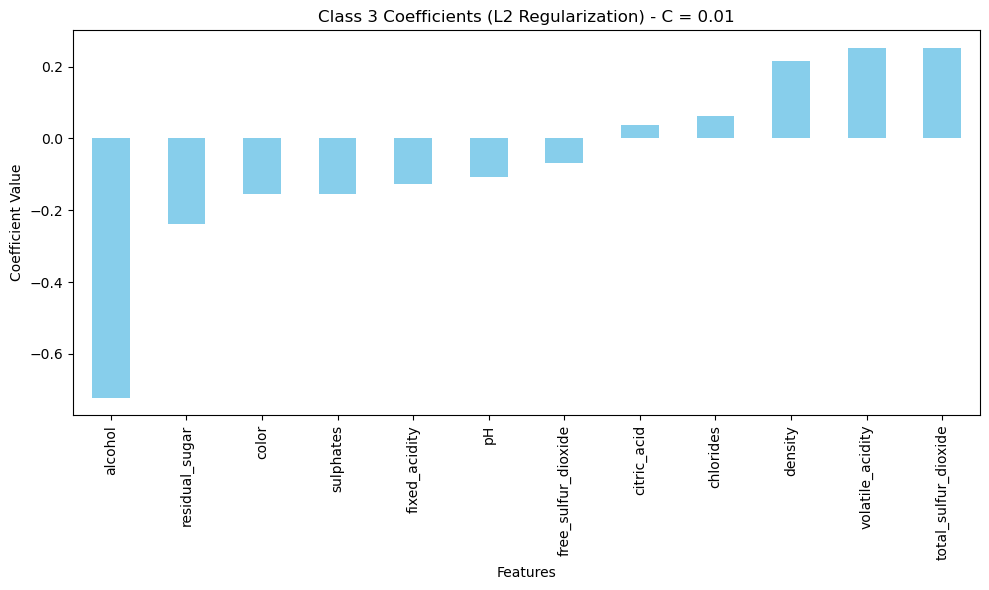

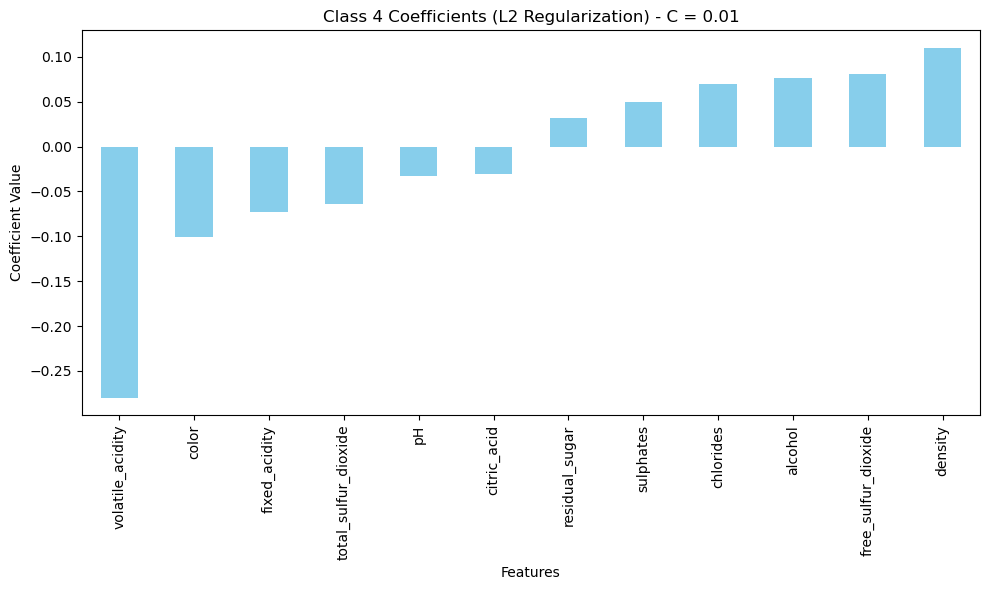

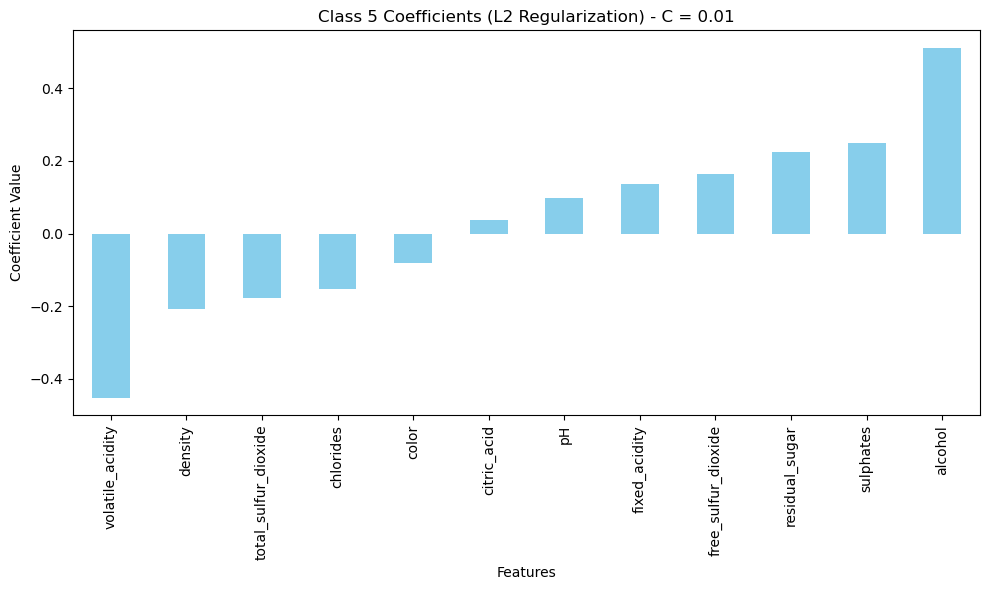

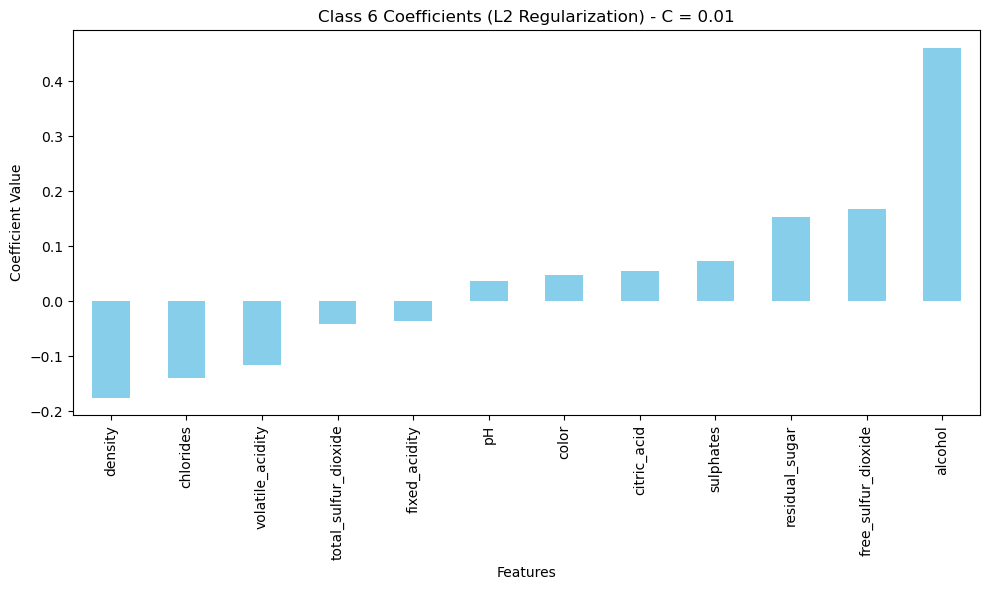

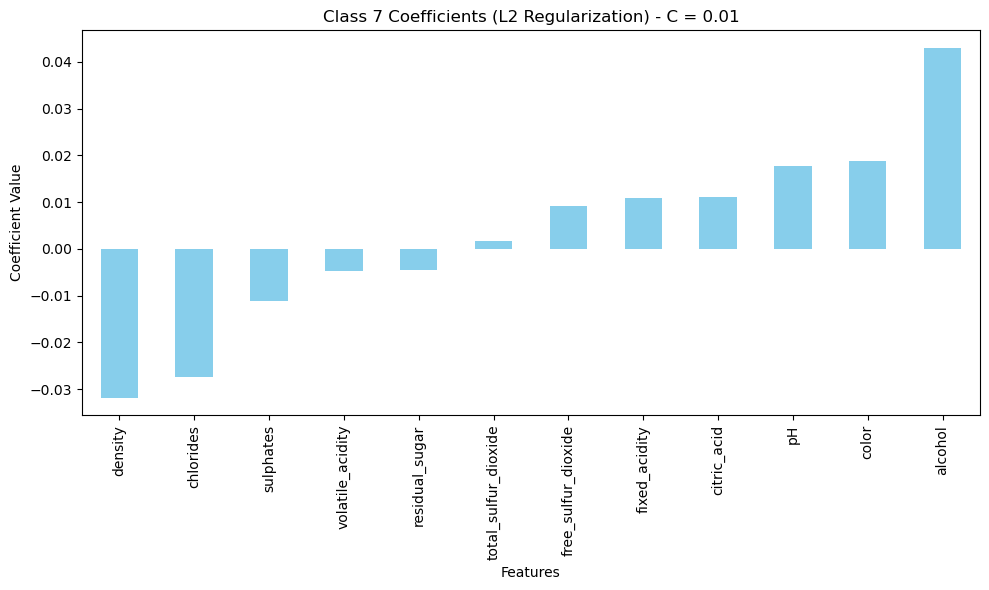

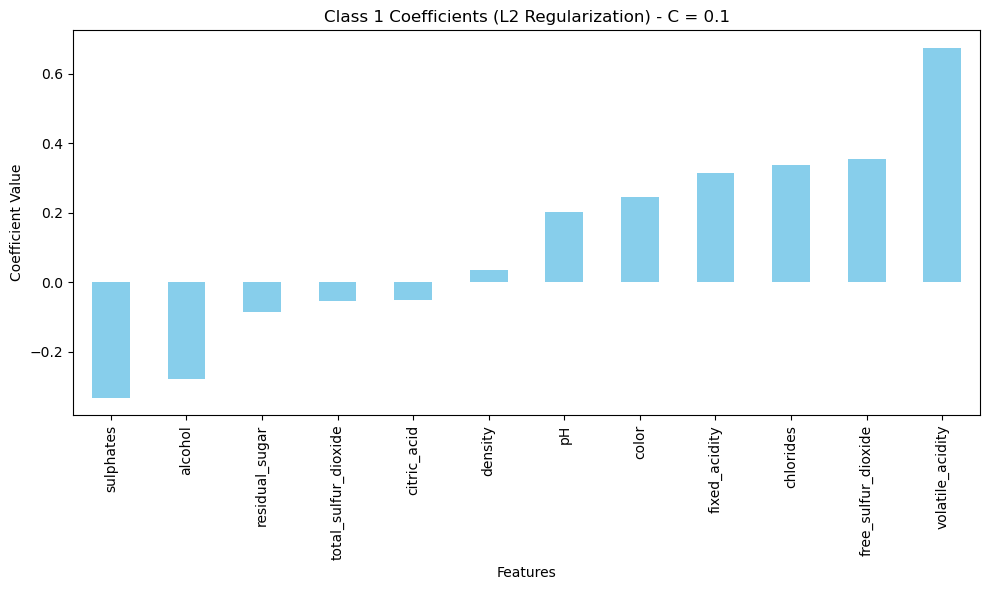

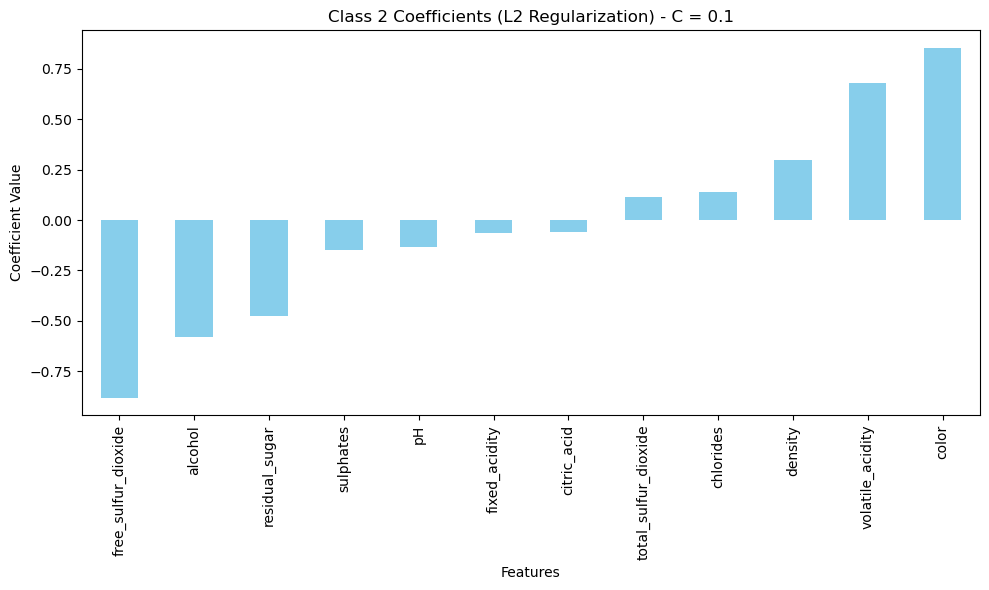

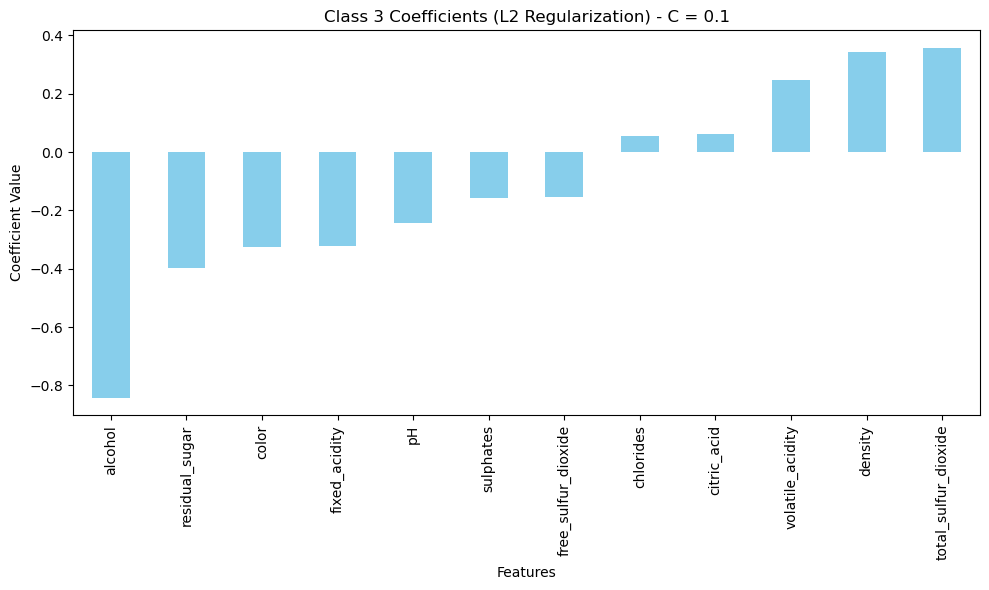

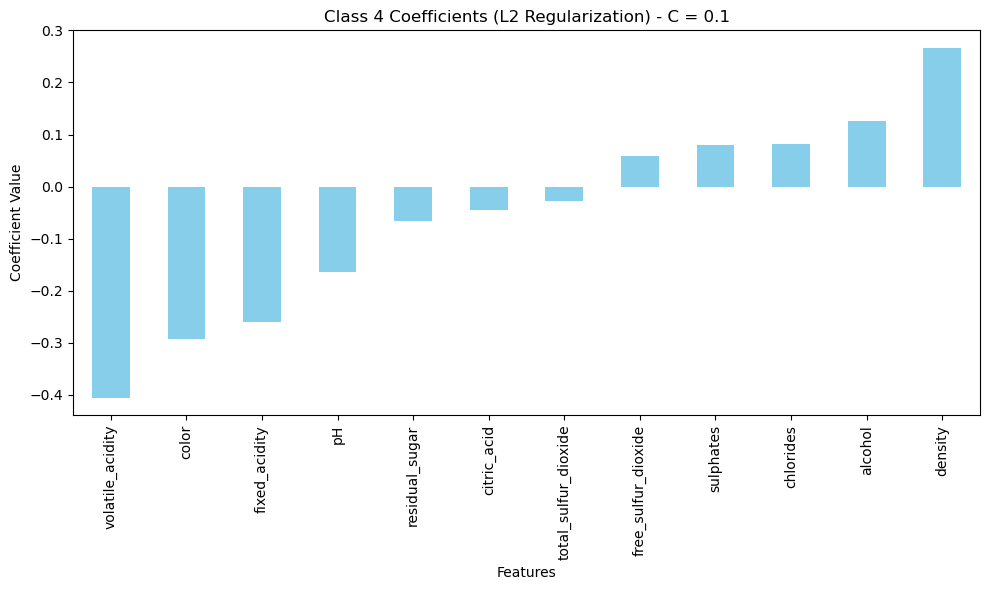

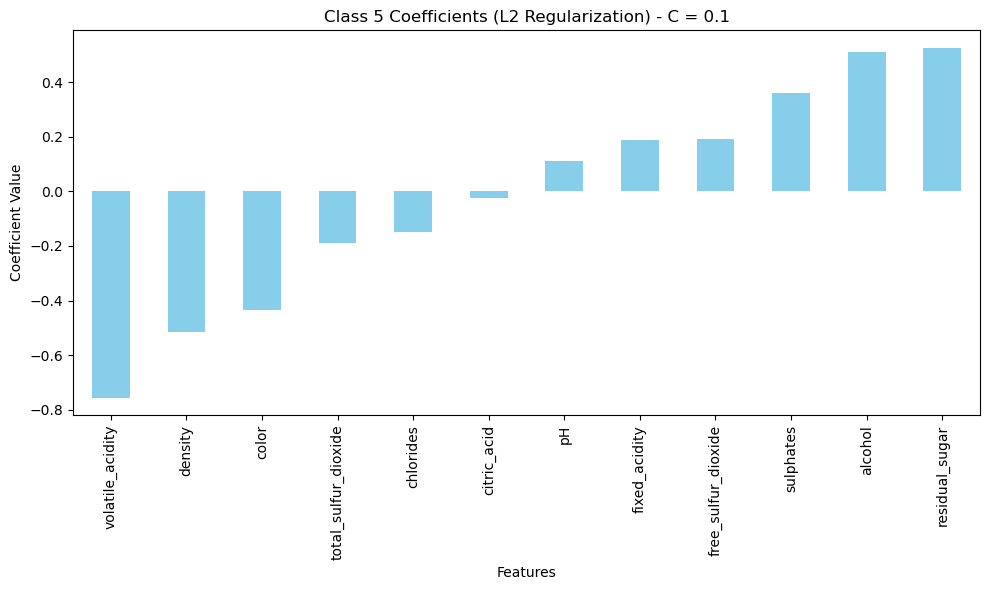

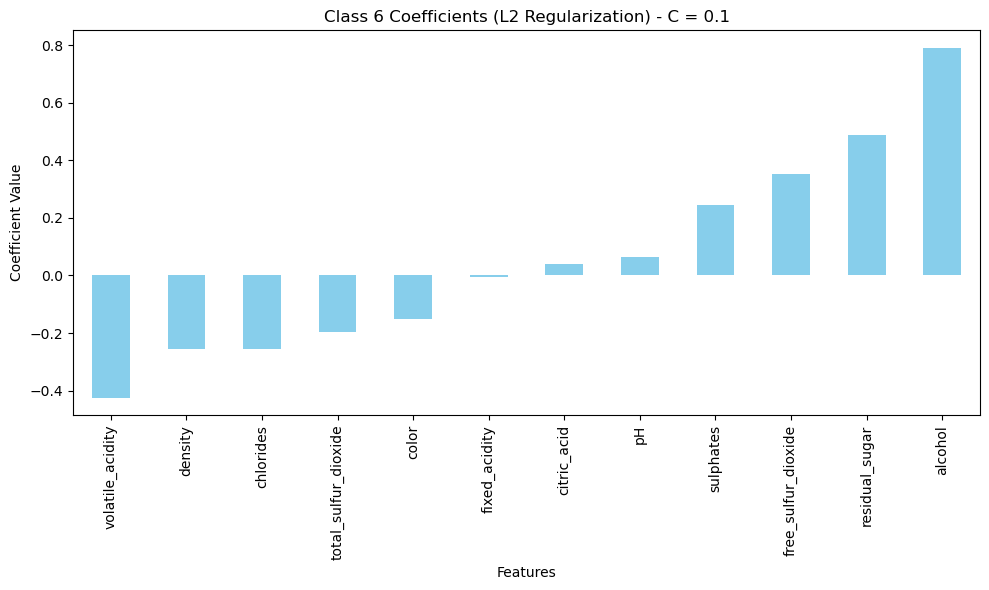

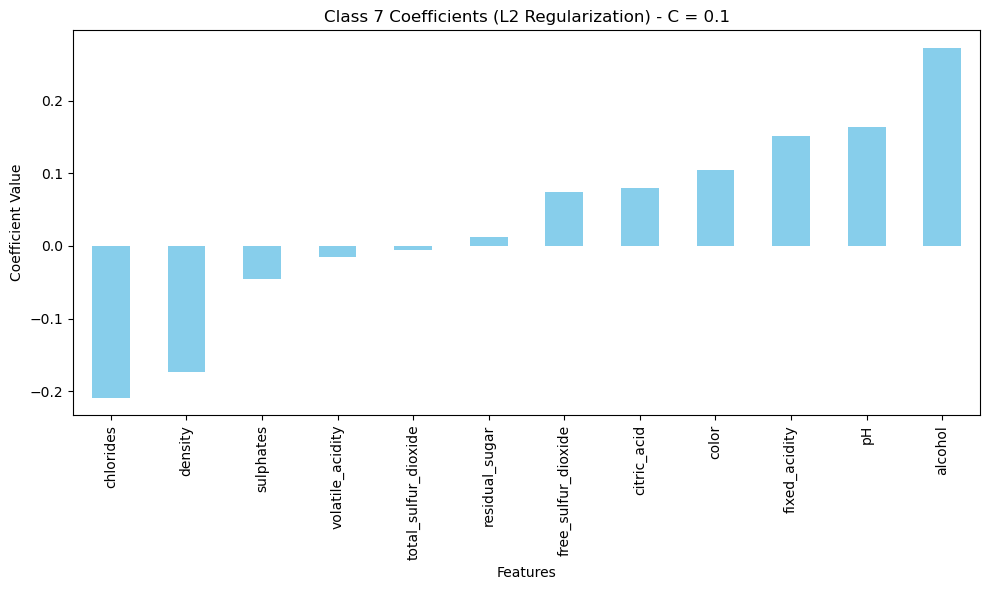

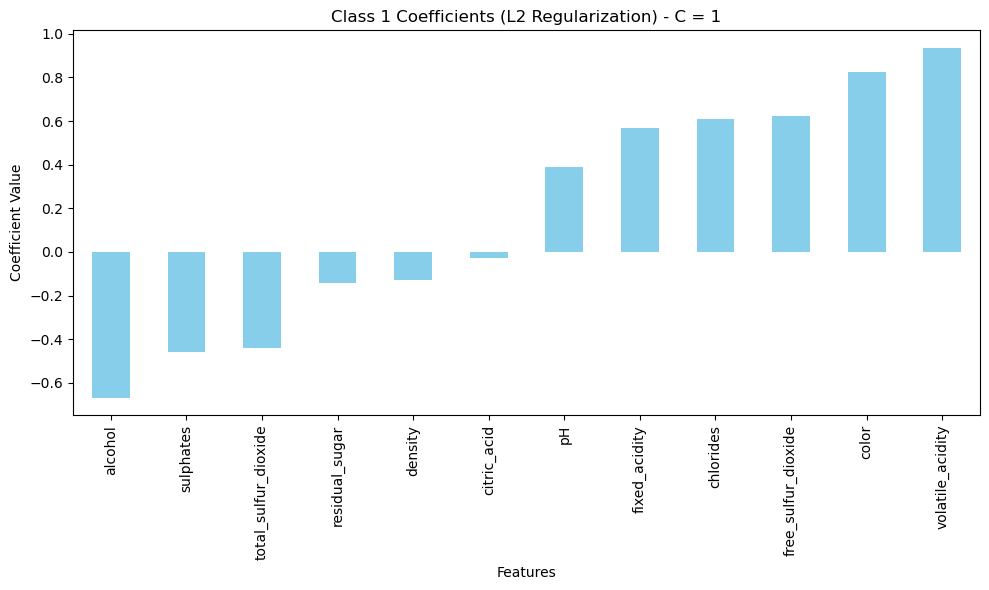

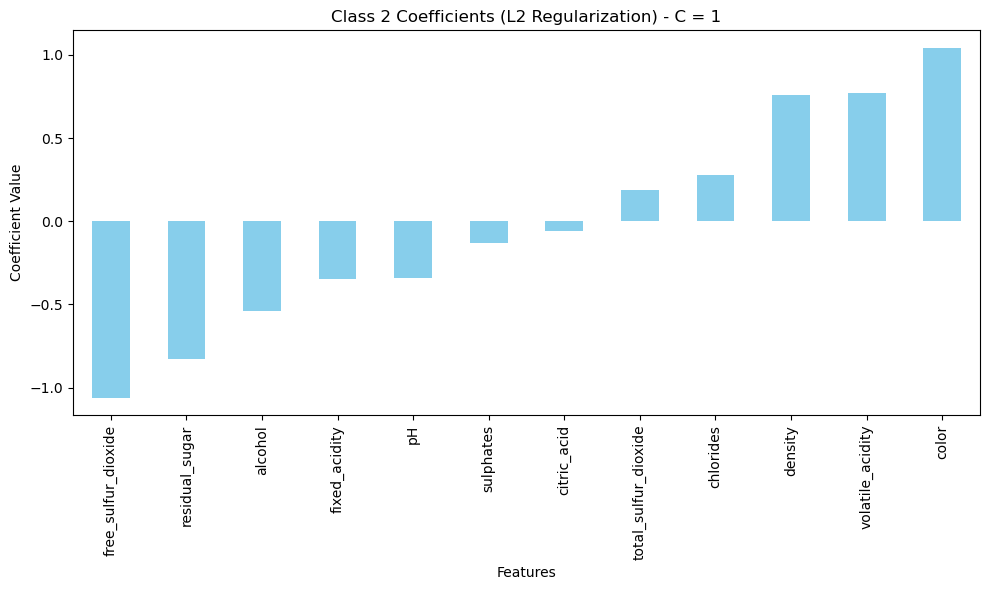

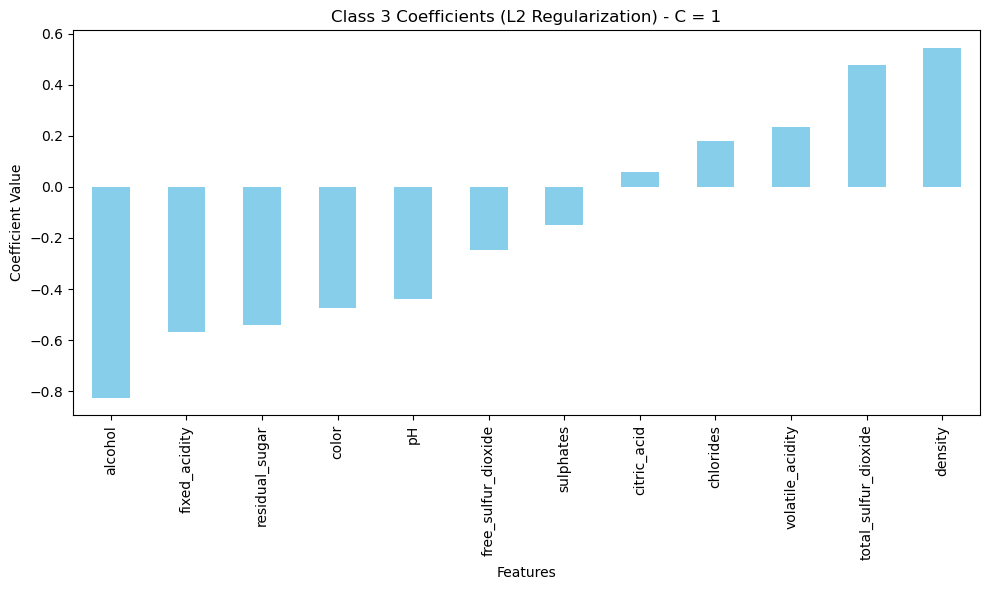

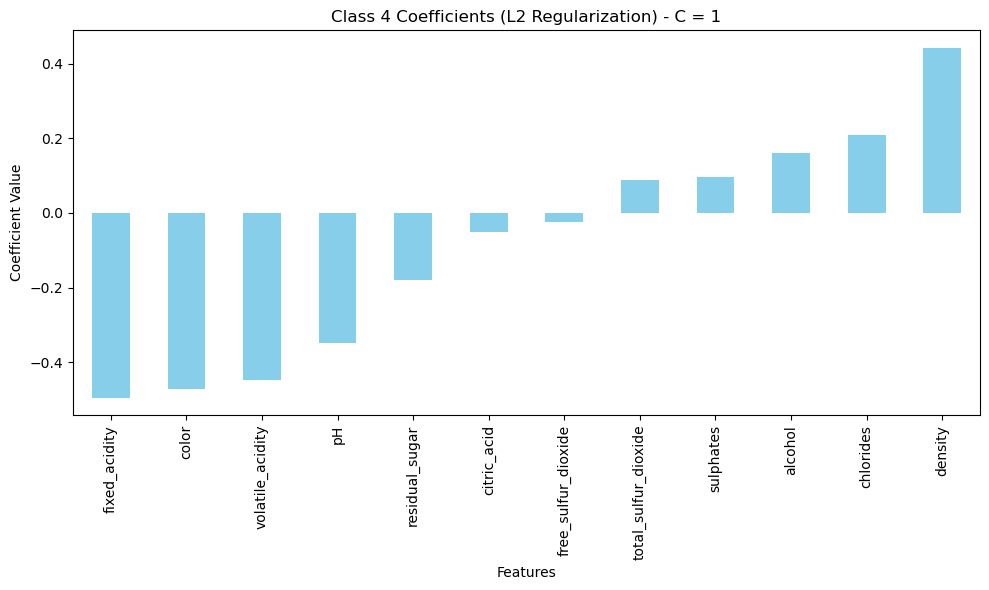

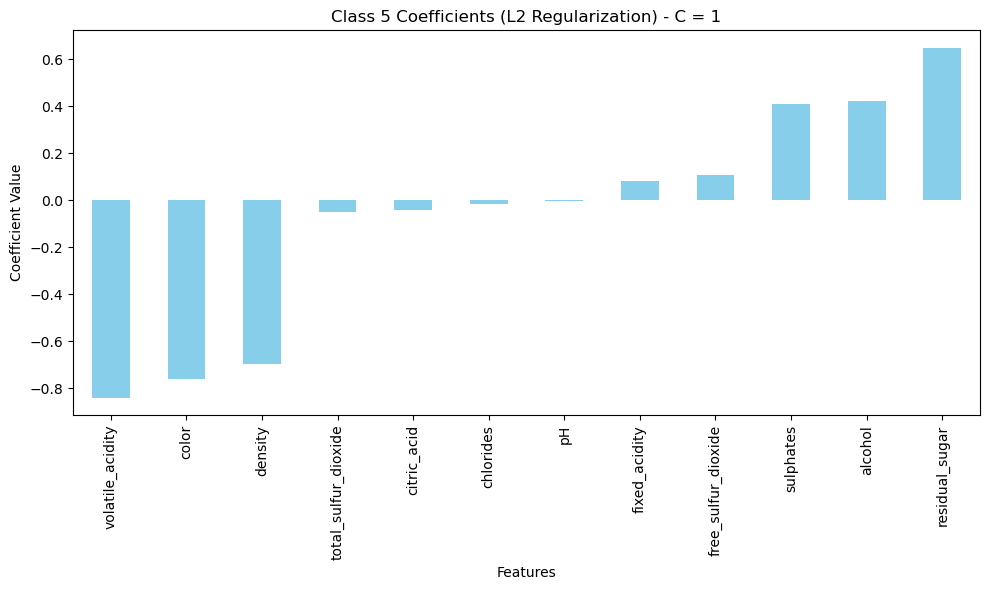

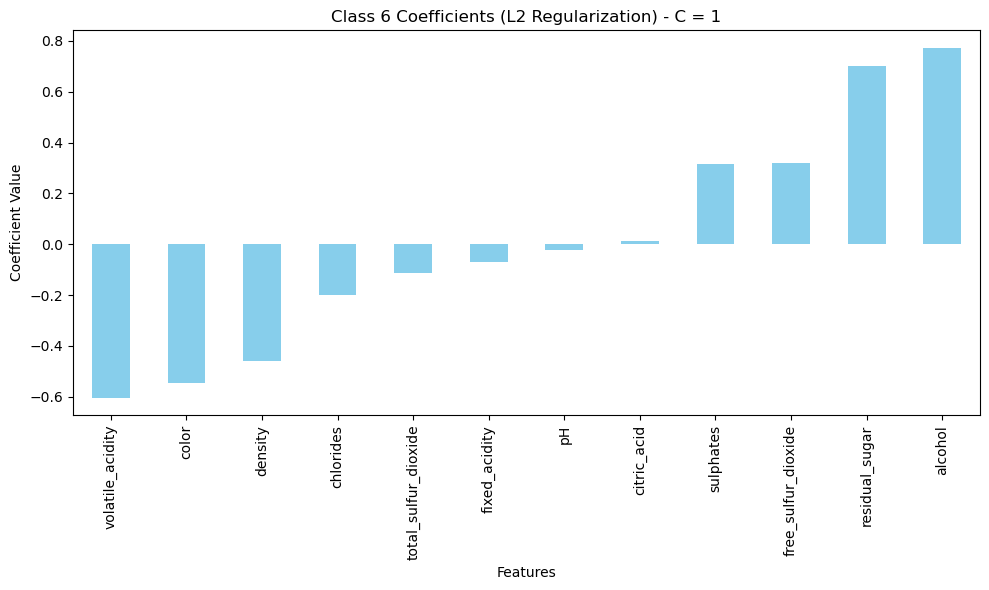

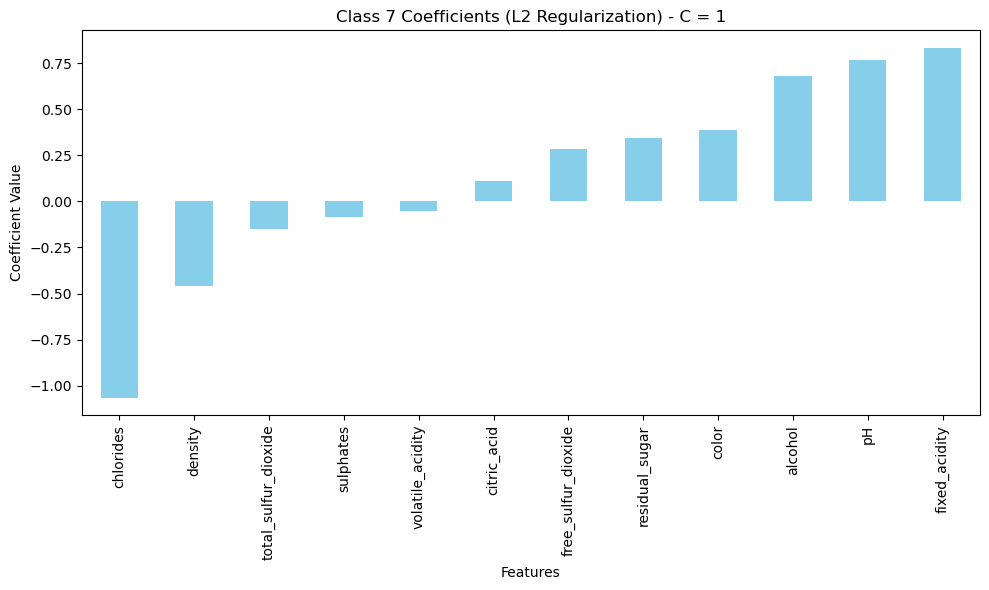

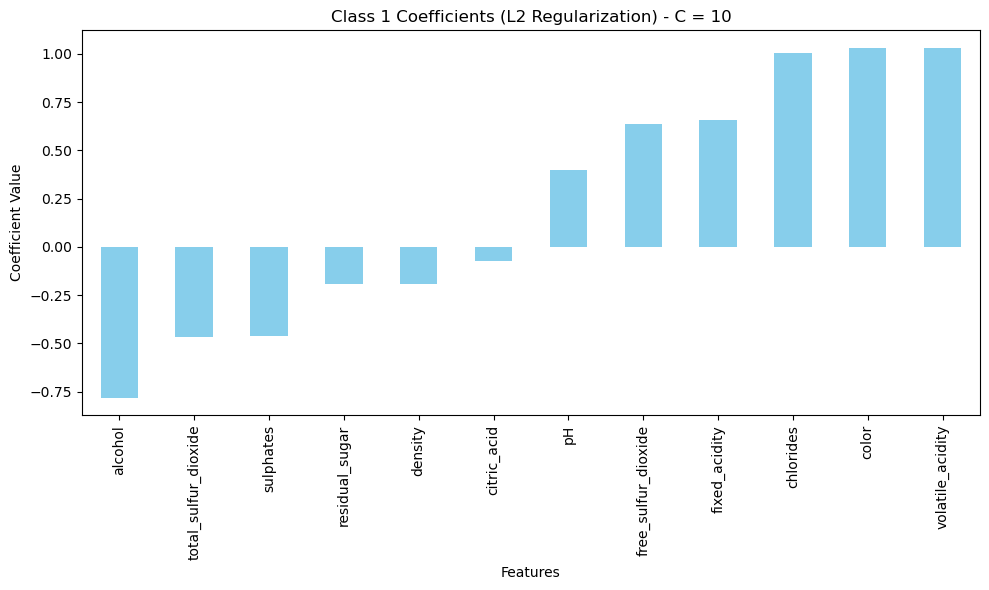

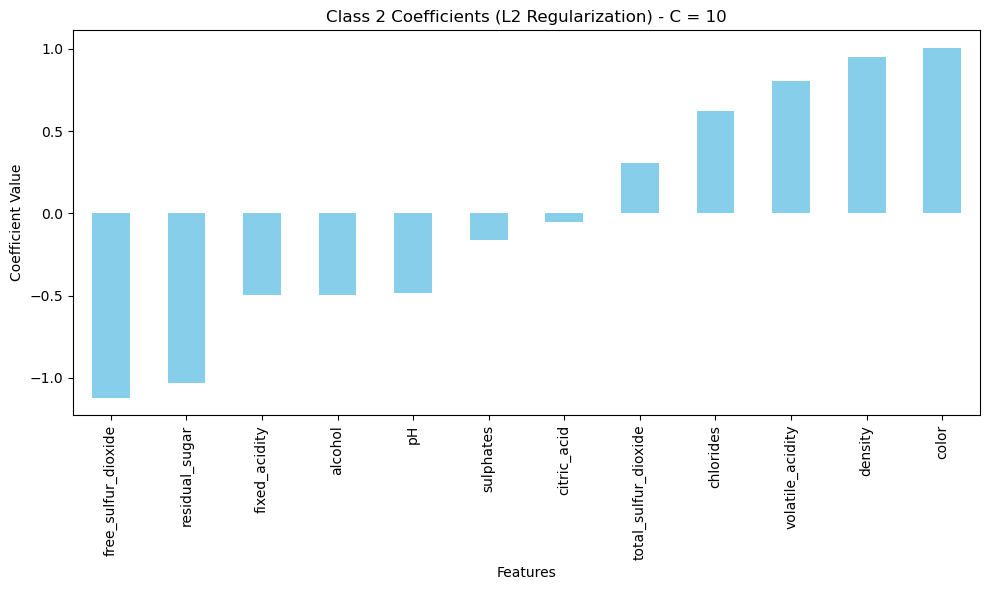

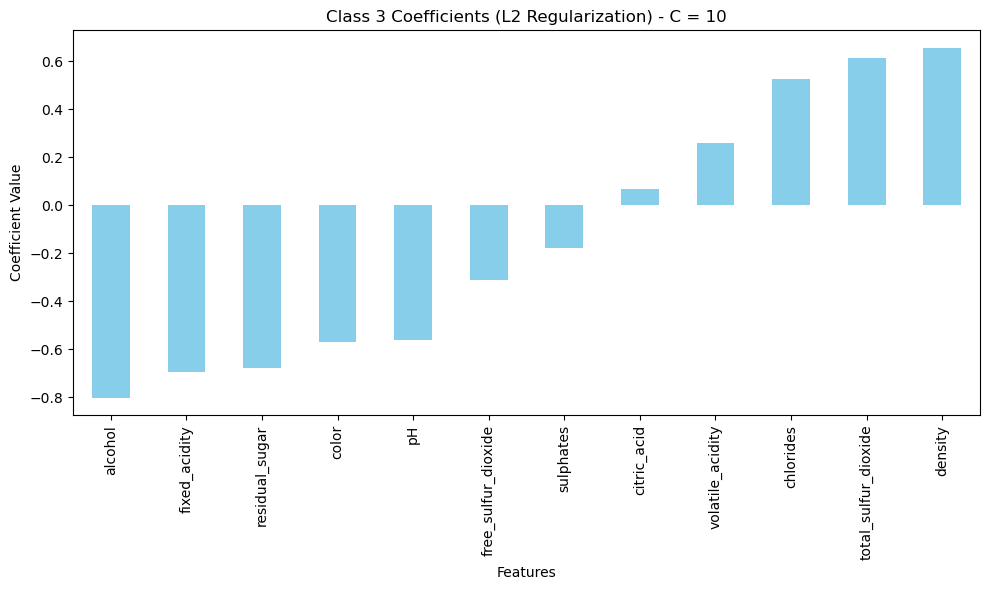

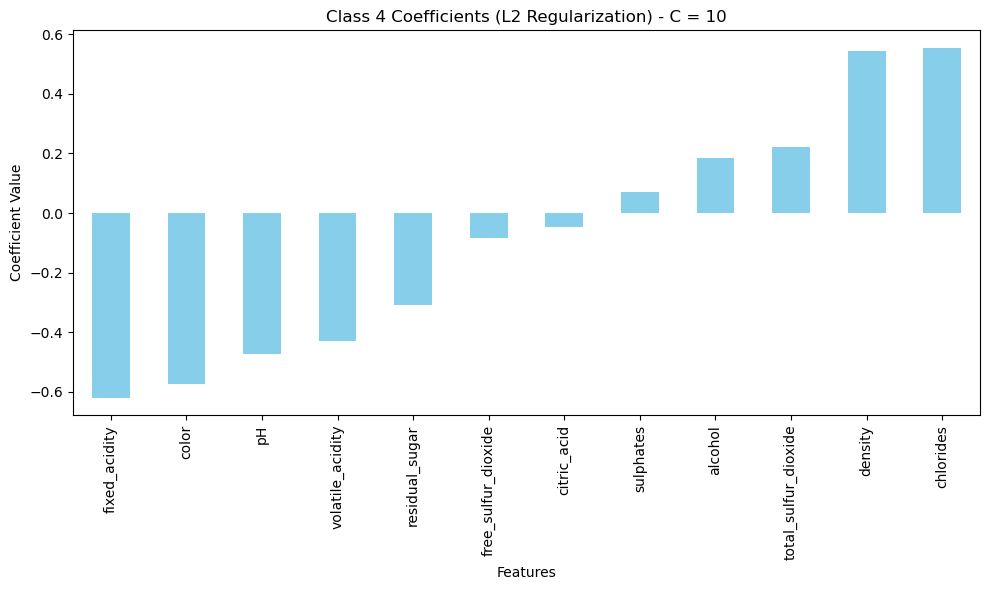

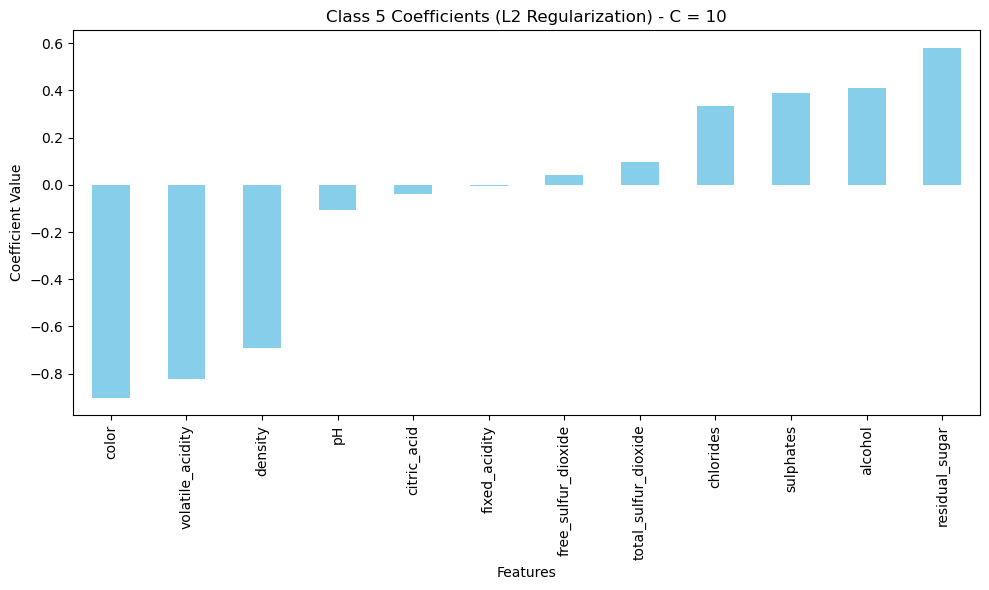

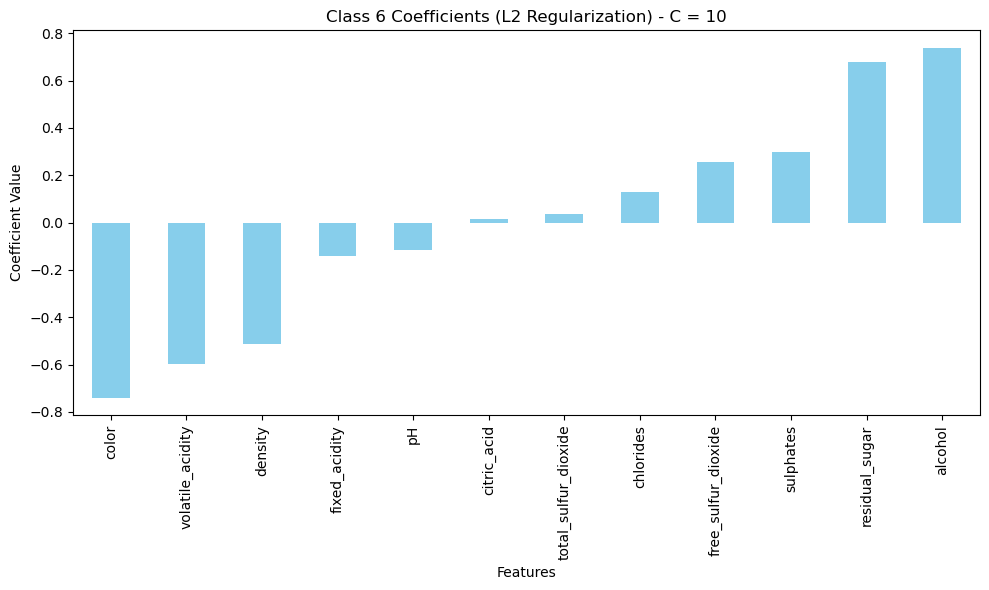

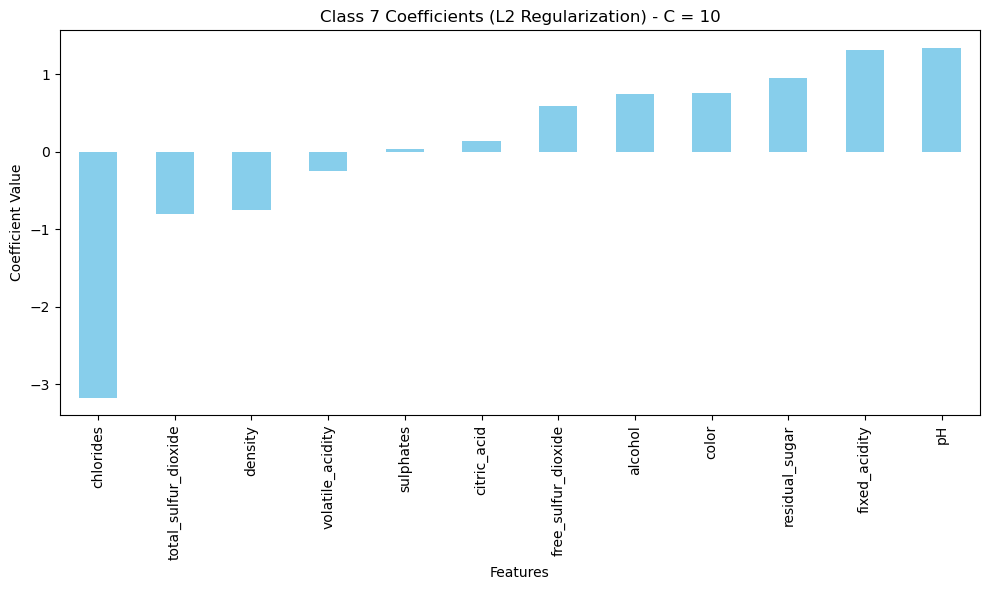

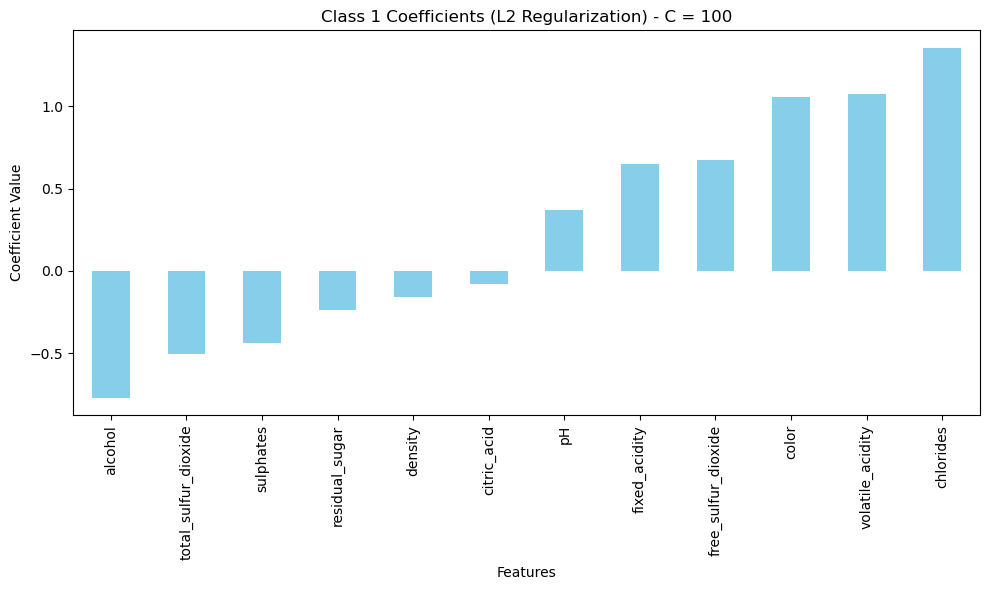

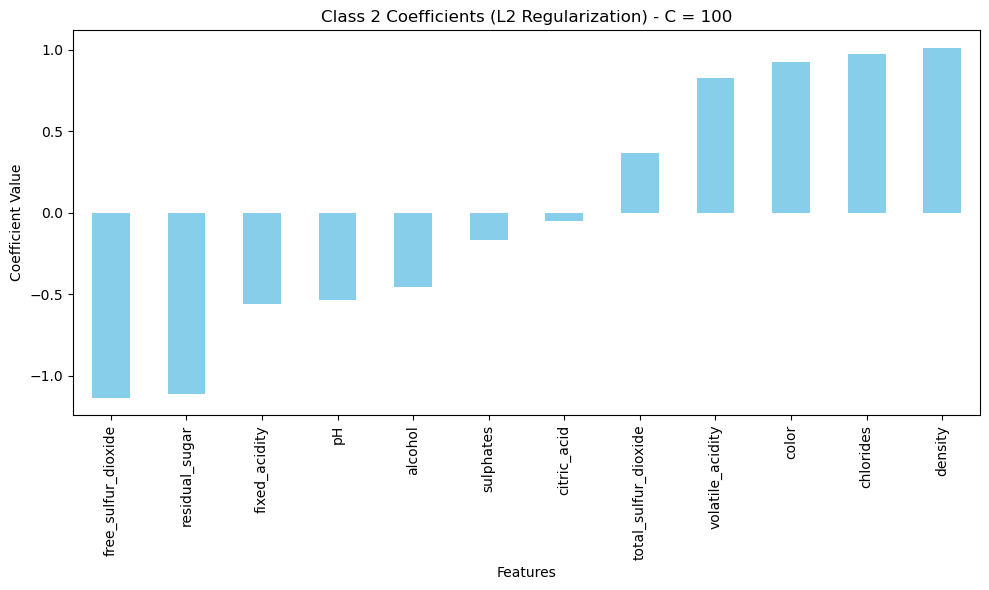

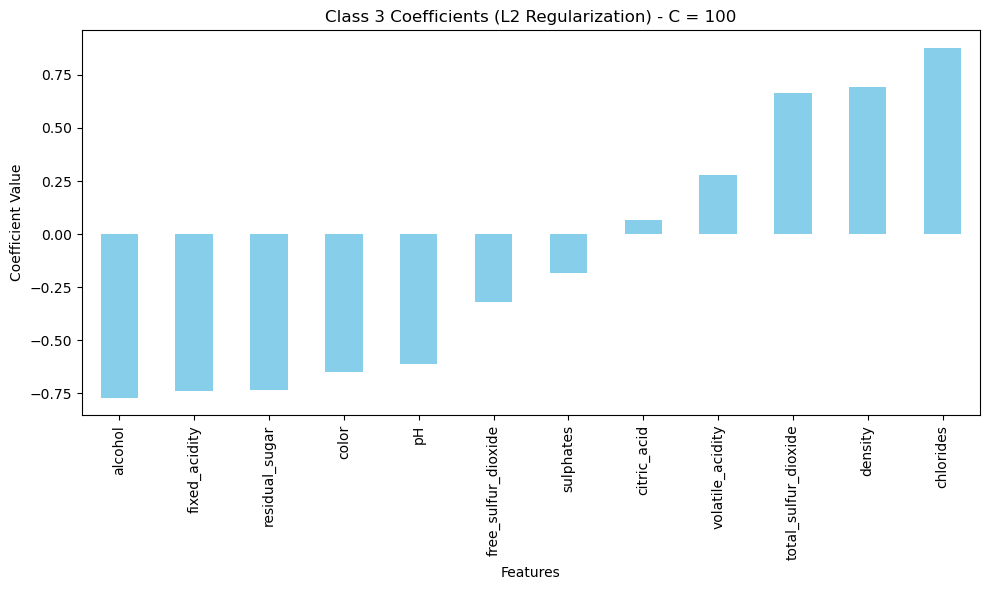

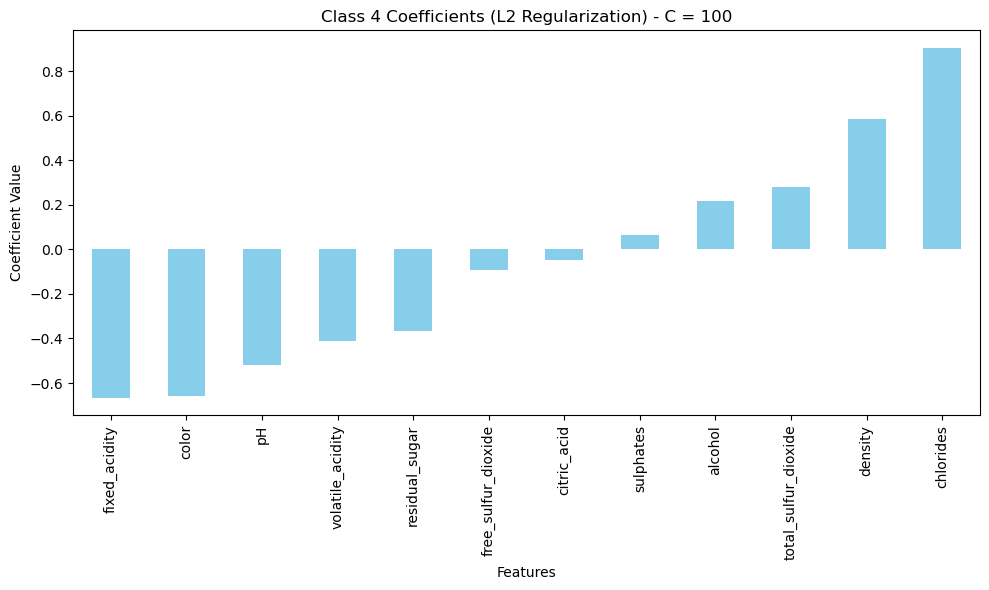

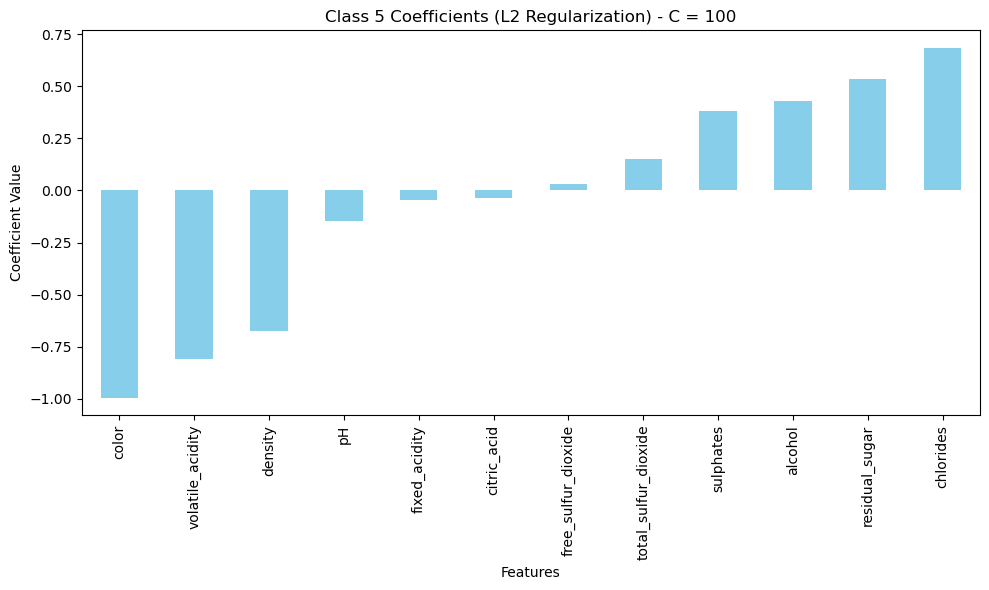

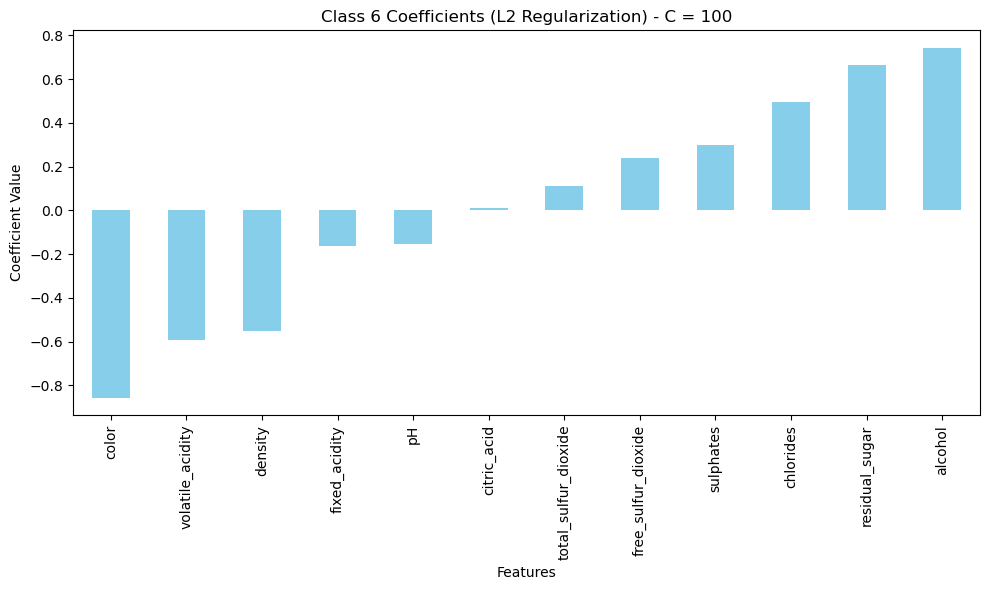

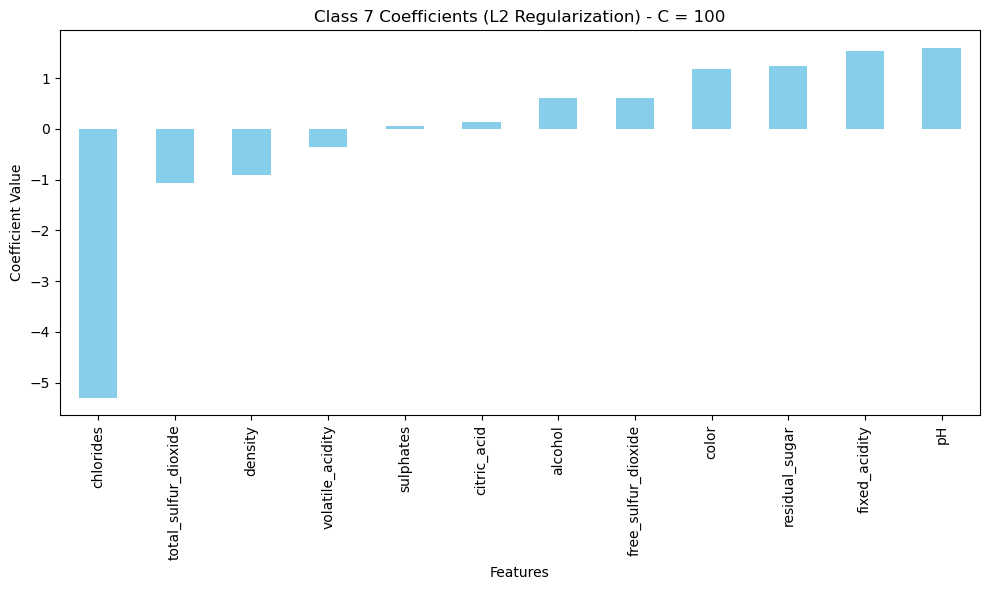

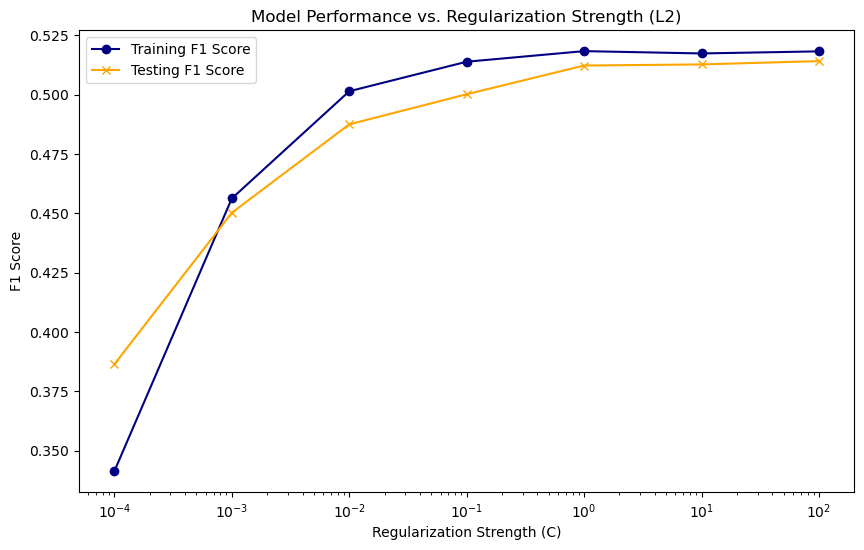

In [63]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning

# Suppress specific warnings if needed
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Step 1: Encoding 'color' Feature
label_encoder = LabelEncoder()
features['color'] = label_encoder.fit_transform(features['color'])

# Step 2: Standardizing Features
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: L2 Regularization Analysis
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Different levels of regularization
train_scores = []
test_scores = []
coef_values = []

# Iterate through each value of C and train the model
for C in C_values:
    clf = LogisticRegression(C=C, penalty='l2', max_iter=10000)
    clf.fit(X_train, y_train)
    
    # Store F1 Scores for Training and Testing
    train_scores.append(f1_score(y_train, clf.predict(X_train), average='weighted'))
    test_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
    
    # Store Coefficients for Visualization
    coef_values.append(clf.coef_)

# Step 5: Visualize Coefficients for Different L2 Strengths
predictors = features.columns

for idx, coef in enumerate(coef_values):
    for class_idx in range(coef.shape[0]):
        coef_series = pd.Series(coef[class_idx], index=predictors).sort_values()
        plt.figure(figsize=(10, 6))
        coef_series.plot(kind='bar', color='skyblue')
        plt.title(f'Class {class_idx + 1} Coefficients (L2 Regularization) - C = {C_values[idx]}')
        plt.xlabel("Features")
        plt.ylabel("Coefficient Value")
        plt.tight_layout()
        plt.show()

# Step 6: Plot Performance Metrics vs. Regularization Strength
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_scores, marker='o', label='Training F1 Score', color='navy')
plt.plot(C_values, test_scores, marker='x', label='Testing F1 Score', color='orange')
plt.xscale('log')  # Log scale to better visualize changes
plt.xlabel('Regularization Strength (C)')
plt.ylabel('F1 Score')
plt.title('Model Performance vs. Regularization Strength (L2)')
plt.legend()
plt.show()


Conclusion:

This project provides a detailed analysis of logistic regression with an emphasis on the effects of L2 regularization. Our findings reveal that while the unregularized model can perform well on the training set, it often overfits, leading to suboptimal performance on unseen data. Introducing L2 regularization mitigates overfitting by penalizing large coefficients, enhancing the model's generalization capabilities.

The analysis also highlights the delicate balance between underfitting and overfitting as we adjust the regularization strength (C). Lower values of C lead to higher penalties on the coefficients, reducing the model's flexibility but improving stability. Conversely, higher values of C allow more complex models at the risk of capturing noise.

Our comprehensive visualizations of model coefficients demonstrate the regularization effect, showing how L2 constraints reduce the influence of less important features. This project underscores the importance of careful hyperparameter tuning in developing robust and interpretable models, providing valuable insights for data scientists and practitioners.

We found that features such as alcohol content and residual sugar are consistently influential across different regularization strengths.

Introducing L2 regularization effectively controlled overfitting, leading to more robust models that generalize well on unseen data. The optimal balance between model complexity and performance was achieved with intermediate values of C. As regularization strength increased (lower C), less influential features were shrunk, highlighting only the most impactful characteristics.

Overall, this study emphasizes the importance of feature selection and regularization in logistic regression models, offering valuable guidance for predictive modeling in the wine industry and beyond.

---

END

---

BELOW IS A REFINED VERSION OF THE ANALYSIS - ONLY CONTINUE TO SEE THE MACHINE TRAINED FURTHER

---

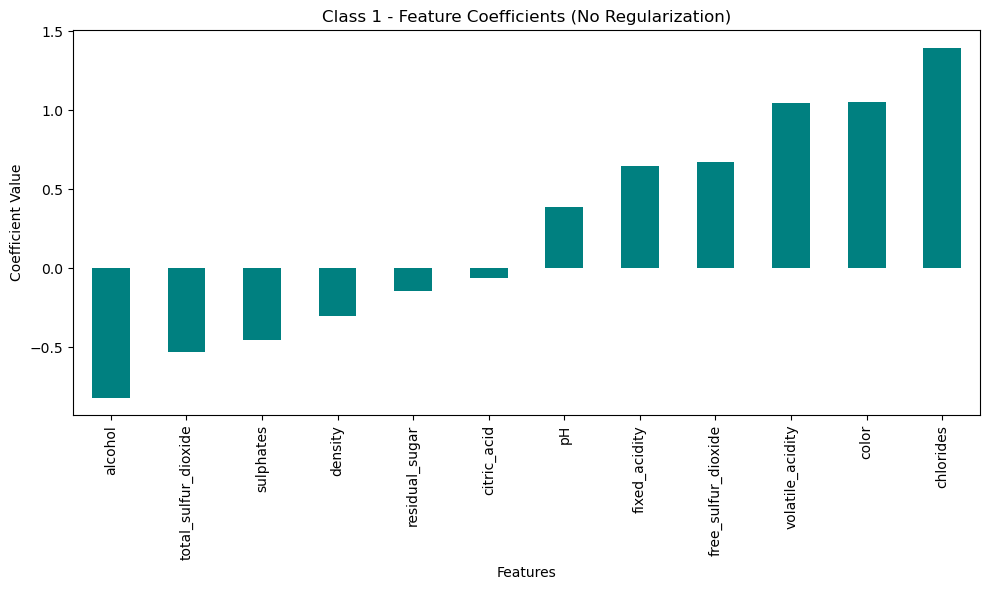

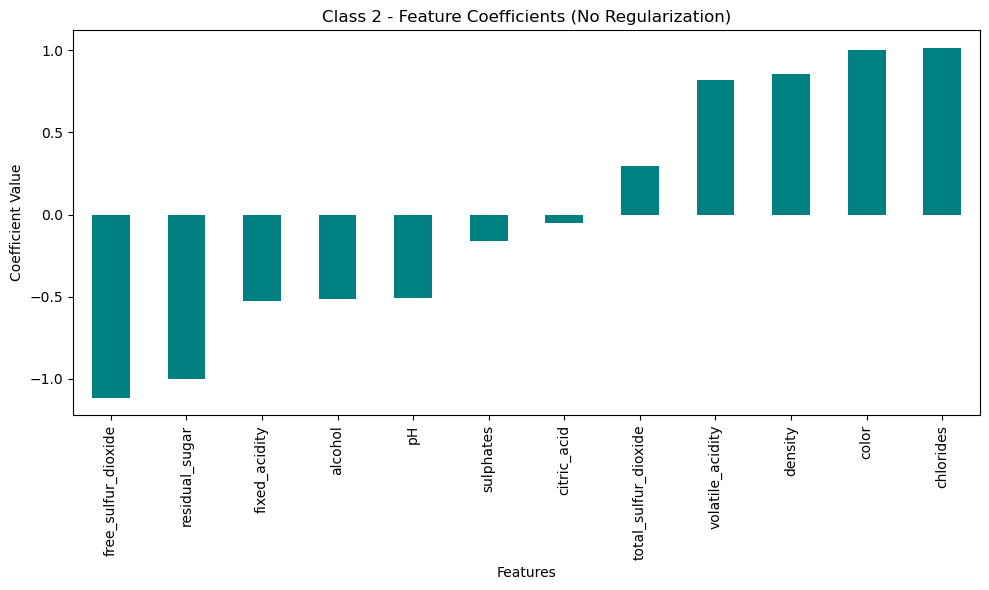

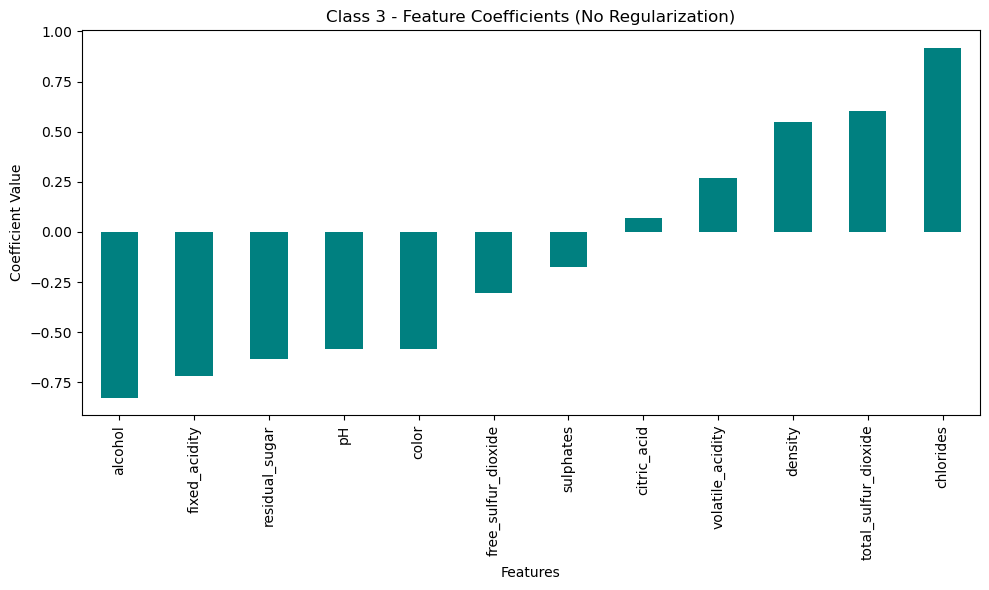

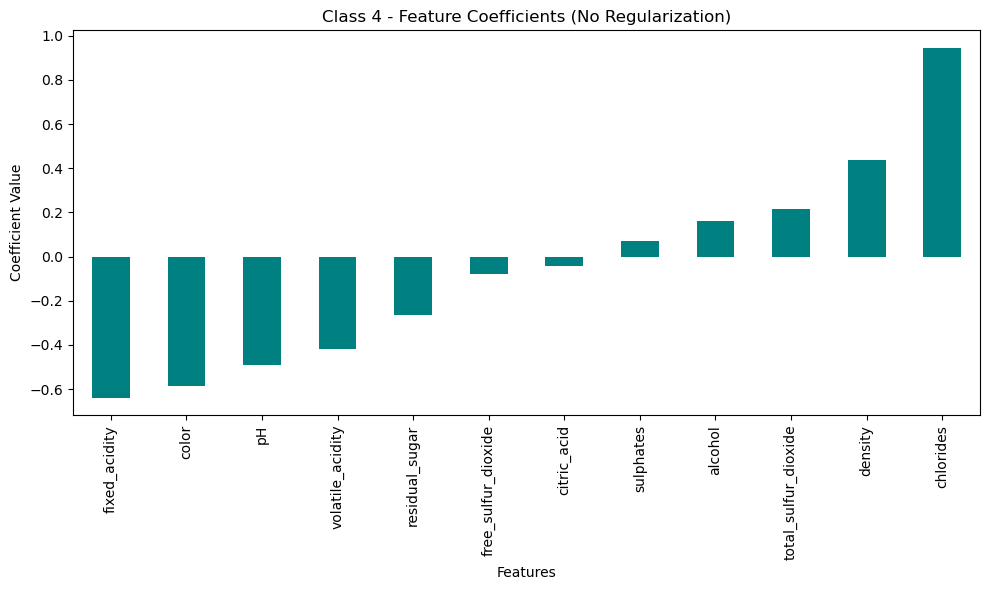

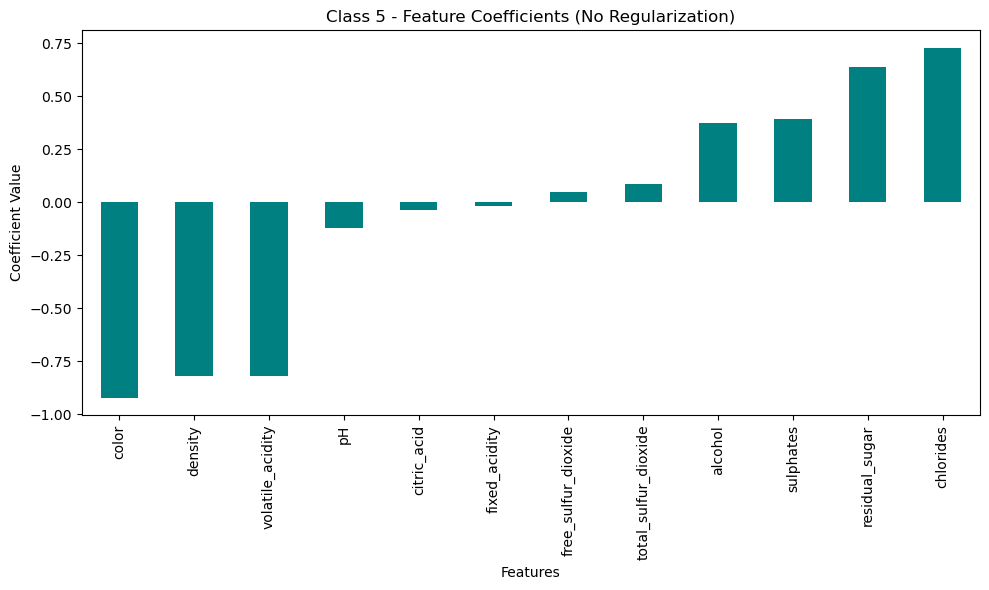

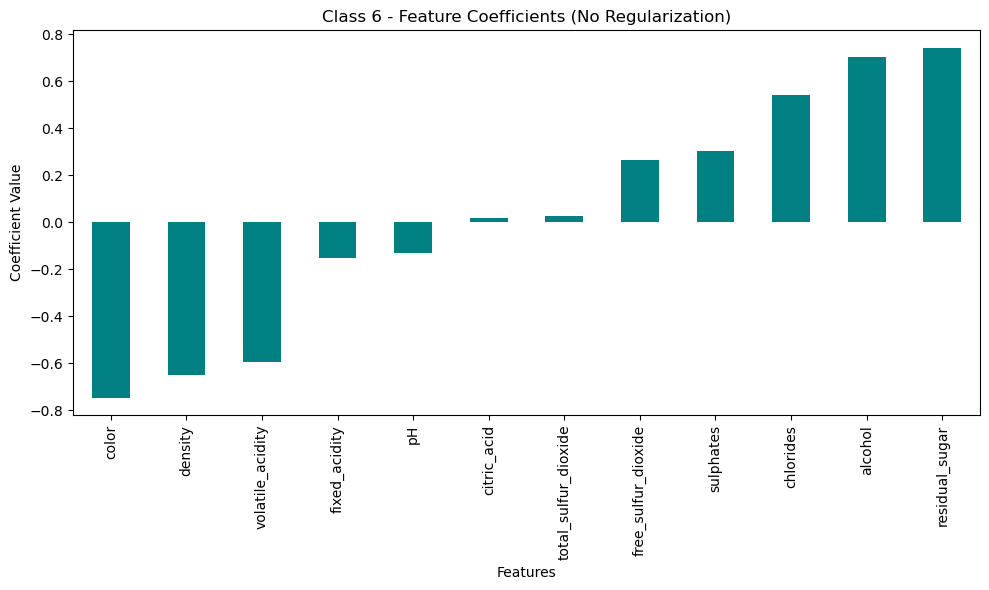

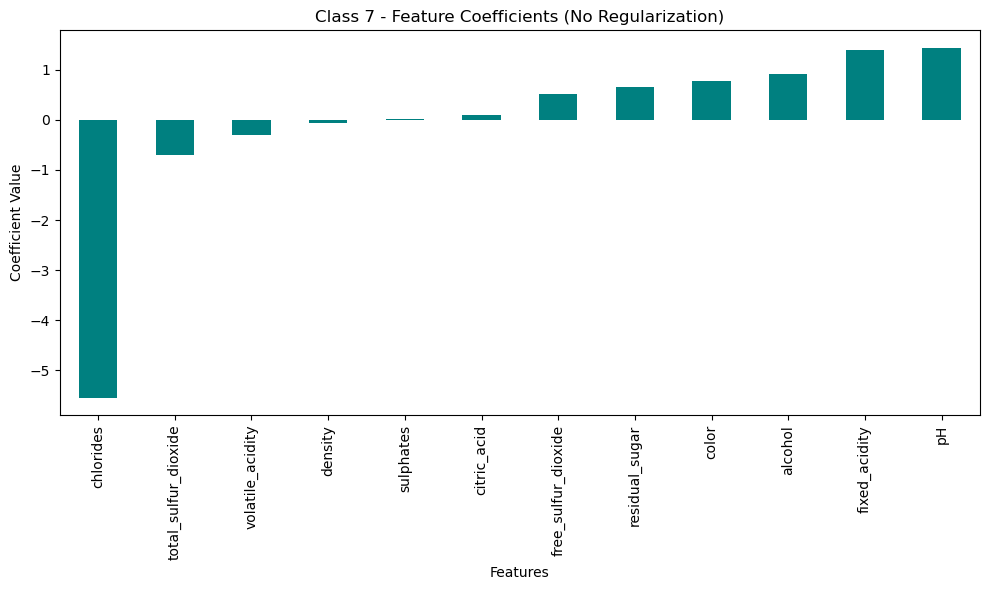

Training F1 Score (No Regularization): 0.5176
Testing F1 Score (No Regularization): 0.5135
Ridge-Regularized Training F1 Score: 0.5183
Ridge-Regularized Testing F1 Score: 0.5123


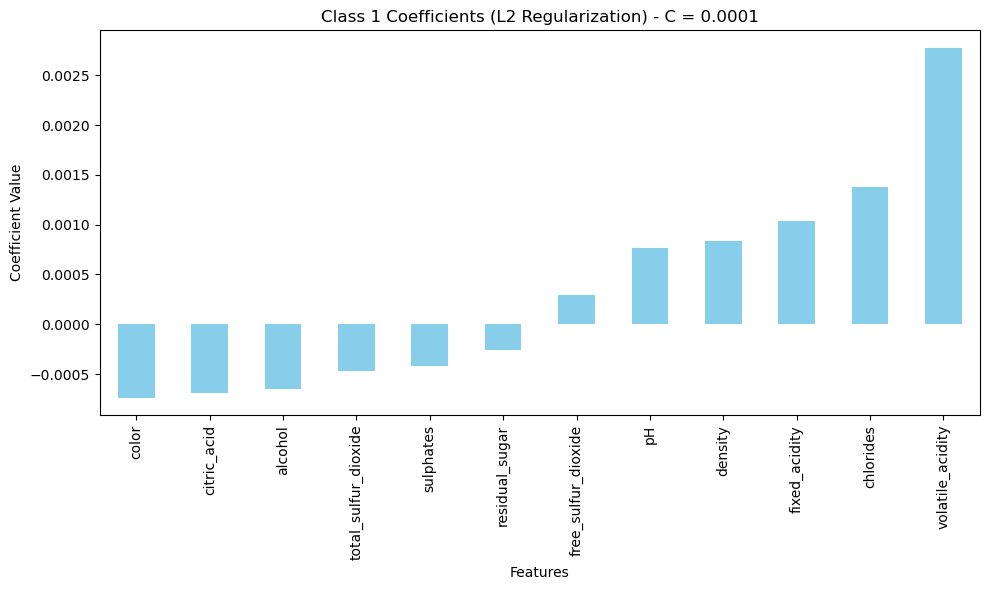

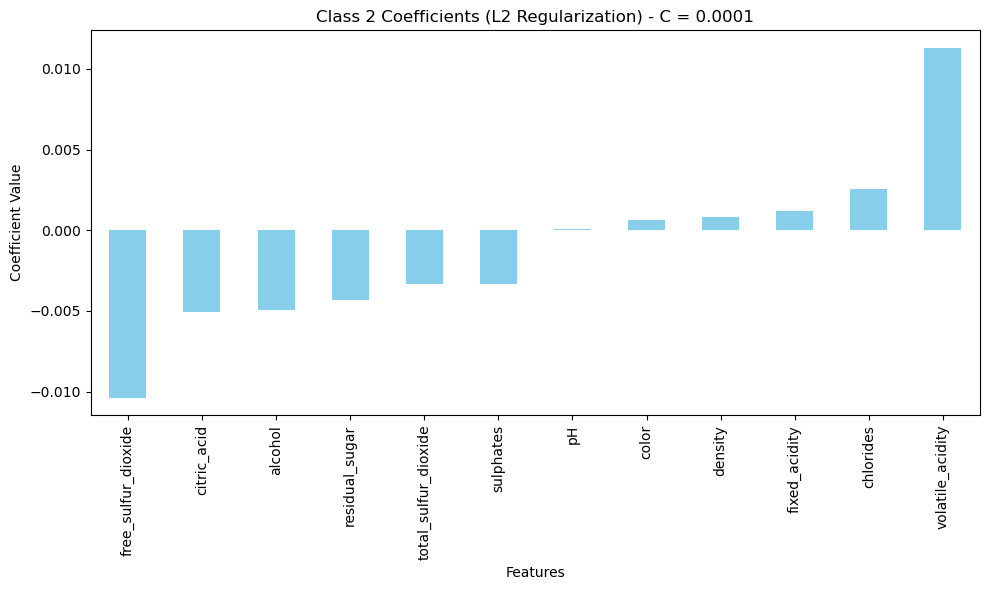

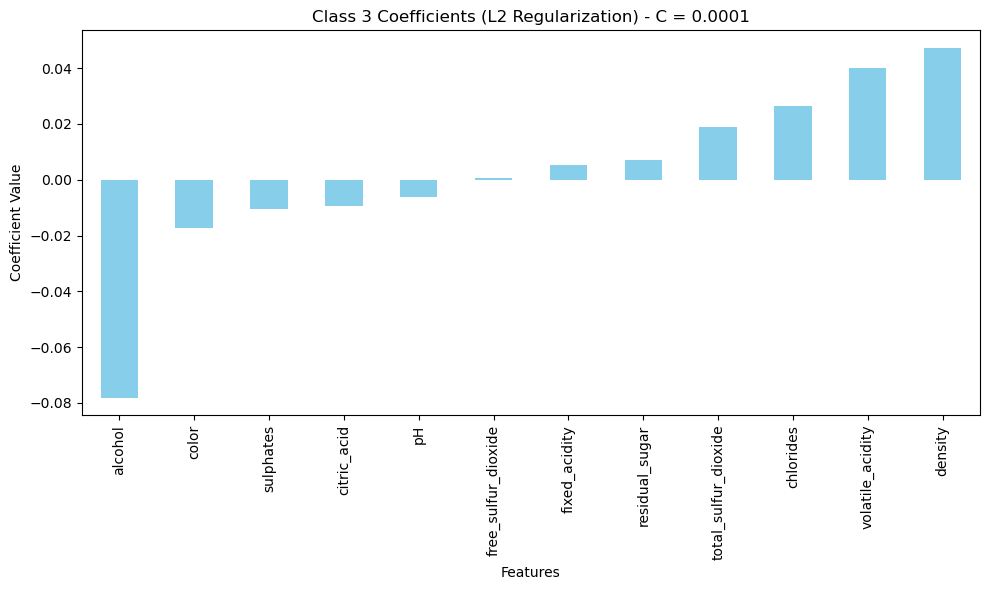

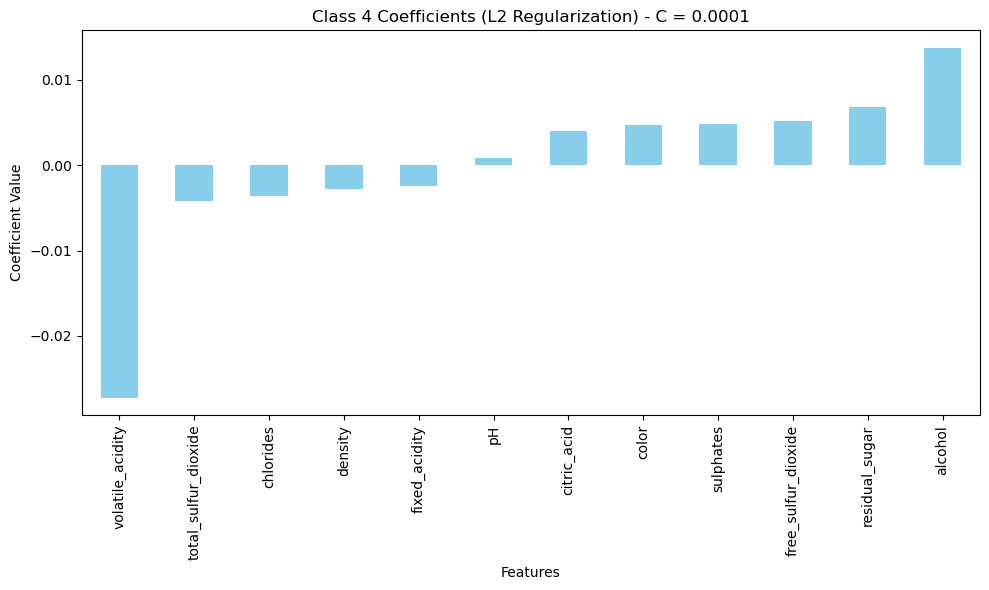

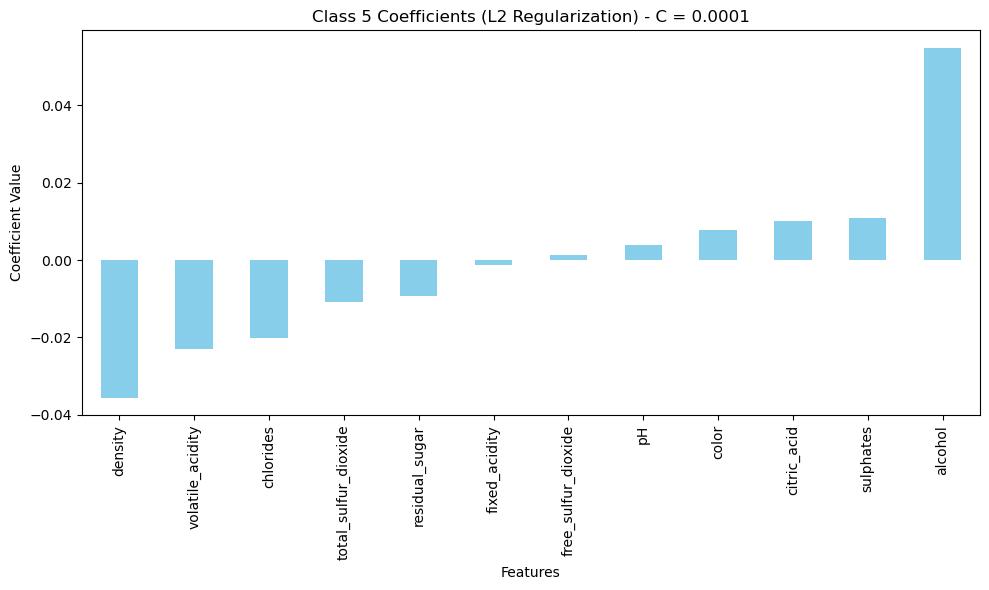

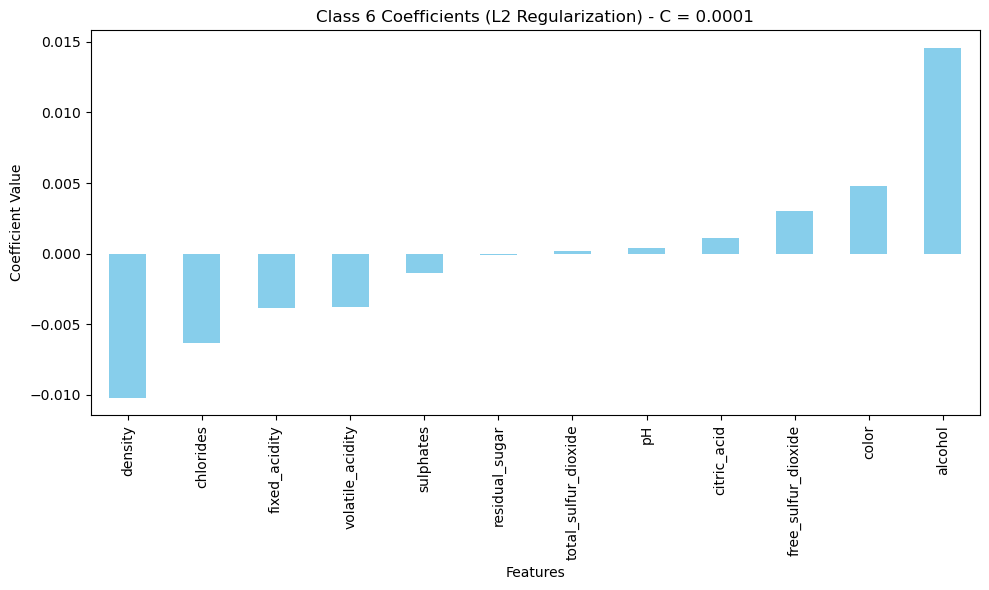

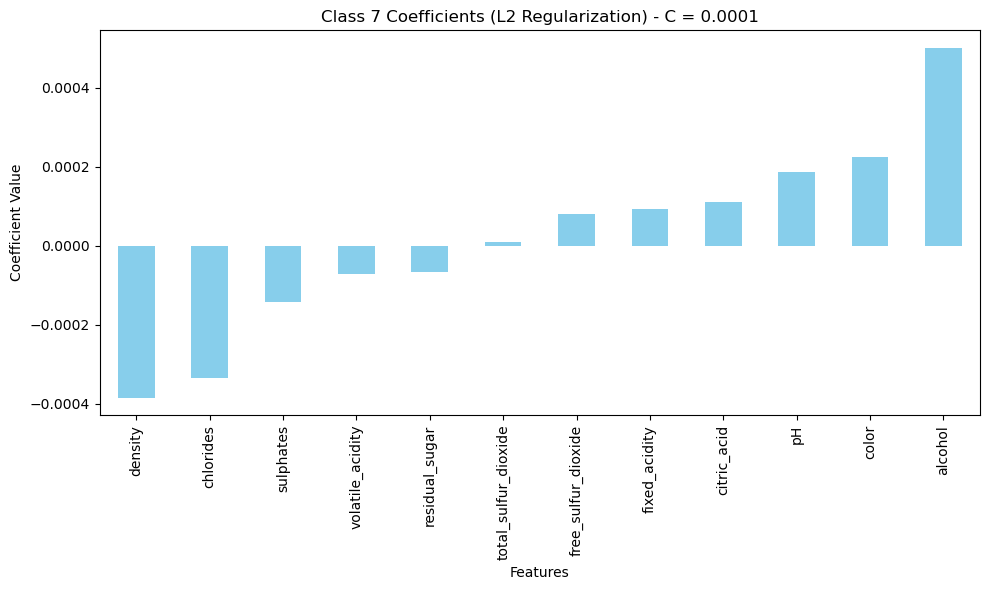

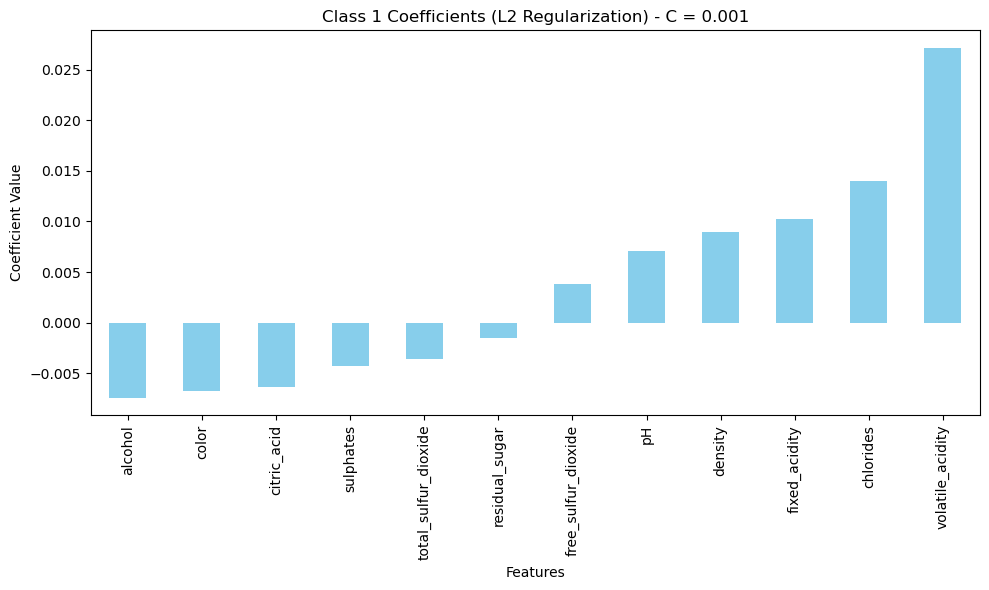

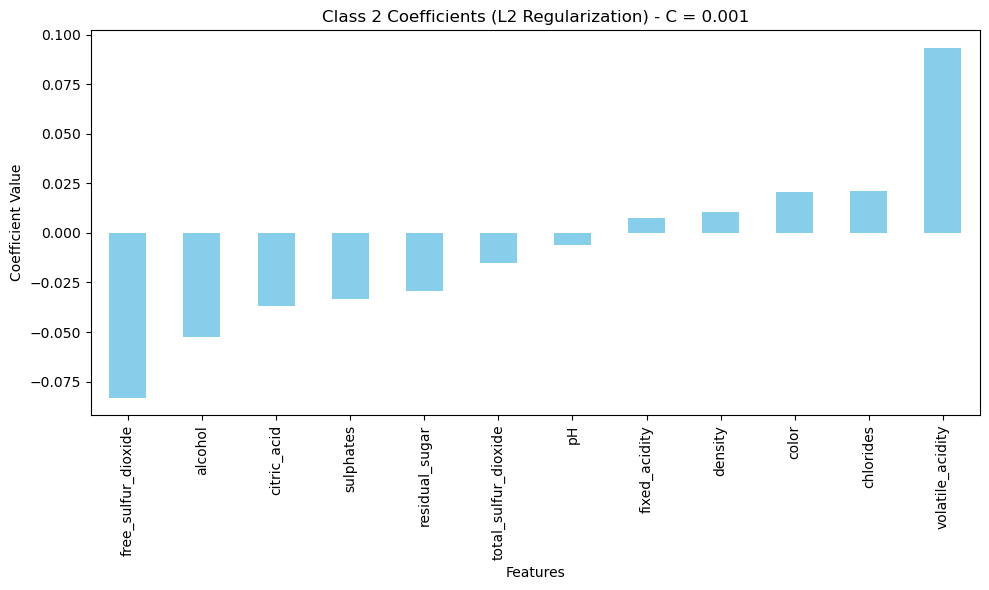

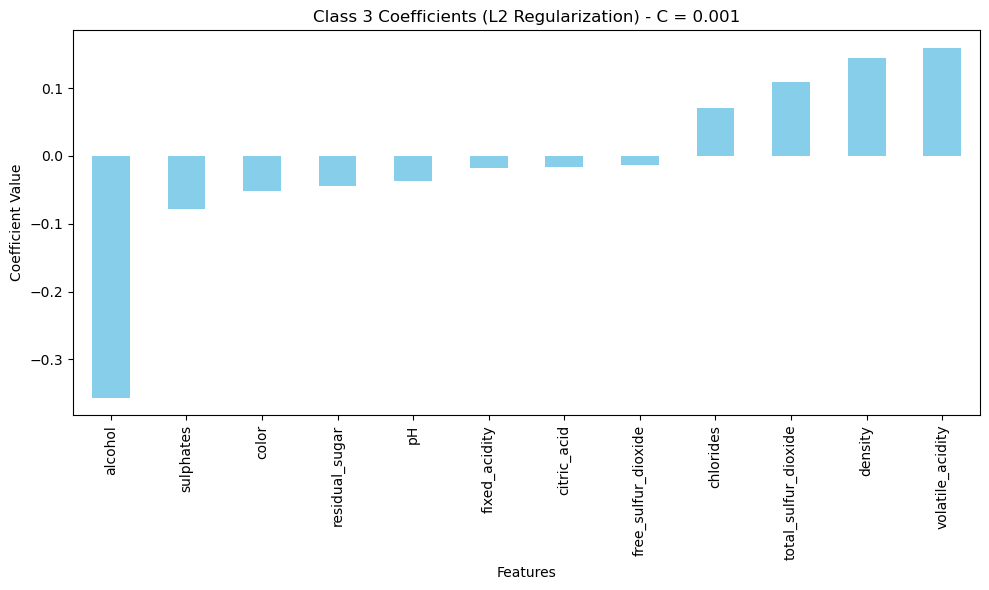

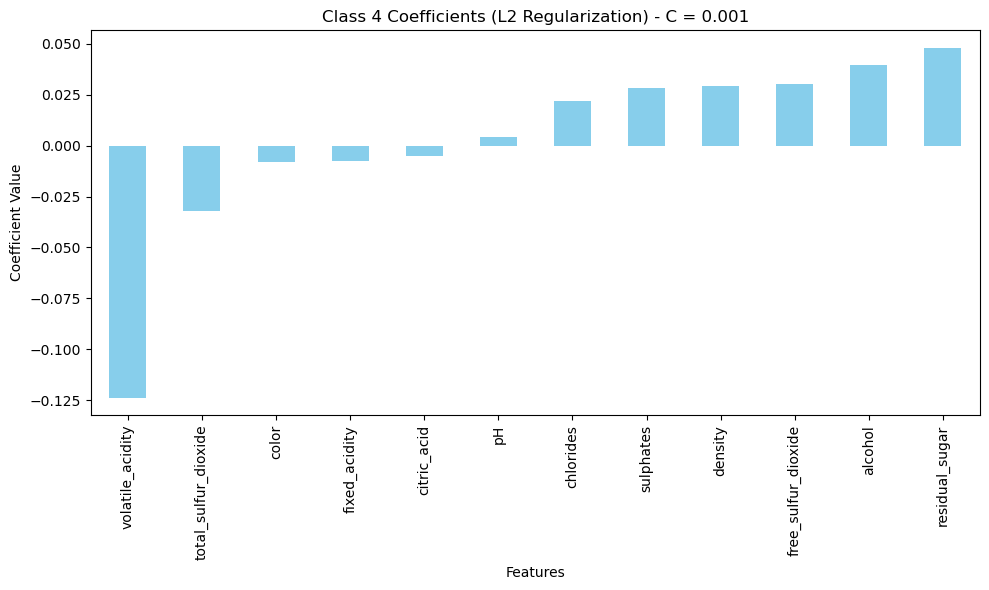

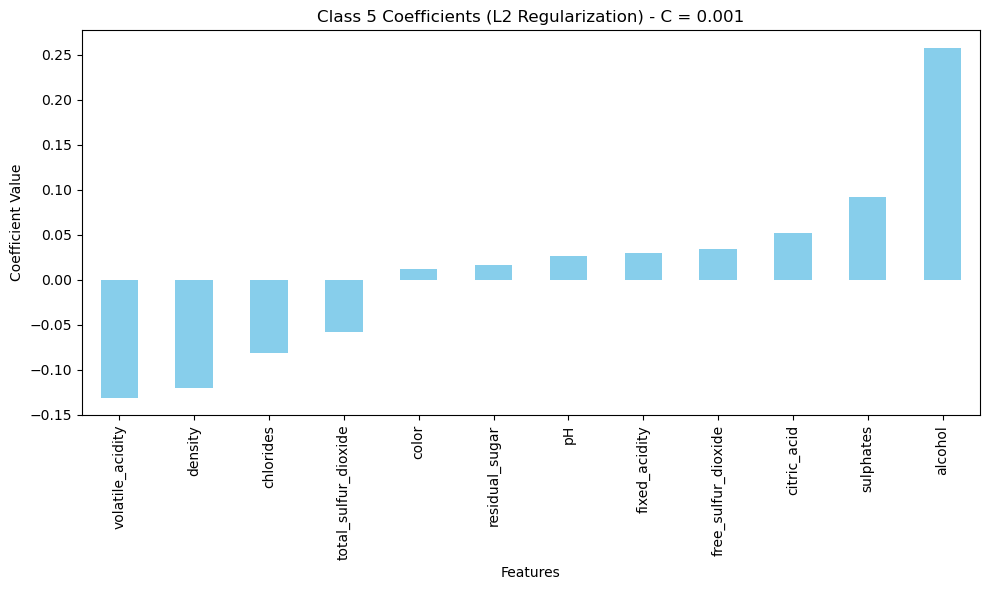

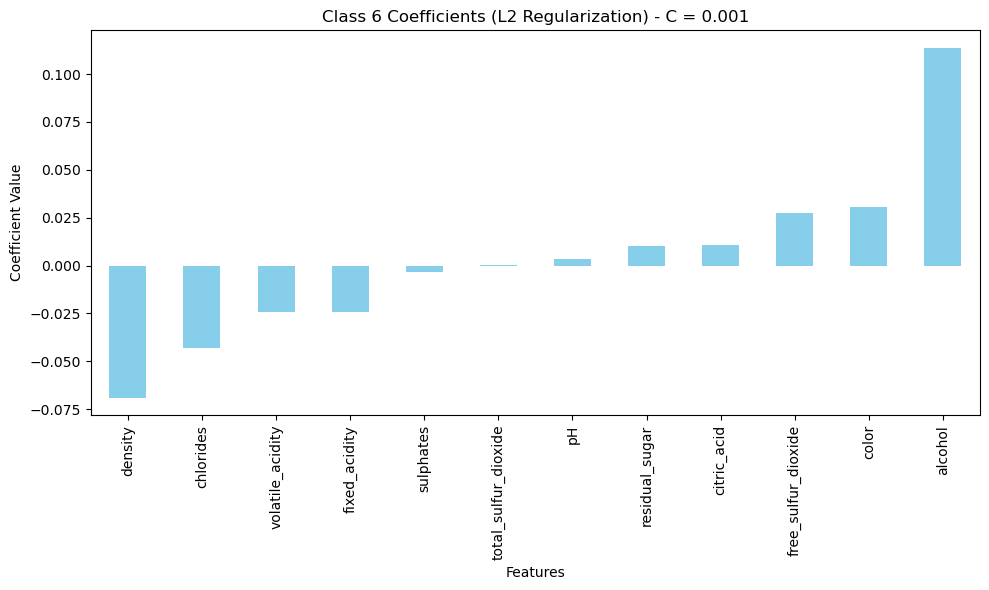

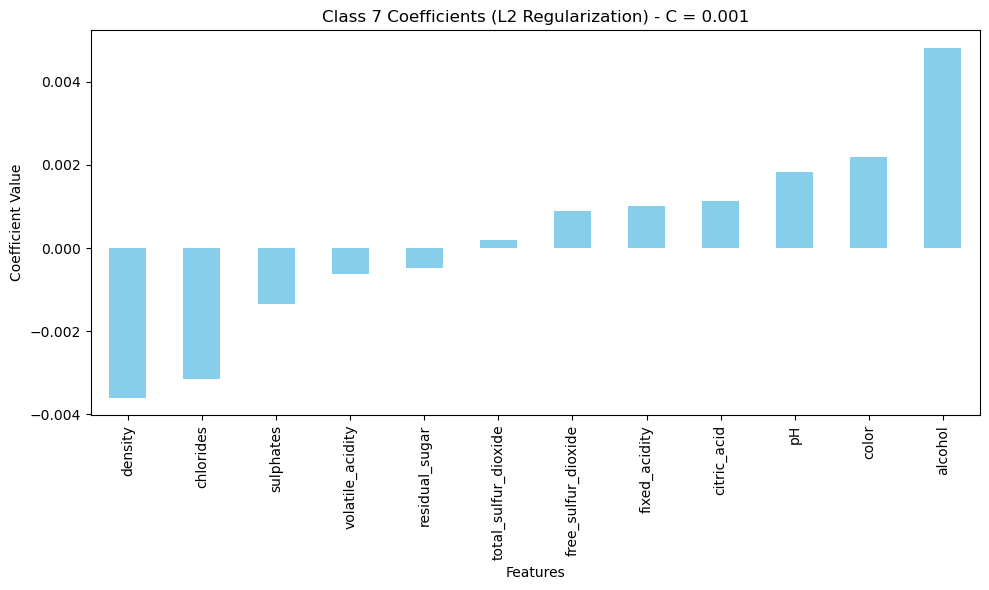

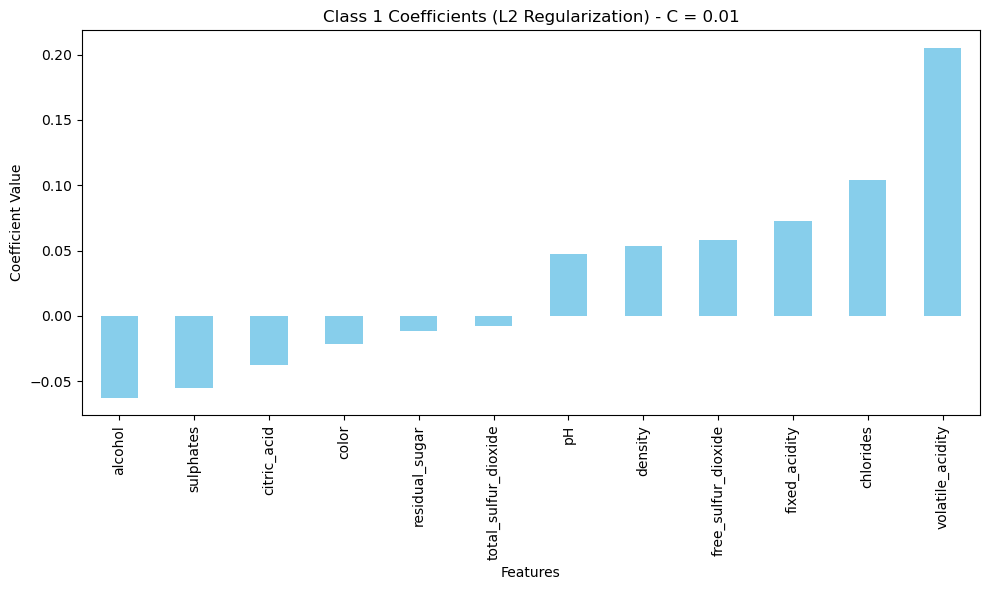

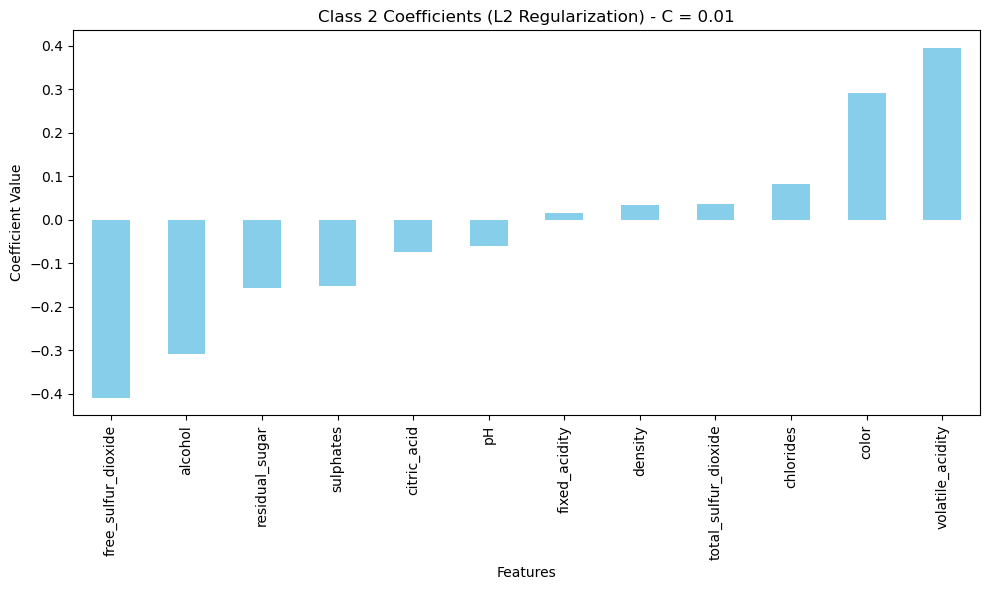

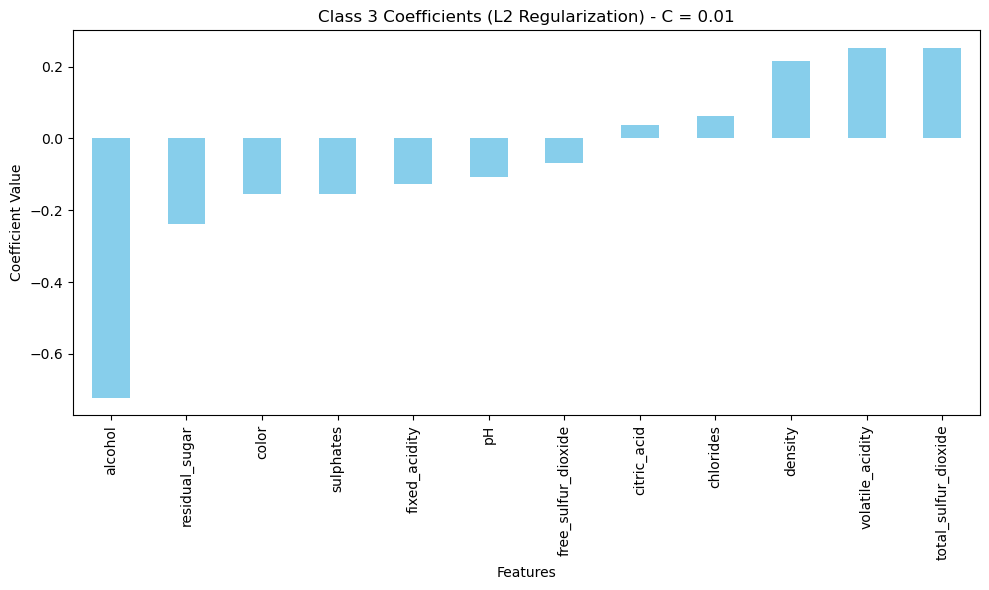

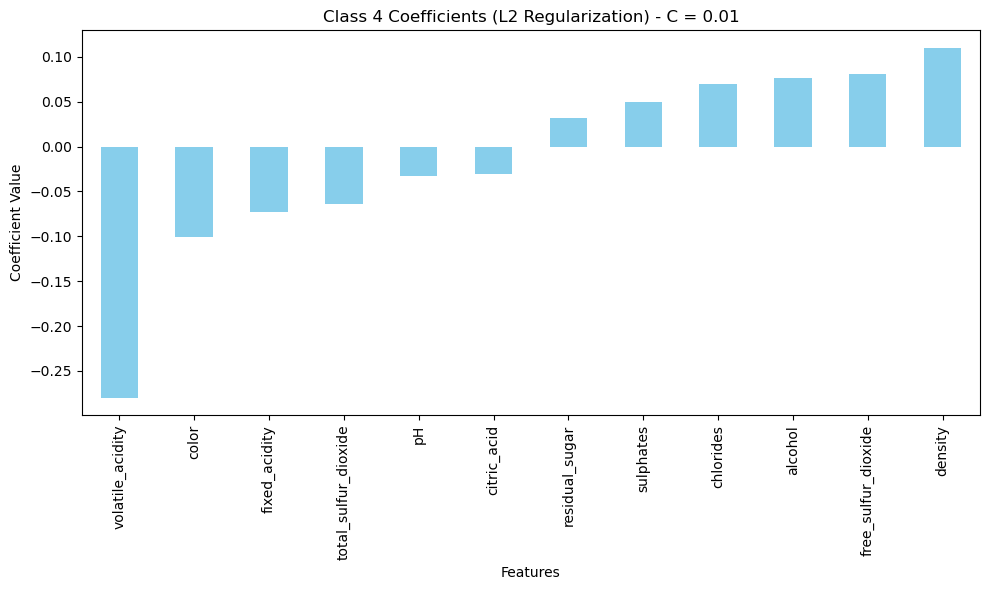

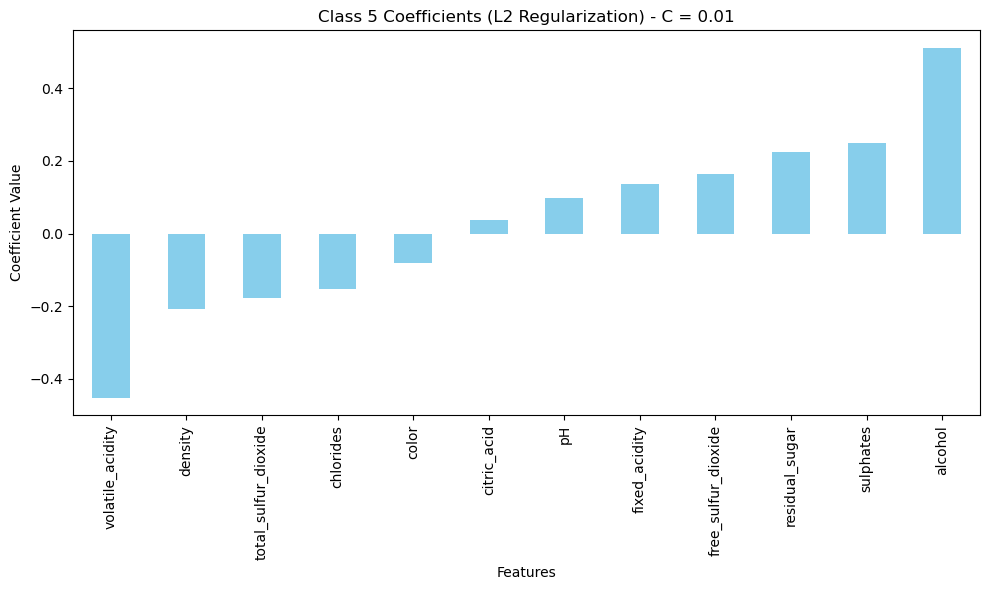

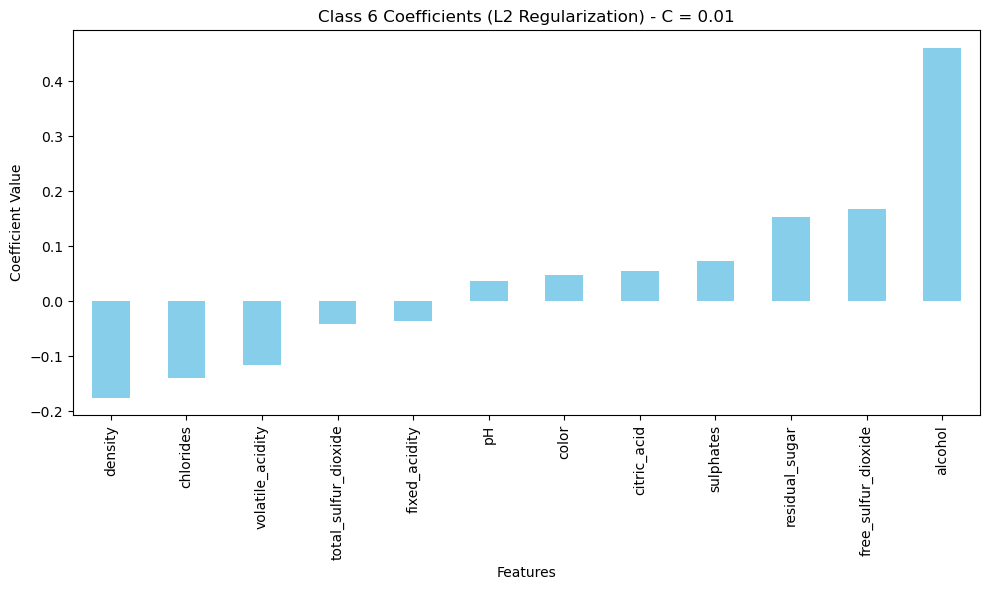

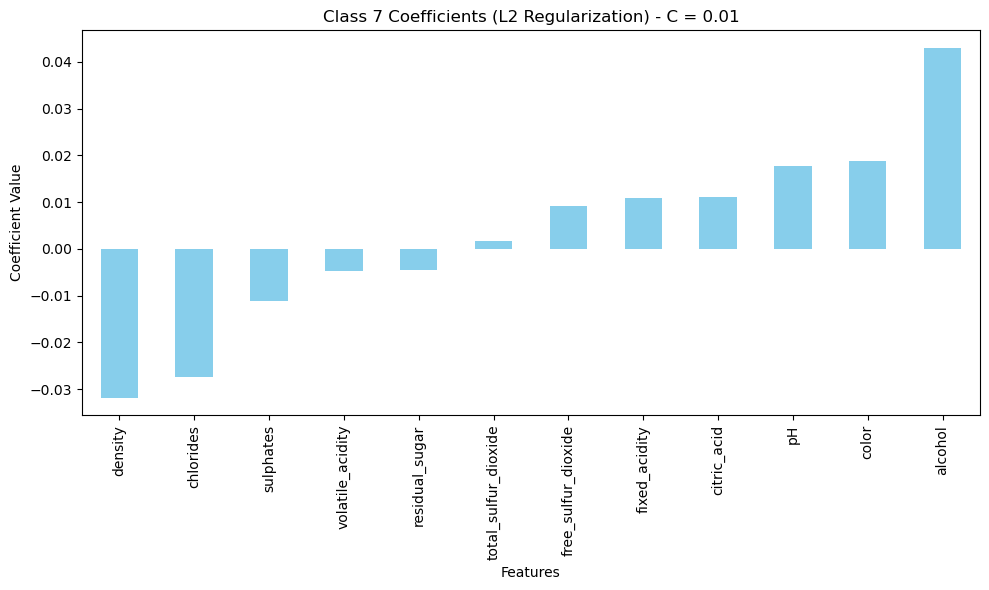

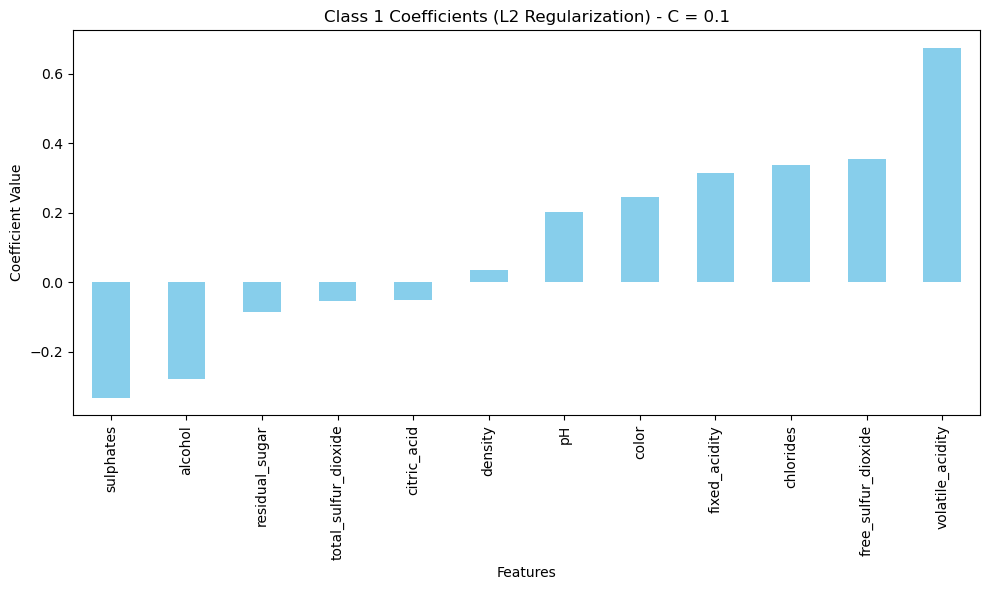

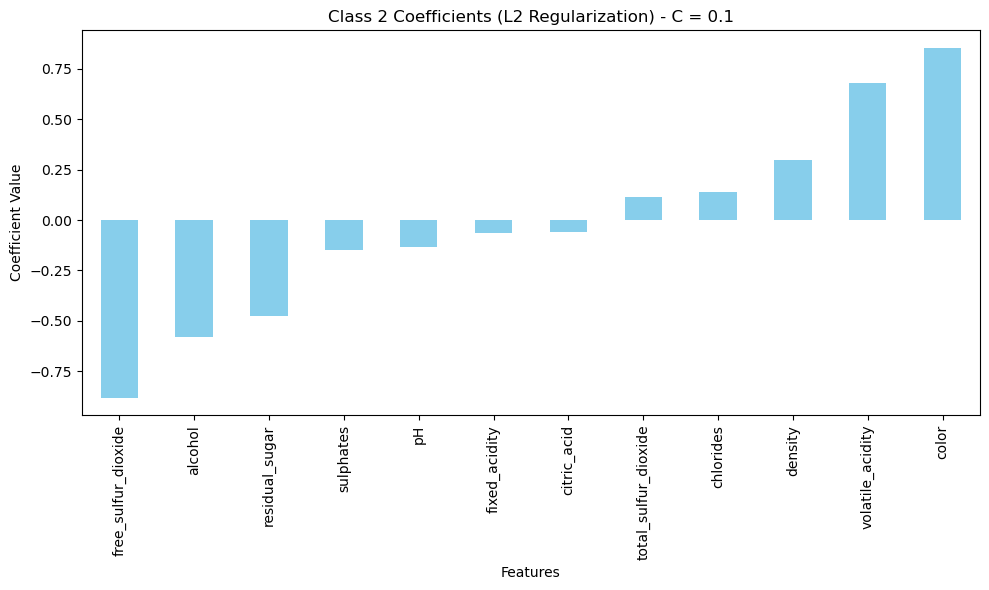

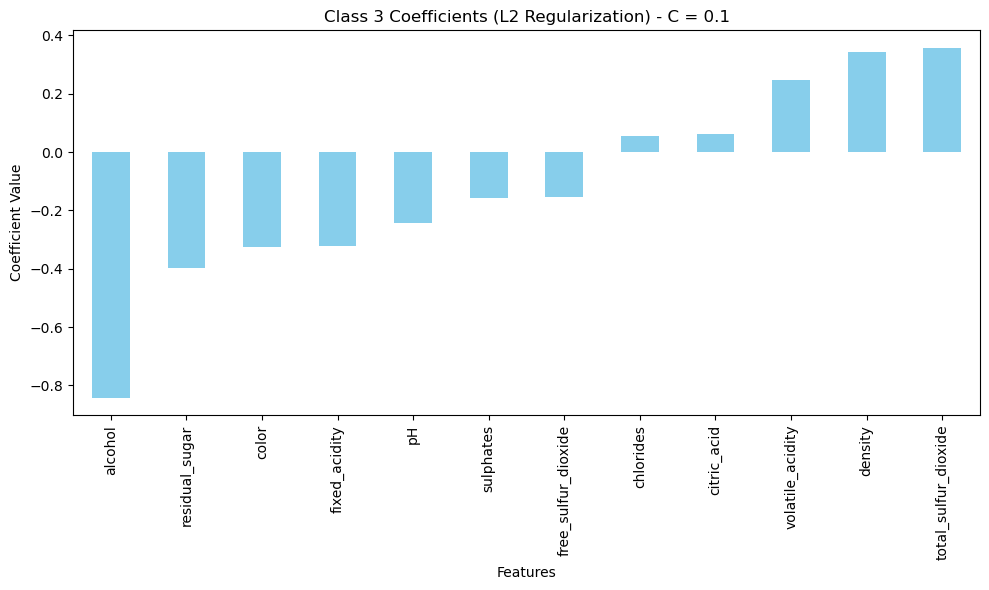

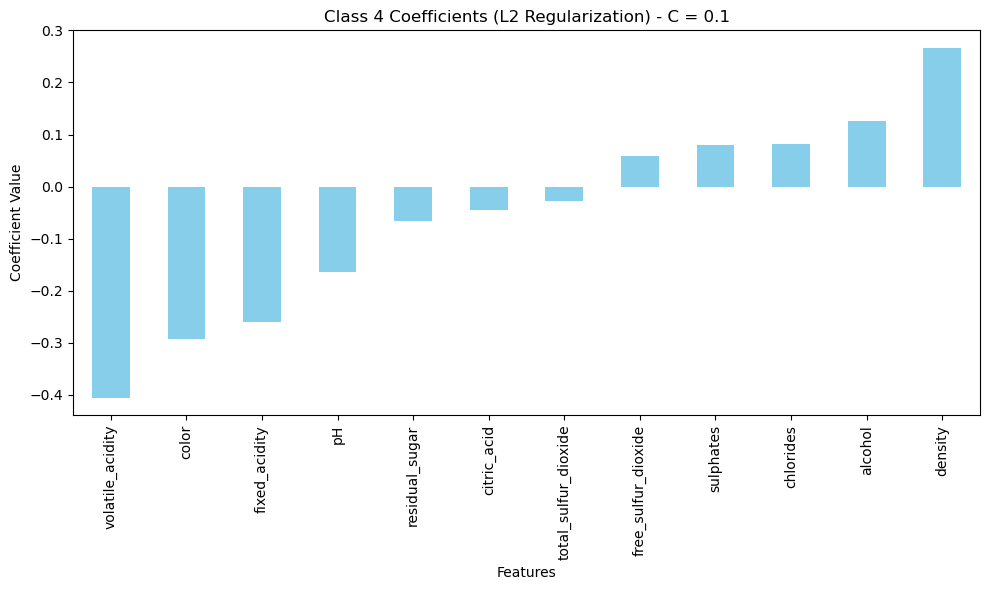

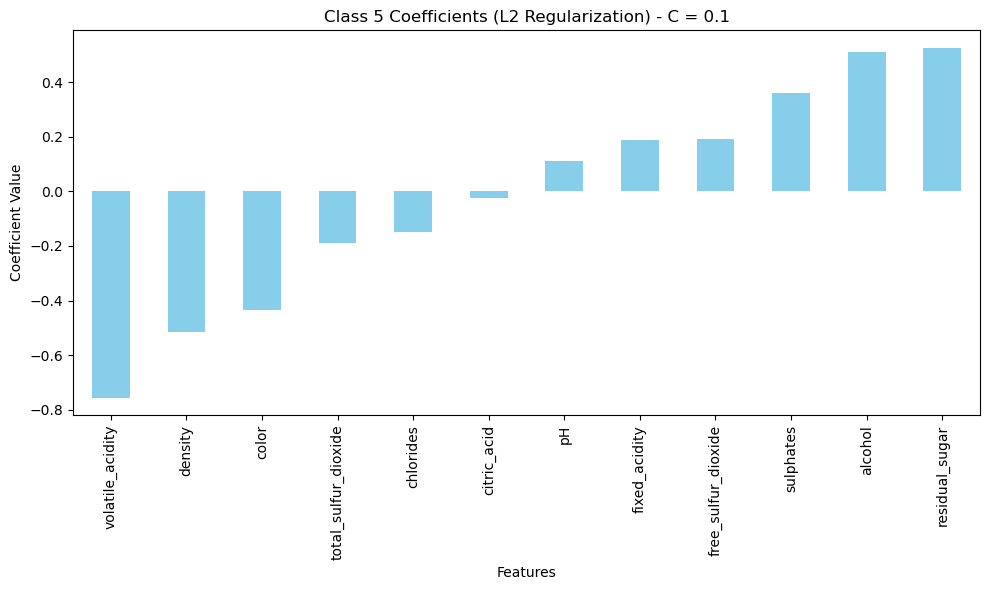

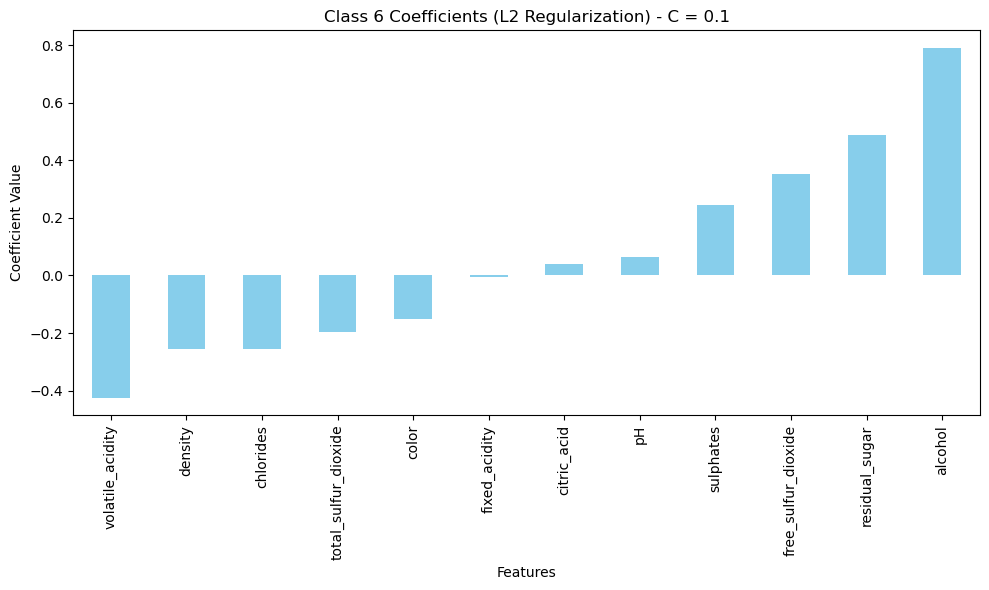

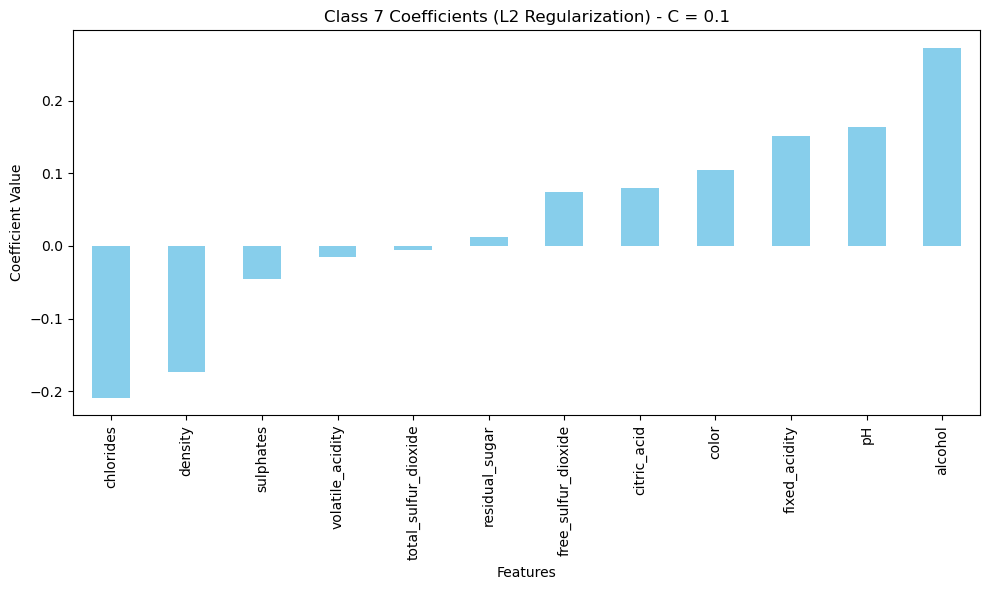

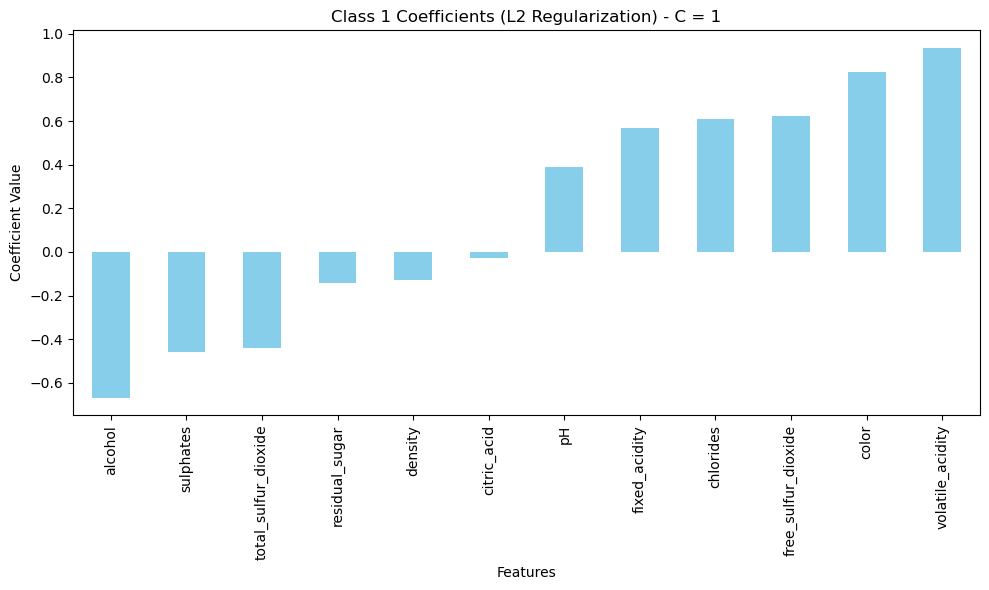

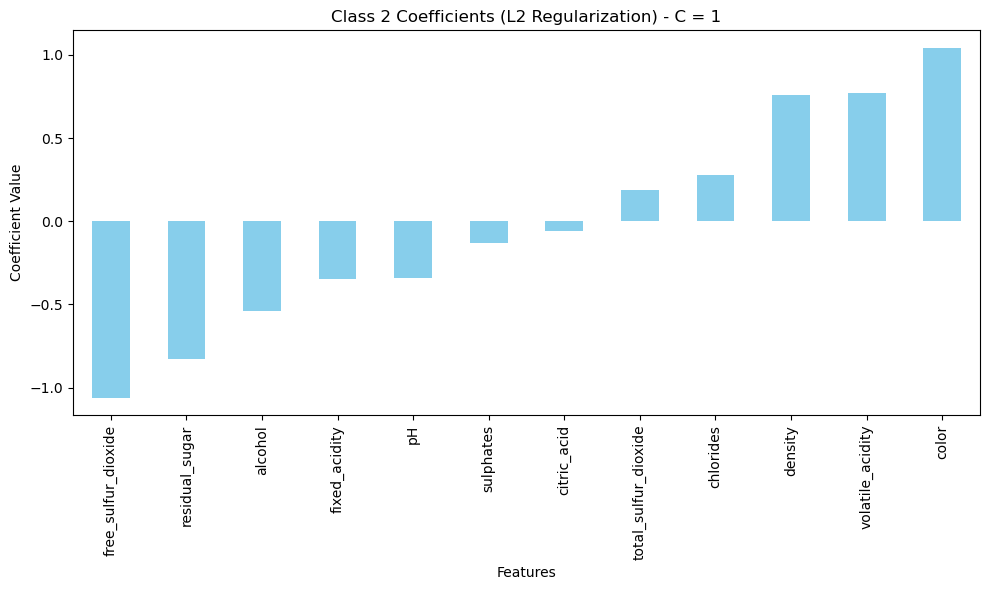

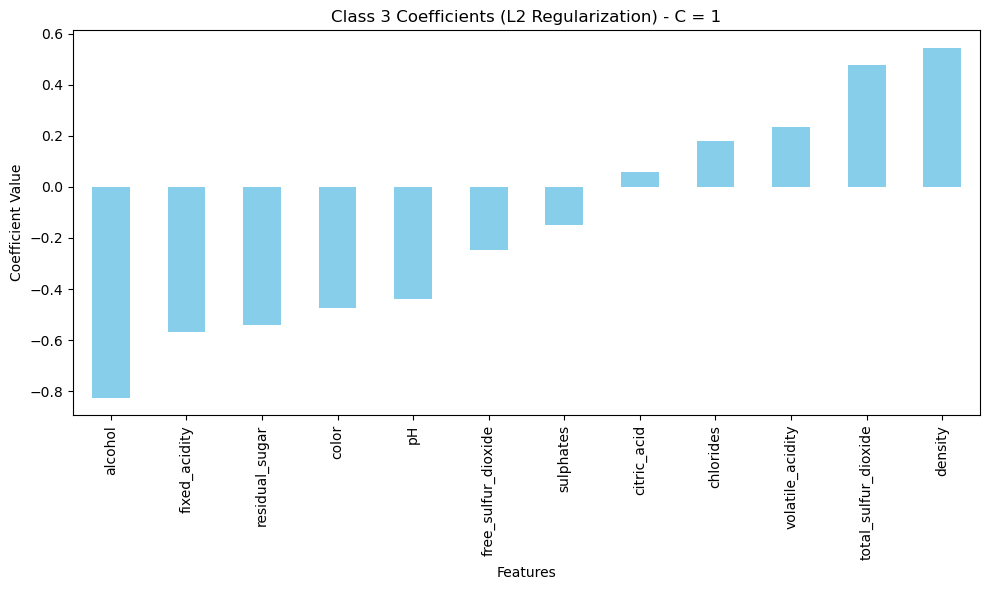

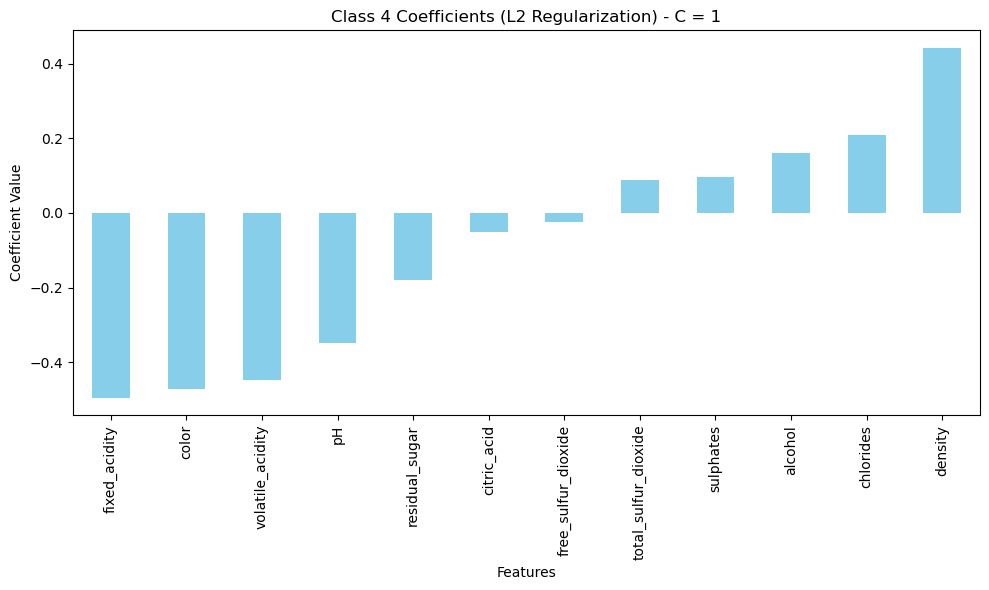

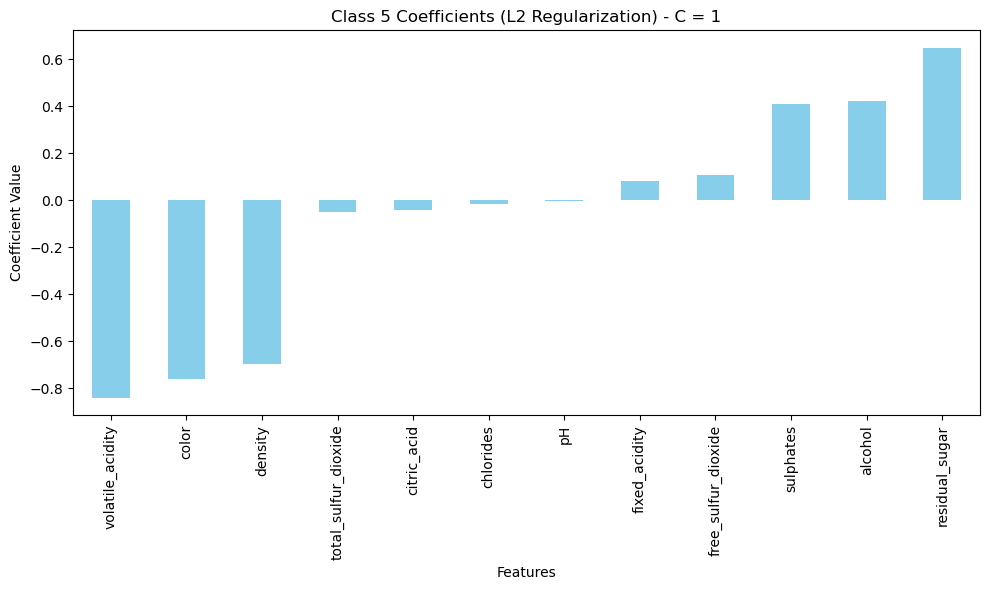

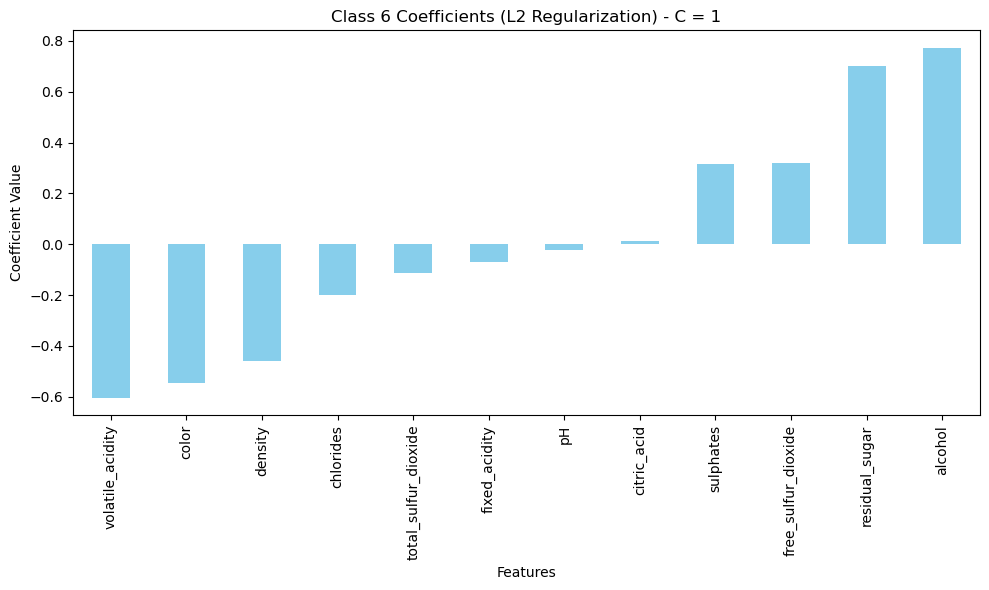

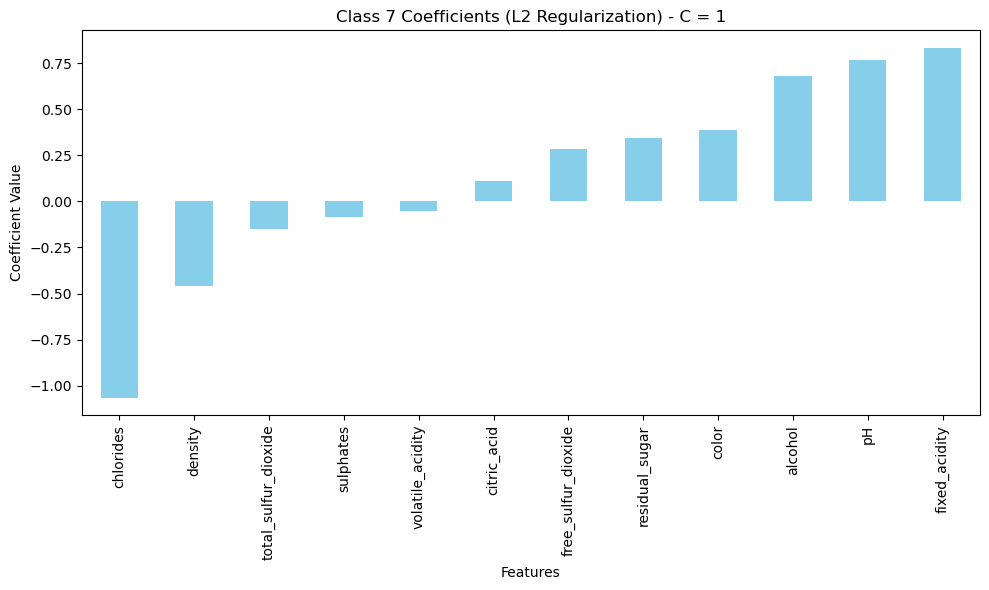

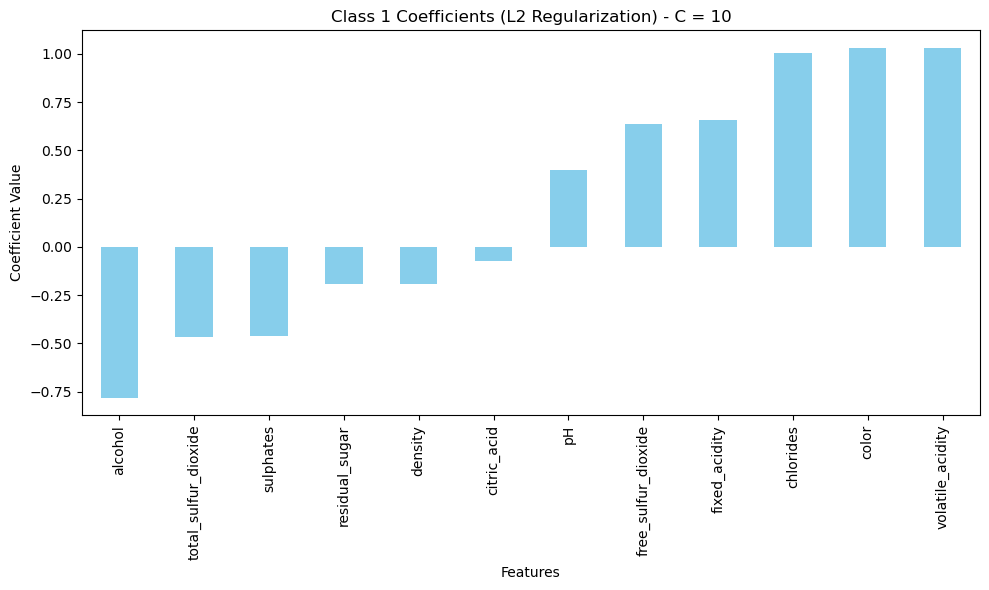

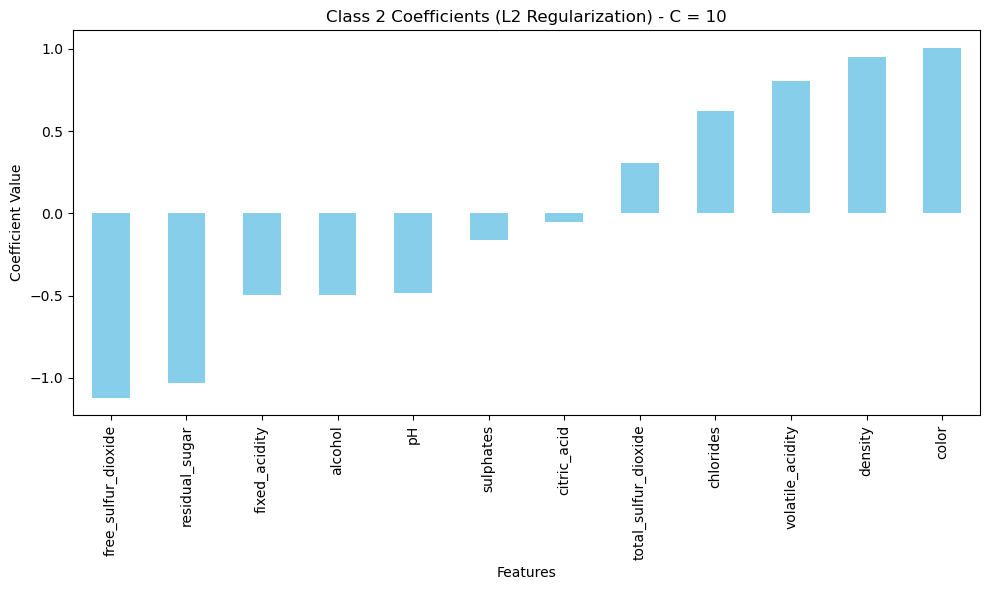

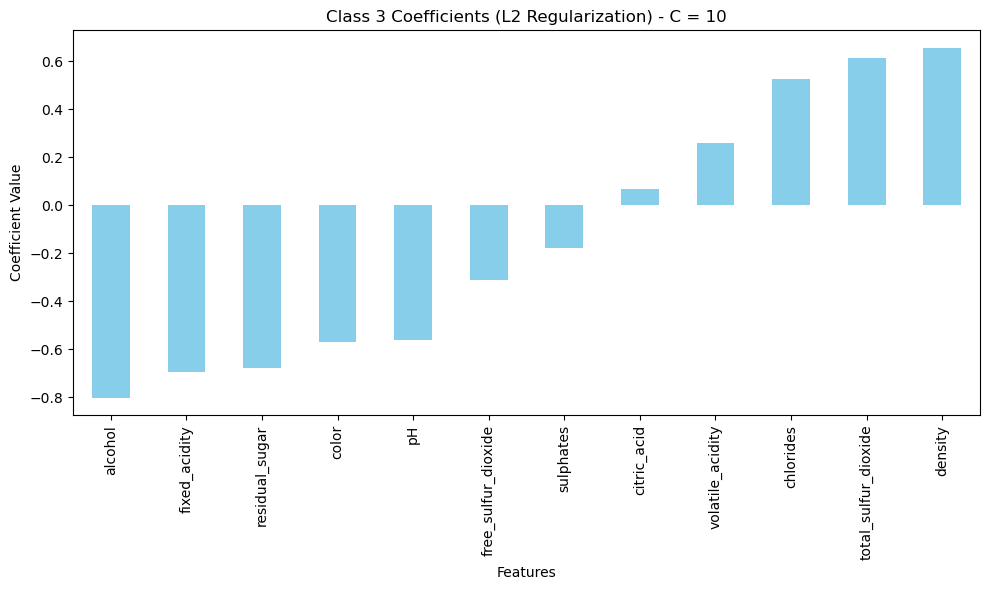

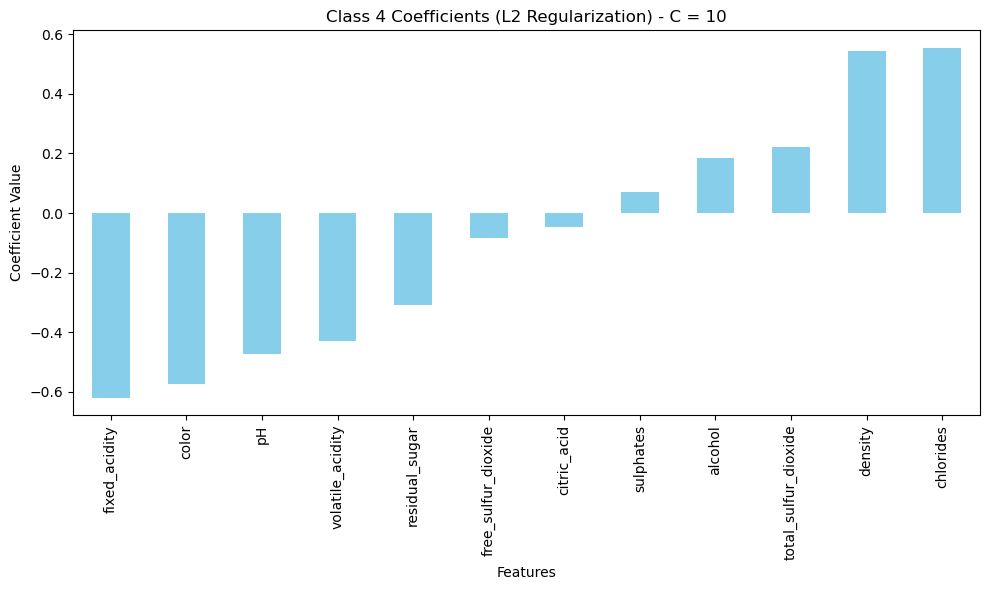

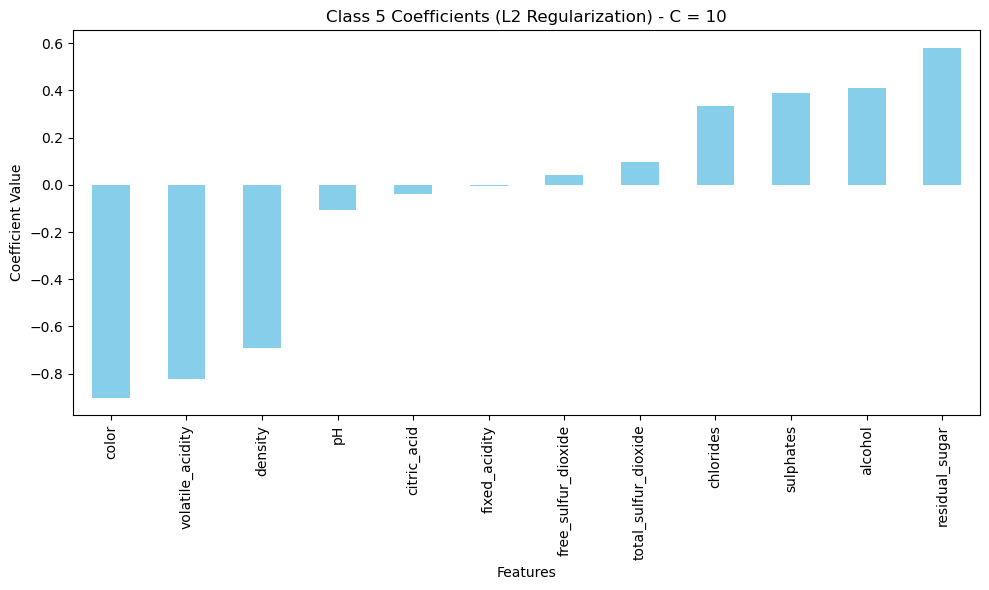

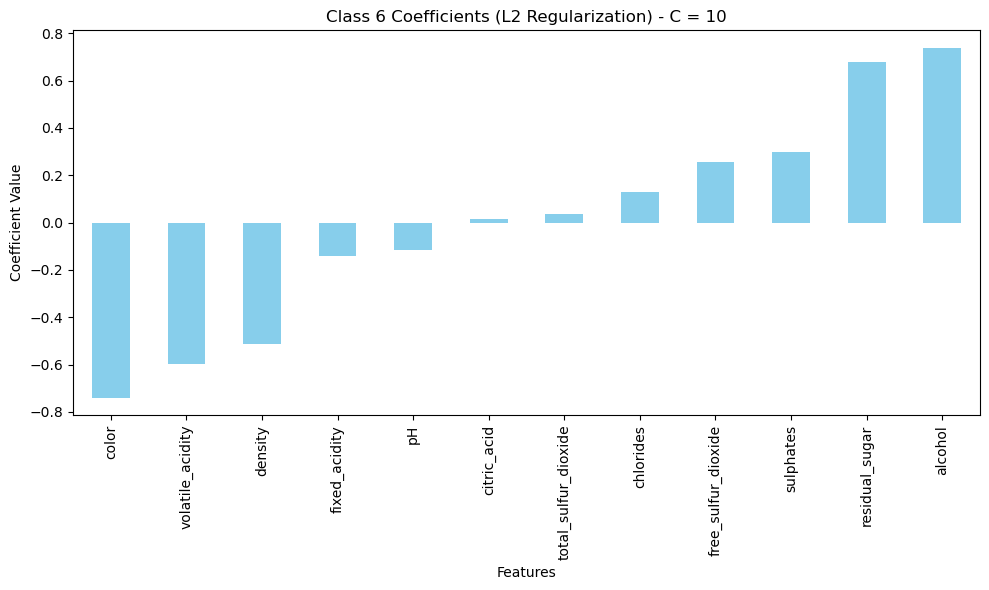

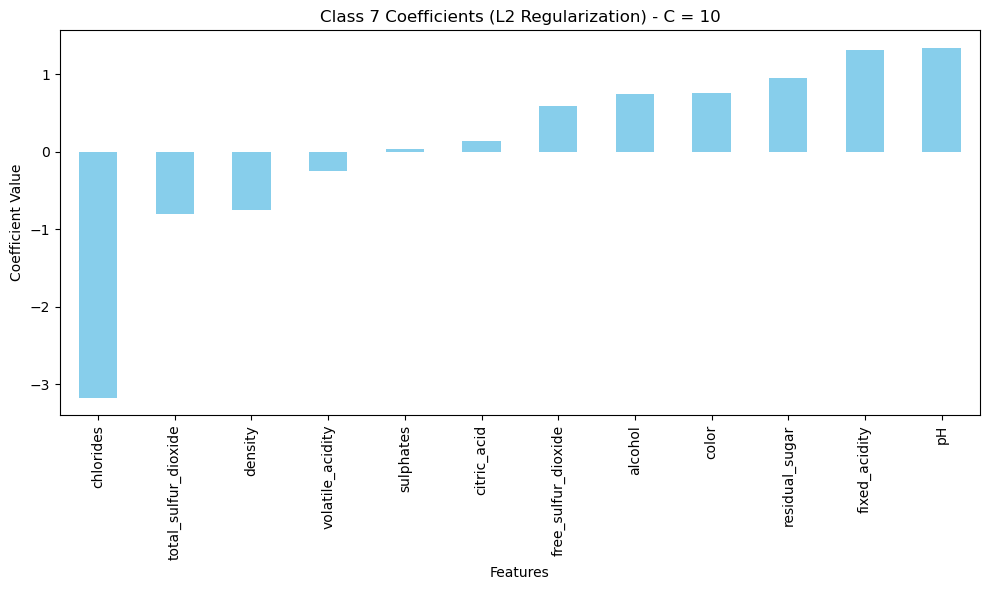

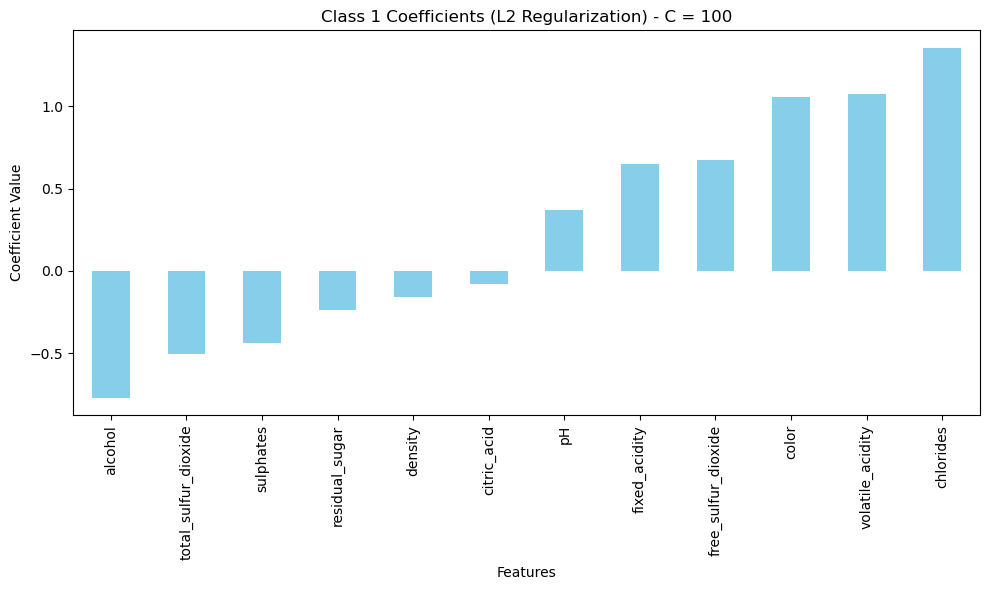

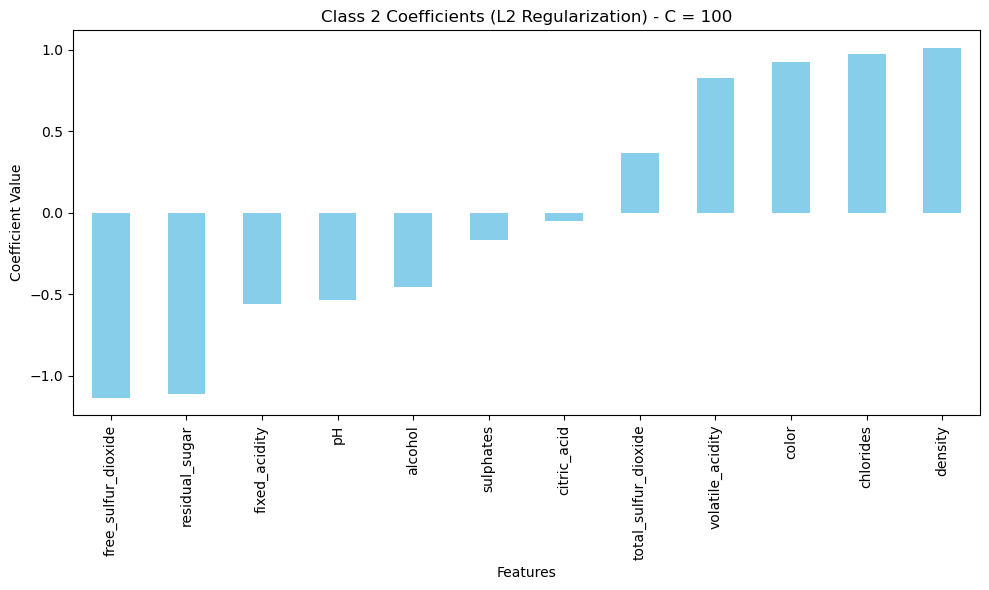

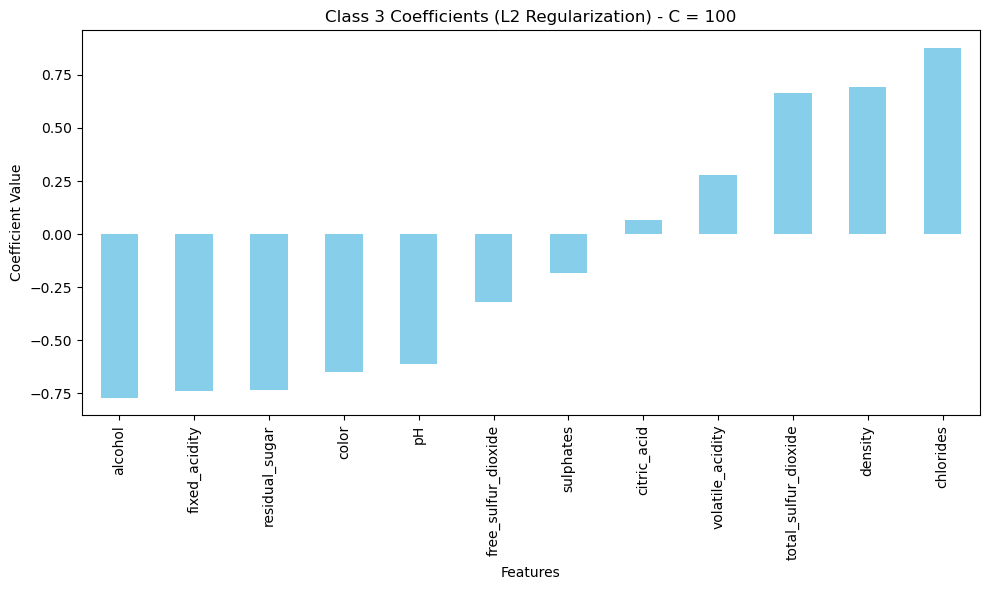

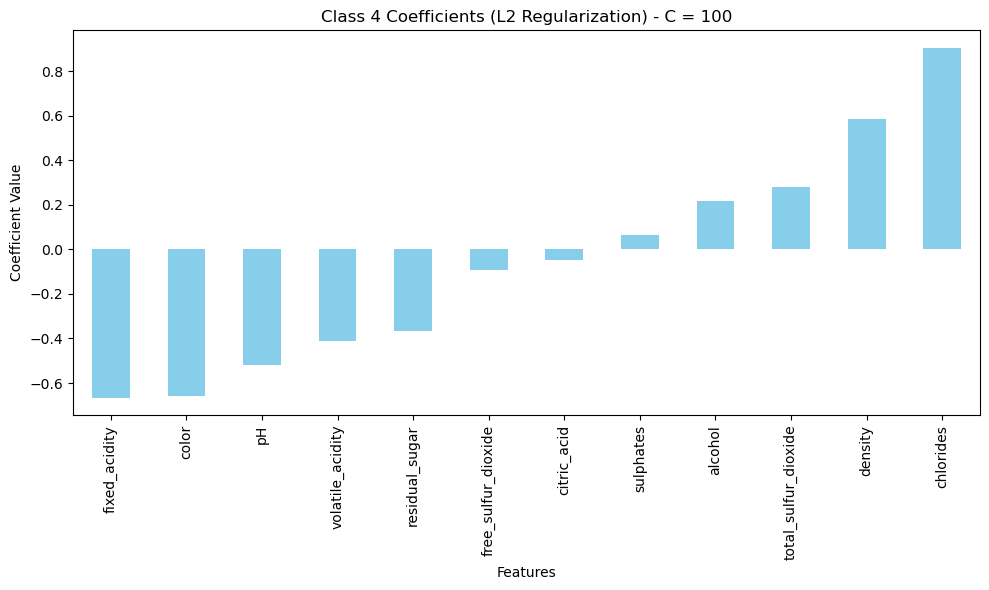

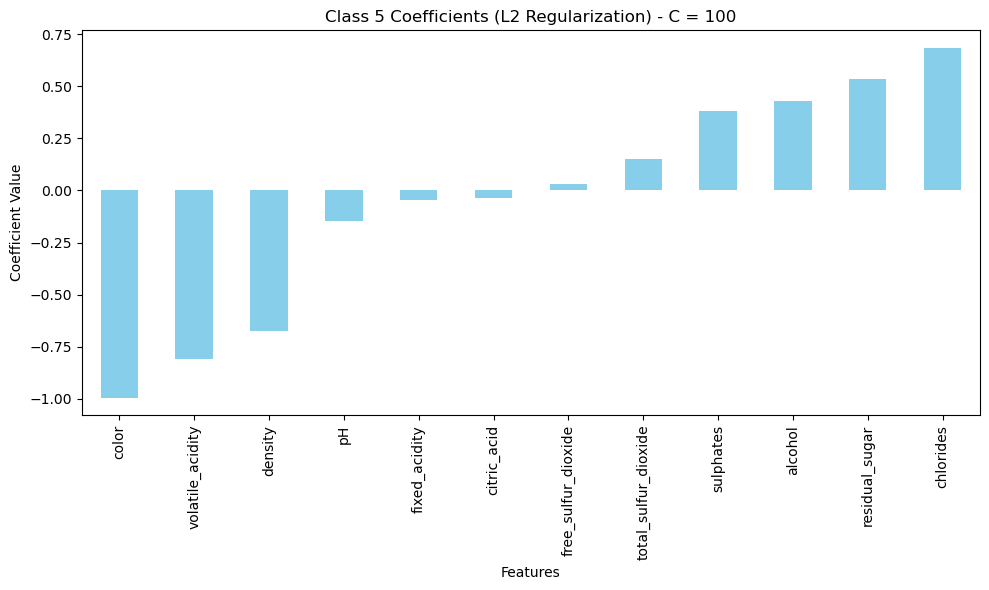

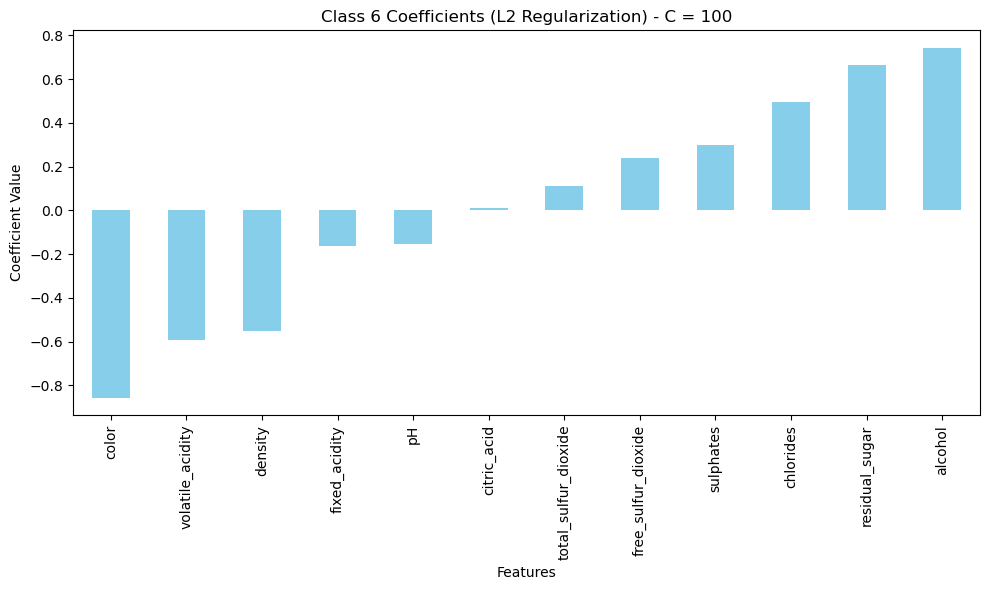

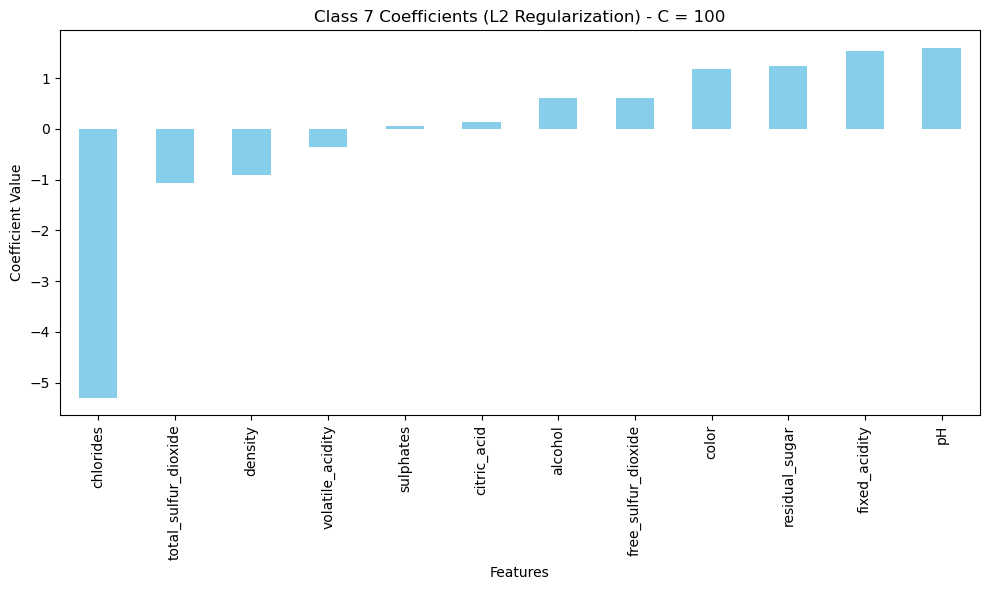

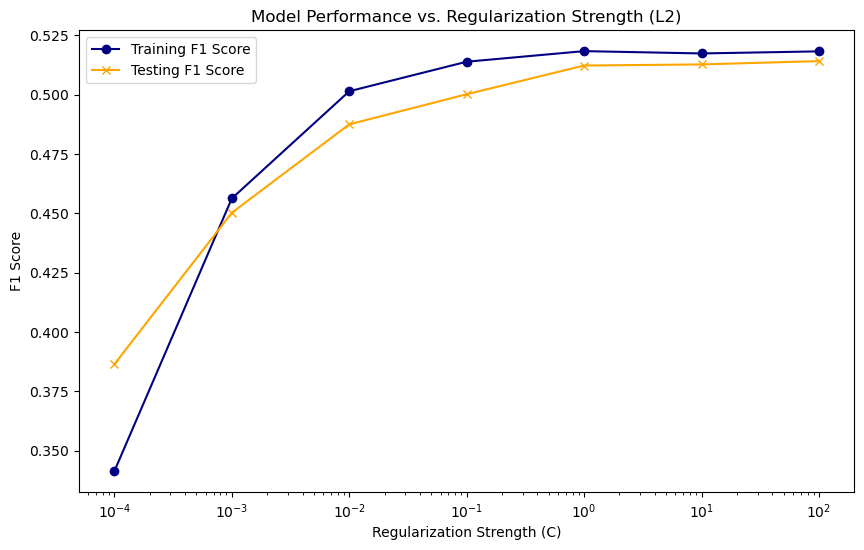

In [69]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning

# Suppress specific warnings to maintain a clean output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Step 1: Data Preparation and Preprocessing

# Encode categorical feature 'color' into numerical values
# This is necessary because machine learning models require numerical input.
label_encoder = LabelEncoder()
features['color'] = label_encoder.fit_transform(features['color'])

# Standardize the features using StandardScaler
# Standardization ensures that each feature contributes equally to the model by having a mean of 0 and a variance of 1.
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Split the data into training and testing sets (80-20 split)
# This allows us to train the model on one subset and evaluate it on another, ensuring unbiased performance metrics.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initial Logistic Regression Model (No Regularization)

# Train a Logistic Regression model without regularization to establish a baseline.
clf_no_reg = LogisticRegression(penalty=None, max_iter=10000, solver='saga')
clf_no_reg.fit(X_train, y_train)

# Visualizing Coefficients of the Model Without Regularization
# This chart shows the impact of each feature on the outcome for each class, highlighting potential overfitting.
predictors = features.columns
coefficients = clf_no_reg.coef_

for i in range(coefficients.shape[0]):
    plt.figure(figsize=(10, 6))
    coef_series = pd.Series(coefficients[i], index=predictors).sort_values()
    coef_series.plot(kind='bar', color='teal')
    plt.title(f'Class {i + 1} - Feature Coefficients (No Regularization)')
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

# Model Performance Evaluation Without Regularization
# Evaluating how well the model performs on both training and testing data.
train_f1_no_reg = f1_score(y_train, clf_no_reg.predict(X_train), average='weighted')
test_f1_no_reg = f1_score(y_test, clf_no_reg.predict(X_test), average='weighted')

print(f'Training F1 Score (No Regularization): {train_f1_no_reg:.4f}')
print(f'Testing F1 Score (No Regularization): {test_f1_no_reg:.4f}')

# Step 3: Logistic Regression with L2 Regularization

# Train the model with L2 regularization (default)
# L2 regularization penalizes large coefficients, preventing overfitting and improving generalization.
clf_l2 = LogisticRegression(max_iter=10000)
clf_l2.fit(X_train, y_train)

# Evaluating Model Performance with L2 Regularization
train_f1_l2 = f1_score(y_train, clf_l2.predict(X_train), average='weighted')
test_f1_l2 = f1_score(y_test, clf_l2.predict(X_test), average='weighted')

print(f'Ridge-Regularized Training F1 Score: {train_f1_l2:.4f}')
print(f'Ridge-Regularized Testing F1 Score: {test_f1_l2:.4f}')

# Step 4: Effect of Different Regularization Strengths (L2) on Model Performance

# Defining a range of regularization strengths
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_scores = []
test_scores = []
coef_values = []

# Training models with varying strengths of L2 regularization and recording performance
for C in C_values:
    clf = LogisticRegression(C=C, penalty='l2', max_iter=10000)
    clf.fit(X_train, y_train)
    
    # Store F1 Scores for Training and Testing
    train_scores.append(f1_score(y_train, clf.predict(X_train), average='weighted'))
    test_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
    
    # Store Coefficients for Visualization
    coef_values.append(clf.coef_)

# Step 5: Visualizing the Effect of Regularization Strengths on Coefficients

# Plot the coefficients for each class and regularization strength
for idx, coef in enumerate(coef_values):
    for class_idx in range(coef.shape[0]):
        plt.figure(figsize=(10, 6))
        coef_series = pd.Series(coef[class_idx], index=predictors).sort_values()
        coef_series.plot(kind='bar', color='skyblue')
        plt.title(f'Class {class_idx + 1} Coefficients (L2 Regularization) - C = {C_values[idx]}')
        plt.xlabel("Features")
        plt.ylabel("Coefficient Value")
        plt.tight_layout()
        plt.show()

# Step 6: Plotting Model Performance vs. Regularization Strength

# This plot shows the trade-off between model complexity and performance.
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_scores, marker='o', label='Training F1 Score', color='navy')
plt.plot(C_values, test_scores, marker='x', label='Testing F1 Score', color='orange')
plt.xscale('log')  # Log scale to better visualize changes
plt.xlabel('Regularization Strength (C)')
plt.ylabel('F1 Score')
plt.title('Model Performance vs. Regularization Strength (L2)')
plt.legend()
plt.show()


Conclusion:

This project provides a detailed analysis of logistic regression with an emphasis on the effects of L2 regularization. Our findings reveal that while the unregularized model can perform well on the training set, it often overfits, leading to suboptimal performance on unseen data. Introducing L2 regularization mitigates overfitting by penalizing large coefficients, enhancing the model's generalization capabilities.

The analysis also highlights the delicate balance between underfitting and overfitting as we adjust the regularization strength (C). Lower values of C lead to higher penalties on the coefficients, reducing the model's flexibility but improving stability. Conversely, higher values of C allow more complex models at the risk of capturing noise.

Our comprehensive visualizations of model coefficients demonstrate the regularization effect, showing how L2 constraints reduce the influence of less important features. This project underscores the importance of careful hyperparameter tuning in developing robust and interpretable models, providing valuable insights for data scientists and practitioners.